In [29]:
import os 
import random
import numpy as np
from PIL import Image

from datetime import datetime
import pickle
from tqdm import tqdm #loading bar  

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as ParentDataset

from torchvision import transforms
from torchvision.transforms import Compose

import sklearn.metrics

import segmentation_models_pytorch as smp #model we're using for now. 
import evaluateModel

from matplotlib import pyplot as plt

In [25]:
#Errors associated to potantial randomness / non-deterministic behaviour is a VERY common issue in PT. 
#Look at the following github discussion for more information: 
#https://github.com/pytorch/pytorch/issues/7068
#      sbelharbi commented on Apr 19, 2019

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [26]:
#This is related to the init function of the worker(s) to be fed to the DataLoader
def _init_fn(worker_id):
    np.random.seed(int(seed))

In [27]:
class TBI_dataset(ParentDataset): #Obtain the attributes of ParentDataset from torch.utils.data
#Finds Image and Label locations, creates random list of indicies for training / val / testing sets to be called
    def __init__(
        self,
        images_dir,
        labels_dir,
        train_size = 0.75, #fraction of total number of samples to be used in training set
        subset="train",
        transform = None, #base transformation is into Tensor. 
        random_sampling=True,
        seed=seed, #We'll get the same thing everytime if we keep using the same seed. 
    ):
        #filter and sort the list
        self.ImageIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(images_dir)))) 
        self.LabelIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(labels_dir))))
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ImageIds] #full_paths to slices
        self.labels_fps = [os.path.join(labels_dir, image_id) for image_id in self.LabelIds] #full_paths to labels
        
        if random_sampling == True:
            samples = list(range(0,len(self.images_fps))) #create a list of numbers
            random.seed(seed) #set the seed
            
            #random sample train_size amount and then do a train/validation split 
            indicies = random.sample(samples,round(train_size*len(samples)))
            self.val_indicies = indicies[0:round(len(indicies)*0.15)]
            self.train_indicies = indicies[round(len(indicies)*0.15) : len(indicies)]
            
            test_indicies = samples
            for j in sorted(indicies, reverse = True): #remove the train/val indicies from test set
                del test_indicies[j]
            
            #suffles without replacement. 
            self.test_indicies = random.sample(test_indicies, len(test_indicies)) 

        #We define a mapping to use when calling the Dataset loader based on the parameter "subset"
        if subset == "train":
            self.mapping = self.train_indicies
        elif subset == "val":
            self.mapping = self.val_indicies
        elif subset == "test":
            self.mapping = self.test_indicies
        else:
            print("subset parameter requires train, val, or test exactly.")
            
        self.transform = transform #trasform given by transform_function
            
    def __getitem__(self, ii): #ii is the index
        
        #Current implementations of transforms only use PIL images.
        #Apparently we can use np.array(Image.open(...)) to remove the error that happens each epoch
        image = Image.open(self.images_fps[self.mapping[ii]]) #open as PIL image. 
        label = Image.open(self.labels_fps[self.mapping[ii]])
         
        image = self.transform(image)
        label = self.transform(label)
             
        return image, label #, self.images_fps[self.mapping[ii]],self.labels_fps[self.mapping[ii]]
    
    def __len__(self):
        return len(self.mapping)
    
    
def datasets(images_dir, labels_dir, train_size, aug_angle, aug_scale, flip_prob):
    train = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        train_size = 0.75,
        subset = "train",
        transform = transform_function(degrees=aug_angle, scale=aug_scale, flip_prob=flip_prob),
    )
    valid = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        train_size = 0.75,
        subset = "val",
        transform = transform_function(degrees=aug_angle, scale=aug_scale, flip_prob=flip_prob),
    )
    
    test = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        train_size = 0.75,
        subset="test",
        transform = transform_function(degrees=0, scale = [1,1], flip_prob = 0), #make sure nothing changes. 
    )
    
    return train, valid, test

def transform_function(degrees,scale,flip_prob):
    transform_list = []
    
    transform_list.append(transforms.RandomAffine(degrees, scale = scale))
    transform_list.append(transforms.RandomHorizontalFlip(p=flip_prob))
    transform_list.append(transforms.Pad(37)) #all images should be 182x182 before padding. 
    transform_list.append(transforms.ToTensor())
    
    return Compose(transform_list)

def Weights(labels):
    #expects an [batch_size,c,n,n] input 
    
    weights = []
    for batch_num in range(0,labels.shape[0]):
        num_ones = torch.sum(labels[batch_num,0,:,:]);
        resolution = labels.shape[2] * labels.shape[3]
        num_zeros = resolution - num_ones 
        weights.append(num_zeros / (num_ones + 1))
        
    #this keeps the clas imbalance in check
    return torch.Tensor(weights) #to ensure that we're getting a real number in the division  

In [5]:
train_size = 0.75
batch_size = 12
EPOCHS = 100
lr = 0.0001
aug_angle = 25
aug_scale = [1,1.5]
flip_prob = 0.5
num_workers = 1
images_dir = "/home/mccrinbc/Registered_Brains_FA/normalized_slices"
labels_dir = "/home/mccrinbc/Registered_Brains_FA/slice_labels"

#images_dir = "/Users/brianmccrindle/Documents/Research/TBIFinder_Final/Registered_Brains_FA/test_slices"
#labels_dir = "/Users/brianmccrindle/Documents/Research/TBIFinder_Final/Registered_Brains_FA/test_labels"

#smp specific variables
ENCODER = 'resnet101'
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    #activation='softmax2d',    # activation function, default is None. This is the output activation. softmax2d specifies dim = 1 
    classes=1,                 # define number of output labels
)

#classes = 2 for the softmax transformation. 
model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)

In [6]:
train_dataset, valid_dataset, test_dataset = datasets(images_dir, labels_dir, train_size, aug_angle, aug_scale, flip_prob)

In [7]:
test_dataset.transform

Compose(
    RandomAffine(degrees=(0, 0), scale=[1, 1])
    RandomHorizontalFlip(p=0)
    Pad(padding=37, fill=0, padding_mode=constant)
    ToTensor()
)

In [8]:
def train_validate(train_dataset, valid_dataset, lr):
    
    earlystop = False 
    
    if torch.cuda.is_available():
        dev ="cuda:2"
    else:
        dev = "cpu"
        
    dev = torch.device(dev)
    
    #this might break, remove worker_init_fn = _init_fn(num_workers)) if so
    train_loader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = num_workers, worker_init_fn = _init_fn(num_workers))
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle = True, num_workers = num_workers, worker_init_fn = _init_fn(num_workers))
    
    model.to(dev) #cast the model onto the device 
    optimizer = optim.Adam(model.parameters(), lr = lr) #learning rate should change 
    
    loss_function = torch.nn.BCELoss() #this takes in a weighted input and incorporates a sigmoid transformation
    #loss_function = smp.utils.losses.DiceLoss()
    #loss_function = DiceLoss()
    #metrics = [smp.utils.metrics.IoU(threshold=0.5)]
    
    loss_train = []
    loss_valid = []
    epochLoss_train = []
    epochLoss_valid = []
        
    for epoch in range(EPOCHS):
        image_count = 0
        for phase in ["train","val"]:
            
            #This determines which portions of the model will have gradients turned off or on. 
            if phase == "train":
                model.train() #put into training mode
                loader = train_loader
            else:
                model.eval() #evaluation mode.
                loader = valid_loader
                  
            for ii, data in enumerate(loader): 
                
                brains = data[0] #[batch_size,channels,height,width] 
                labels = data[1]
                
                image_count += len(brains)
                print(epoch, phase, ii, image_count)
                
                brains,labels = brains.to(dev), labels.to(dev) #put the data onto the device
                predictions, single_class = model(brains) #single class is not a useful output. 
                
                predictions = torch.sigmoid(predictions) #using this so that the output is bounded [0,1]
                single_class = torch.sigmoid(single_class)
                
                weights = Weights(labels) #generate the weights for each slice in the batch
                loss_function.pos_weight = weights                    
                
                loss = loss_function(predictions, labels) #loss changes here. 
                
                if phase == "train":
                    #employ this so we don't get multiples in the same list. 
                    if (loss_valid and ii == 0): #if loss_valid is NOT empty AND it's the first time we see this
                        epochLoss_valid.append(loss_valid[-1]) #append the last value in the 
                        
                    model.zero_grad() #recommended way to perform validation
                    loss_train.append(loss.item())
                    loss.backward()
                    optimizer.step()
                    
                    print(f"Phase: {phase}. Epoch: {epoch}. Loss: {loss.item()}") 
               
                else:
                    if (loss_train and ii == 0):#if loss_valid is NOT empty AND it's the first time we see this
                        epochLoss_train.append(loss_train[-1]) #append the last value in the loss_train list.
                        
                    loss_valid.append(loss.item())
                    print(f"Phase: {phase}. Epoch: {epoch}. Loss: {loss.item()}") 
                    
                    #learning rate changes and early stopping
                    if epoch > 0:
                        if (epoch % 10) == 0: #if the epoch is divisable by 10
                            meanVal = np.mean(loss_valid[epoch - 10 : epoch])
                            if np.abs((meanVal - loss.item()) / meanVal) <= 0.05: #if the % difference is small
                                for param_group in optimizer.param_groups:
                                    print('Reducing the Learning Rate: ' )
                                    lr = lr * 0.1 #reduce the learning rate by a factor of 10. 
                                    print('Reducing the Learning Rate: ', lr )
                                    param_group['lr'] = lr
                        
                        if (epoch % 50) == 0:
                            meanVal = np.mean(loss_valid[epoch - 50 : epoch])
                            if np.abs((meanVal - loss.item()) / meanVal) <= 0.05:
                                earlystop = True 
               
                #Implementation of early stopping
                if earlystop == True:
                    date = datetime.now()
                    torch.save(model.state_dict(), os.path.join(os.getcwd(), "Registered_Brains_FA/models_saved", "TBI_model-epoch" + str(epoch) + '-' + str(date.date()) + '-' + str(date.hour) + '-' + str(date.minute) +"-EARLYSTOP.pt")) #save the model 
                    break
            else:
                continue
            break
        else:
            #save the model at the end of this epoch.
            #date = datetime.now()
            #torch.save(model.state_dict(), os.path.join(os.getcwd(), "Registered_Brains_FA/models_saved", "TBI_model-epoch" + str(epoch) + '-' + str(date.date()) + '-' + str(date.hour) + '-' + str(date.minute) + ".pt"))
            continue
        break
    
    #Need to add the last element from loss_valid to epochLoss_valid to equal the number of epochs. 
    epochLoss_valid.append(loss_valid[-1])
    return brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, model.state_dict()


In [9]:
#This function expects singular images. 
#Also biased from high class imbalance. function currently not in use. 
def IoU(prediction, label):
    #Prediction IoU
    intersection = int(torch.sum(torch.mul(prediction,label)))
    union = int(torch.sum(prediction) + torch.sum(label)) - intersection
    IOU_predicted = intersection / (union + 0.0001) #for stability
    
    #Background IoU
    all_zeros = (prediction + label) > 0 #before the inversion
    intersection = int(torch.sum(~all_zeros))
    union = int(torch.sum(~ (prediction > 0)) + torch.sum(~ (label > 0)) - intersection)
    IOU_background = intersection / (union + 0.0001)
    
    mean_IOU = (IOU_background + IOU_predicted)/2
    return mean_IOU

In [193]:
def testModel(test_dataset, modelPath, threshold): #model = the model class = smp.UNet()

    total_images = 0
    mean_IoUs = []
    CM_values = [0,0,0,0] #tp, fp, fn, tn
    model.load_state_dict(torch.load(modelPath))
    
    if torch.cuda.is_available():
        dev ="cuda:2"
    else:
        dev = "cpu"
        
    dev = torch.device(dev)
    model.to(dev) 
    model.eval() #evaluation mode to turn off the gradients / training. 
    
    #turn shuffle off 
    loader = DataLoader(test_dataset, batch_size = 8, shuffle = False, num_workers = num_workers)
    for ii, data in tqdm(enumerate(loader)):
        
        brains = data[0]
        labels = data[1]
        
        #move the data to the GPU 
        brains = brains.to(dev)
        labels = labels.to(dev)
        
        total_images += brains.shape[0] #this would be the same if we used labels or predictions. 
        #print(total_images)
        
        predictions, _ = model(brains)
        predictions = torch.sigmoid(predictions) 
        
        predictions_numpy = predictions.cpu().detach().numpy()
        labels_numpy = labels.cpu().detach().numpy()
        for j in range(predictions.shape[0]):
            #labels = [False, True] are needed to make sure we don't have errors with the shape of CM
            #mean_IoUs.append(IoU(predictions[j,0,:,:].cpu() > threshold, labels[j,0,:,:].cpu() > threshold)) #determine the mean IoU
            CM = sklearn.metrics.confusion_matrix(labels_numpy[j,0,:,:].ravel(), predictions_numpy[j,0,:,:].ravel() > threshold, labels = [True,False])
            try: 
                CM_values[0] = CM_values[0] + CM[0][0]
                CM_values[1] = CM_values[1] + CM[0][1]
                CM_values[2] = CM_values[2] + CM[1][0]
                CM_values[3] = CM_values[3] + CM[1][1]
            except:
                print("Error in Appending")
                return CM, CM_values
            
    del loader #delete loader, might be wrong to do this
    return np.divide(CM_values , (total_images*(256*256)))#, np.divide(np.sum(mean_IoUs), len(mean_IoUs))


In [23]:
#Training Cell 

brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, model_state = train_validate(train_dataset, valid_dataset,lr)
    
date = datetime.now()
pkl_name = "results_TBI_model-End-" + str(date.date()) + '-' + str(date.hour) + '.pkl'

torch.save(model_state, os.path.join(os.getcwd(), "Registered_Brains_FA/models_saved", "TBI_model-End-" + str(date.date()) + '-' + str(date.hour) +".pt"))
    
# Saving the objects:
with open(pkl_name, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset], f)

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


0 train 0 12
Phase: train. Epoch: 0. Loss: 0.7613860964775085
0 train 1 24
Phase: train. Epoch: 0. Loss: 0.7304354906082153
0 train 2 36
Phase: train. Epoch: 0. Loss: 0.7147244215011597
0 train 3 48
Phase: train. Epoch: 0. Loss: 0.6645830273628235
0 train 4 60
Phase: train. Epoch: 0. Loss: 0.6397489309310913
0 train 5 72
Phase: train. Epoch: 0. Loss: 0.6271371841430664
0 train 6 84
Phase: train. Epoch: 0. Loss: 0.5994313955307007
0 train 7 96
Phase: train. Epoch: 0. Loss: 0.5717529058456421
0 train 8 108
Phase: train. Epoch: 0. Loss: 0.5586785674095154
0 train 9 120
Phase: train. Epoch: 0. Loss: 0.5343924164772034
0 train 10 132
Phase: train. Epoch: 0. Loss: 0.528215765953064
0 train 11 144
Phase: train. Epoch: 0. Loss: 0.5062786340713501
0 train 12 156
Phase: train. Epoch: 0. Loss: 0.49849364161491394
0 train 13 168
Phase: train. Epoch: 0. Loss: 0.4870050847530365
0 train 14 180
Phase: train. Epoch: 0. Loss: 0.48245733976364136
0 train 15 192
Phase: train. Epoch: 0. Loss: 0.4595541954

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


0 val 0 763
Phase: val. Epoch: 0. Loss: 0.268738329410553
0 val 1 775
Phase: val. Epoch: 0. Loss: 0.287570059299469
0 val 2 787
Phase: val. Epoch: 0. Loss: 0.28846362233161926
0 val 3 799
Phase: val. Epoch: 0. Loss: 0.2623896300792694
0 val 4 811
Phase: val. Epoch: 0. Loss: 0.2783409357070923
0 val 5 823
Phase: val. Epoch: 0. Loss: 0.263107031583786
0 val 6 835
Phase: val. Epoch: 0. Loss: 0.2604798674583435
0 val 7 847
Phase: val. Epoch: 0. Loss: 0.25098615884780884
0 val 8 859
Phase: val. Epoch: 0. Loss: 0.2847547233104706
0 val 9 871
Phase: val. Epoch: 0. Loss: 0.26710236072540283
0 val 10 883
Phase: val. Epoch: 0. Loss: 0.2806107997894287
0 val 11 884
Phase: val. Epoch: 0. Loss: 0.2726135849952698


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


1 train 0 12
Phase: train. Epoch: 1. Loss: 0.27667245268821716
1 train 1 24
Phase: train. Epoch: 1. Loss: 0.27143019437789917
1 train 2 36
Phase: train. Epoch: 1. Loss: 0.2677813768386841
1 train 3 48
Phase: train. Epoch: 1. Loss: 0.26369231939315796
1 train 4 60
Phase: train. Epoch: 1. Loss: 0.2612699866294861
1 train 5 72
Phase: train. Epoch: 1. Loss: 0.2837631404399872
1 train 6 84
Phase: train. Epoch: 1. Loss: 0.28324079513549805
1 train 7 96
Phase: train. Epoch: 1. Loss: 0.32632529735565186
1 train 8 108
Phase: train. Epoch: 1. Loss: 0.25138184428215027
1 train 9 120
Phase: train. Epoch: 1. Loss: 0.2675793468952179
1 train 10 132
Phase: train. Epoch: 1. Loss: 0.2559305429458618
1 train 11 144
Phase: train. Epoch: 1. Loss: 0.26624101400375366
1 train 12 156
Phase: train. Epoch: 1. Loss: 0.25381094217300415
1 train 13 168
Phase: train. Epoch: 1. Loss: 0.2597176730632782
1 train 14 180
Phase: train. Epoch: 1. Loss: 0.27217695116996765
1 train 15 192
Phase: train. Epoch: 1. Loss: 0.26

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


1 val 0 763
Phase: val. Epoch: 1. Loss: 0.18984286487102509
1 val 1 775
Phase: val. Epoch: 1. Loss: 0.2602764368057251
1 val 2 787
Phase: val. Epoch: 1. Loss: 0.225211501121521
1 val 3 799
Phase: val. Epoch: 1. Loss: 0.2364155352115631
1 val 4 811
Phase: val. Epoch: 1. Loss: 0.22378885746002197
1 val 5 823
Phase: val. Epoch: 1. Loss: 0.20510295033454895
1 val 6 835
Phase: val. Epoch: 1. Loss: 0.22766022384166718
1 val 7 847
Phase: val. Epoch: 1. Loss: 0.20898878574371338
1 val 8 859
Phase: val. Epoch: 1. Loss: 0.21932844817638397
1 val 9 871
Phase: val. Epoch: 1. Loss: 0.2042456567287445
1 val 10 883
Phase: val. Epoch: 1. Loss: 0.20065751671791077
1 val 11 884
Phase: val. Epoch: 1. Loss: 0.24380502104759216


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


2 train 0 12
Phase: train. Epoch: 2. Loss: 0.21978452801704407
2 train 1 24
Phase: train. Epoch: 2. Loss: 0.21747474372386932
2 train 2 36
Phase: train. Epoch: 2. Loss: 0.21830014884471893
2 train 3 48
Phase: train. Epoch: 2. Loss: 0.2226334810256958
2 train 4 60
Phase: train. Epoch: 2. Loss: 0.23596100509166718
2 train 5 72
Phase: train. Epoch: 2. Loss: 0.20299017429351807
2 train 6 84
Phase: train. Epoch: 2. Loss: 0.2120794951915741
2 train 7 96
Phase: train. Epoch: 2. Loss: 0.22011002898216248
2 train 8 108
Phase: train. Epoch: 2. Loss: 0.20977318286895752
2 train 9 120
Phase: train. Epoch: 2. Loss: 0.20583777129650116
2 train 10 132
Phase: train. Epoch: 2. Loss: 0.21863369643688202
2 train 11 144
Phase: train. Epoch: 2. Loss: 0.22245121002197266
2 train 12 156
Phase: train. Epoch: 2. Loss: 0.2068115919828415
2 train 13 168
Phase: train. Epoch: 2. Loss: 0.22627536952495575
2 train 14 180
Phase: train. Epoch: 2. Loss: 0.20688080787658691
2 train 15 192
Phase: train. Epoch: 2. Loss: 0

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


2 val 0 763
Phase: val. Epoch: 2. Loss: 0.16733555495738983
2 val 1 775
Phase: val. Epoch: 2. Loss: 0.18983015418052673
2 val 2 787
Phase: val. Epoch: 2. Loss: 0.19426636397838593
2 val 3 799
Phase: val. Epoch: 2. Loss: 0.20217499136924744
2 val 4 811
Phase: val. Epoch: 2. Loss: 0.18309900164604187
2 val 5 823
Phase: val. Epoch: 2. Loss: 0.1735251396894455
2 val 6 835
Phase: val. Epoch: 2. Loss: 0.1885346621274948
2 val 7 847
Phase: val. Epoch: 2. Loss: 0.1897304356098175
2 val 8 859
Phase: val. Epoch: 2. Loss: 0.17125707864761353
2 val 9 871
Phase: val. Epoch: 2. Loss: 0.20167820155620575
2 val 10 883
Phase: val. Epoch: 2. Loss: 0.199980229139328
2 val 11 884
Phase: val. Epoch: 2. Loss: 0.13275359570980072


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


3 train 0 12
Phase: train. Epoch: 3. Loss: 0.17720934748649597
3 train 1 24
Phase: train. Epoch: 3. Loss: 0.1950557678937912
3 train 2 36
Phase: train. Epoch: 3. Loss: 0.16927841305732727
3 train 3 48
Phase: train. Epoch: 3. Loss: 0.18381044268608093
3 train 4 60
Phase: train. Epoch: 3. Loss: 0.17715303599834442
3 train 5 72
Phase: train. Epoch: 3. Loss: 0.18237367272377014
3 train 6 84
Phase: train. Epoch: 3. Loss: 0.20279228687286377
3 train 7 96
Phase: train. Epoch: 3. Loss: 0.17763632535934448
3 train 8 108
Phase: train. Epoch: 3. Loss: 0.18780168890953064
3 train 9 120
Phase: train. Epoch: 3. Loss: 0.16649335622787476
3 train 10 132
Phase: train. Epoch: 3. Loss: 0.1872834861278534
3 train 11 144
Phase: train. Epoch: 3. Loss: 0.1748175323009491
3 train 12 156
Phase: train. Epoch: 3. Loss: 0.18177998065948486
3 train 13 168
Phase: train. Epoch: 3. Loss: 0.1797114461660385
3 train 14 180
Phase: train. Epoch: 3. Loss: 0.15605199337005615
3 train 15 192
Phase: train. Epoch: 3. Loss: 0.

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


3 val 0 763
Phase: val. Epoch: 3. Loss: 0.15570154786109924
3 val 1 775
Phase: val. Epoch: 3. Loss: 0.15442326664924622
3 val 2 787
Phase: val. Epoch: 3. Loss: 0.15200409293174744
3 val 3 799
Phase: val. Epoch: 3. Loss: 0.16265028715133667
3 val 4 811
Phase: val. Epoch: 3. Loss: 0.1451190710067749
3 val 5 823
Phase: val. Epoch: 3. Loss: 0.1515306830406189
3 val 6 835
Phase: val. Epoch: 3. Loss: 0.1763329952955246
3 val 7 847
Phase: val. Epoch: 3. Loss: 0.14967788755893707
3 val 8 859
Phase: val. Epoch: 3. Loss: 0.1522655189037323
3 val 9 871
Phase: val. Epoch: 3. Loss: 0.16357356309890747
3 val 10 883
Phase: val. Epoch: 3. Loss: 0.15249168872833252
3 val 11 884
Phase: val. Epoch: 3. Loss: 0.21639370918273926


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


4 train 0 12
Phase: train. Epoch: 4. Loss: 0.14701873064041138
4 train 1 24
Phase: train. Epoch: 4. Loss: 0.15282005071640015
4 train 2 36
Phase: train. Epoch: 4. Loss: 0.22173741459846497
4 train 3 48
Phase: train. Epoch: 4. Loss: 0.1612384170293808
4 train 4 60
Phase: train. Epoch: 4. Loss: 0.144424706697464
4 train 5 72
Phase: train. Epoch: 4. Loss: 0.15861181914806366
4 train 6 84
Phase: train. Epoch: 4. Loss: 0.1445557326078415
4 train 7 96
Phase: train. Epoch: 4. Loss: 0.15608087182044983
4 train 8 108
Phase: train. Epoch: 4. Loss: 0.16677866876125336
4 train 9 120
Phase: train. Epoch: 4. Loss: 0.1385532021522522
4 train 10 132
Phase: train. Epoch: 4. Loss: 0.17078068852424622
4 train 11 144
Phase: train. Epoch: 4. Loss: 0.1764531135559082
4 train 12 156
Phase: train. Epoch: 4. Loss: 0.15780030190944672
4 train 13 168
Phase: train. Epoch: 4. Loss: 0.1629551351070404
4 train 14 180
Phase: train. Epoch: 4. Loss: 0.14956976473331451
4 train 15 192
Phase: train. Epoch: 4. Loss: 0.163

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


4 val 0 763
Phase: val. Epoch: 4. Loss: 0.11561737954616547
4 val 1 775
Phase: val. Epoch: 4. Loss: 0.14158028364181519
4 val 2 787
Phase: val. Epoch: 4. Loss: 0.18128201365470886
4 val 3 799
Phase: val. Epoch: 4. Loss: 0.13637307286262512
4 val 4 811
Phase: val. Epoch: 4. Loss: 0.14396755397319794
4 val 5 823
Phase: val. Epoch: 4. Loss: 0.10777193307876587
4 val 6 835
Phase: val. Epoch: 4. Loss: 0.15729865431785583
4 val 7 847
Phase: val. Epoch: 4. Loss: 0.1609068363904953
4 val 8 859
Phase: val. Epoch: 4. Loss: 0.12926827371120453
4 val 9 871
Phase: val. Epoch: 4. Loss: 0.12248244136571884
4 val 10 883
Phase: val. Epoch: 4. Loss: 0.15753701329231262
4 val 11 884
Phase: val. Epoch: 4. Loss: 0.10098059475421906


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


5 train 0 12
Phase: train. Epoch: 5. Loss: 0.1661810278892517
5 train 1 24
Phase: train. Epoch: 5. Loss: 0.1589730978012085
5 train 2 36
Phase: train. Epoch: 5. Loss: 0.15433304011821747
5 train 3 48
Phase: train. Epoch: 5. Loss: 0.18817226588726044
5 train 4 60
Phase: train. Epoch: 5. Loss: 0.15673598647117615
5 train 5 72
Phase: train. Epoch: 5. Loss: 0.14332203567028046
5 train 6 84
Phase: train. Epoch: 5. Loss: 0.15801456570625305
5 train 7 96
Phase: train. Epoch: 5. Loss: 0.15365992486476898
5 train 8 108
Phase: train. Epoch: 5. Loss: 0.13587328791618347
5 train 9 120
Phase: train. Epoch: 5. Loss: 0.131633460521698
5 train 10 132
Phase: train. Epoch: 5. Loss: 0.1586139053106308
5 train 11 144
Phase: train. Epoch: 5. Loss: 0.15285737812519073
5 train 12 156
Phase: train. Epoch: 5. Loss: 0.15966539084911346
5 train 13 168
Phase: train. Epoch: 5. Loss: 0.1922711580991745
5 train 14 180
Phase: train. Epoch: 5. Loss: 0.14522843062877655
5 train 15 192
Phase: train. Epoch: 5. Loss: 0.14

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


5 val 0 763
Phase: val. Epoch: 5. Loss: 0.12553682923316956
5 val 1 775
Phase: val. Epoch: 5. Loss: 0.12348996102809906
5 val 2 787
Phase: val. Epoch: 5. Loss: 0.12458185851573944
5 val 3 799
Phase: val. Epoch: 5. Loss: 0.12042932212352753
5 val 4 811
Phase: val. Epoch: 5. Loss: 0.12079788744449615
5 val 5 823
Phase: val. Epoch: 5. Loss: 0.15605740249156952
5 val 6 835
Phase: val. Epoch: 5. Loss: 0.14012381434440613
5 val 7 847
Phase: val. Epoch: 5. Loss: 0.14802658557891846
5 val 8 859
Phase: val. Epoch: 5. Loss: 0.12343297898769379
5 val 9 871
Phase: val. Epoch: 5. Loss: 0.12166571617126465
5 val 10 883
Phase: val. Epoch: 5. Loss: 0.11779257655143738
5 val 11 884
Phase: val. Epoch: 5. Loss: 0.16403742134571075


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


6 train 0 12
Phase: train. Epoch: 6. Loss: 0.15953171253204346
6 train 1 24
Phase: train. Epoch: 6. Loss: 0.13081970810890198
6 train 2 36
Phase: train. Epoch: 6. Loss: 0.14486843347549438
6 train 3 48
Phase: train. Epoch: 6. Loss: 0.13294897973537445
6 train 4 60
Phase: train. Epoch: 6. Loss: 0.12785086035728455
6 train 5 72
Phase: train. Epoch: 6. Loss: 0.12836770713329315
6 train 6 84
Phase: train. Epoch: 6. Loss: 0.12532325088977814
6 train 7 96
Phase: train. Epoch: 6. Loss: 0.15820561349391937
6 train 8 108
Phase: train. Epoch: 6. Loss: 0.14374864101409912
6 train 9 120
Phase: train. Epoch: 6. Loss: 0.12359727919101715
6 train 10 132
Phase: train. Epoch: 6. Loss: 0.11588114500045776
6 train 11 144
Phase: train. Epoch: 6. Loss: 0.12060604989528656
6 train 12 156
Phase: train. Epoch: 6. Loss: 0.1232171282172203
6 train 13 168
Phase: train. Epoch: 6. Loss: 0.12476937472820282
6 train 14 180
Phase: train. Epoch: 6. Loss: 0.12384748458862305
6 train 15 192
Phase: train. Epoch: 6. Loss:

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


6 val 0 763
Phase: val. Epoch: 6. Loss: 0.12352454662322998
6 val 1 775
Phase: val. Epoch: 6. Loss: 0.11278687417507172
6 val 2 787
Phase: val. Epoch: 6. Loss: 0.14729009568691254
6 val 3 799
Phase: val. Epoch: 6. Loss: 0.11383466422557831
6 val 4 811
Phase: val. Epoch: 6. Loss: 0.12767153978347778
6 val 5 823
Phase: val. Epoch: 6. Loss: 0.11145957559347153
6 val 6 835
Phase: val. Epoch: 6. Loss: 0.12543624639511108
6 val 7 847
Phase: val. Epoch: 6. Loss: 0.15851978957653046
6 val 8 859
Phase: val. Epoch: 6. Loss: 0.12337635457515717
6 val 9 871
Phase: val. Epoch: 6. Loss: 0.12663644552230835
6 val 10 883
Phase: val. Epoch: 6. Loss: 0.08978140354156494
6 val 11 884
Phase: val. Epoch: 6. Loss: 0.0600275844335556


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


7 train 0 12
Phase: train. Epoch: 7. Loss: 0.13396960496902466
7 train 1 24
Phase: train. Epoch: 7. Loss: 0.14327667653560638
7 train 2 36
Phase: train. Epoch: 7. Loss: 0.116505466401577
7 train 3 48
Phase: train. Epoch: 7. Loss: 0.15733584761619568
7 train 4 60
Phase: train. Epoch: 7. Loss: 0.11104544997215271
7 train 5 72
Phase: train. Epoch: 7. Loss: 0.1192280501127243
7 train 6 84
Phase: train. Epoch: 7. Loss: 0.11407846212387085
7 train 7 96
Phase: train. Epoch: 7. Loss: 0.15776406228542328
7 train 8 108
Phase: train. Epoch: 7. Loss: 0.1103251725435257
7 train 9 120
Phase: train. Epoch: 7. Loss: 0.1472809910774231
7 train 10 132
Phase: train. Epoch: 7. Loss: 0.1285647749900818
7 train 11 144
Phase: train. Epoch: 7. Loss: 0.13388381898403168
7 train 12 156
Phase: train. Epoch: 7. Loss: 0.12722548842430115
7 train 13 168
Phase: train. Epoch: 7. Loss: 0.10693353414535522
7 train 14 180
Phase: train. Epoch: 7. Loss: 0.13171596825122833
7 train 15 192
Phase: train. Epoch: 7. Loss: 0.12

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


7 val 0 763
Phase: val. Epoch: 7. Loss: 0.10925163328647614
7 val 1 775
Phase: val. Epoch: 7. Loss: 0.10839593410491943
7 val 2 787
Phase: val. Epoch: 7. Loss: 0.1374296396970749
7 val 3 799
Phase: val. Epoch: 7. Loss: 0.10892721265554428
7 val 4 811
Phase: val. Epoch: 7. Loss: 0.09625928103923798
7 val 5 823
Phase: val. Epoch: 7. Loss: 0.1543968915939331
7 val 6 835
Phase: val. Epoch: 7. Loss: 0.08383815735578537
7 val 7 847
Phase: val. Epoch: 7. Loss: 0.09971389174461365
7 val 8 859
Phase: val. Epoch: 7. Loss: 0.1063293069601059
7 val 9 871
Phase: val. Epoch: 7. Loss: 0.11860739439725876
7 val 10 883
Phase: val. Epoch: 7. Loss: 0.12537363171577454
7 val 11 884
Phase: val. Epoch: 7. Loss: 0.09509047865867615


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


8 train 0 12
Phase: train. Epoch: 8. Loss: 0.14082178473472595
8 train 1 24
Phase: train. Epoch: 8. Loss: 0.10908560454845428
8 train 2 36
Phase: train. Epoch: 8. Loss: 0.11933120340108871
8 train 3 48
Phase: train. Epoch: 8. Loss: 0.11569397151470184
8 train 4 60
Phase: train. Epoch: 8. Loss: 0.11124537885189056
8 train 5 72
Phase: train. Epoch: 8. Loss: 0.1289144605398178
8 train 6 84
Phase: train. Epoch: 8. Loss: 0.12121963500976562
8 train 7 96
Phase: train. Epoch: 8. Loss: 0.10610850900411606
8 train 8 108
Phase: train. Epoch: 8. Loss: 0.13483521342277527
8 train 9 120
Phase: train. Epoch: 8. Loss: 0.12479250133037567
8 train 10 132
Phase: train. Epoch: 8. Loss: 0.11063991487026215
8 train 11 144
Phase: train. Epoch: 8. Loss: 0.09837879985570908
8 train 12 156
Phase: train. Epoch: 8. Loss: 0.13195407390594482
8 train 13 168
Phase: train. Epoch: 8. Loss: 0.11243482679128647
8 train 14 180
Phase: train. Epoch: 8. Loss: 0.13630355894565582
8 train 15 192
Phase: train. Epoch: 8. Loss:

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


8 val 0 763
Phase: val. Epoch: 8. Loss: 0.10819977521896362
8 val 1 775
Phase: val. Epoch: 8. Loss: 0.07607744634151459
8 val 2 787
Phase: val. Epoch: 8. Loss: 0.0994371771812439
8 val 3 799
Phase: val. Epoch: 8. Loss: 0.10564616322517395
8 val 4 811
Phase: val. Epoch: 8. Loss: 0.11463092267513275
8 val 5 823
Phase: val. Epoch: 8. Loss: 0.10106005519628525
8 val 6 835
Phase: val. Epoch: 8. Loss: 0.14603686332702637
8 val 7 847
Phase: val. Epoch: 8. Loss: 0.1064857766032219
8 val 8 859
Phase: val. Epoch: 8. Loss: 0.11896999180316925
8 val 9 871
Phase: val. Epoch: 8. Loss: 0.13755951821804047
8 val 10 883
Phase: val. Epoch: 8. Loss: 0.10409997403621674
8 val 11 884
Phase: val. Epoch: 8. Loss: 0.05306706205010414


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


9 train 0 12
Phase: train. Epoch: 9. Loss: 0.0949171632528305
9 train 1 24
Phase: train. Epoch: 9. Loss: 0.1258409023284912
9 train 2 36
Phase: train. Epoch: 9. Loss: 0.11072062700986862
9 train 3 48
Phase: train. Epoch: 9. Loss: 0.08825157582759857
9 train 4 60
Phase: train. Epoch: 9. Loss: 0.12485154718160629
9 train 5 72
Phase: train. Epoch: 9. Loss: 0.14804211258888245
9 train 6 84
Phase: train. Epoch: 9. Loss: 0.10105203092098236
9 train 7 96
Phase: train. Epoch: 9. Loss: 0.0900493785738945
9 train 8 108
Phase: train. Epoch: 9. Loss: 0.12882807850837708
9 train 9 120
Phase: train. Epoch: 9. Loss: 0.10273091495037079
9 train 10 132
Phase: train. Epoch: 9. Loss: 0.11886363476514816
9 train 11 144
Phase: train. Epoch: 9. Loss: 0.14898203313350677
9 train 12 156
Phase: train. Epoch: 9. Loss: 0.13541632890701294
9 train 13 168
Phase: train. Epoch: 9. Loss: 0.09868123382329941
9 train 14 180
Phase: train. Epoch: 9. Loss: 0.10476836562156677
9 train 15 192
Phase: train. Epoch: 9. Loss: 0

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


9 val 0 763
Phase: val. Epoch: 9. Loss: 0.10014830529689789
9 val 1 775
Phase: val. Epoch: 9. Loss: 0.07176493108272552
9 val 2 787
Phase: val. Epoch: 9. Loss: 0.12449322640895844
9 val 3 799
Phase: val. Epoch: 9. Loss: 0.07680509984493256
9 val 4 811
Phase: val. Epoch: 9. Loss: 0.1266936957836151
9 val 5 823
Phase: val. Epoch: 9. Loss: 0.10372291505336761
9 val 6 835
Phase: val. Epoch: 9. Loss: 0.07634469121694565
9 val 7 847
Phase: val. Epoch: 9. Loss: 0.11361075937747955
9 val 8 859
Phase: val. Epoch: 9. Loss: 0.08639061450958252
9 val 9 871
Phase: val. Epoch: 9. Loss: 0.09798087924718857
9 val 10 883
Phase: val. Epoch: 9. Loss: 0.11477991193532944
9 val 11 884
Phase: val. Epoch: 9. Loss: 0.13751715421676636


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


10 train 0 12
Phase: train. Epoch: 10. Loss: 0.1316915899515152
10 train 1 24
Phase: train. Epoch: 10. Loss: 0.10260312259197235
10 train 2 36
Phase: train. Epoch: 10. Loss: 0.10239436477422714
10 train 3 48
Phase: train. Epoch: 10. Loss: 0.10591434687376022
10 train 4 60
Phase: train. Epoch: 10. Loss: 0.11115818470716476
10 train 5 72
Phase: train. Epoch: 10. Loss: 0.11882251501083374
10 train 6 84
Phase: train. Epoch: 10. Loss: 0.09224997460842133
10 train 7 96
Phase: train. Epoch: 10. Loss: 0.11081463098526001
10 train 8 108
Phase: train. Epoch: 10. Loss: 0.11729557812213898
10 train 9 120
Phase: train. Epoch: 10. Loss: 0.0894065722823143
10 train 10 132
Phase: train. Epoch: 10. Loss: 0.10751836001873016
10 train 11 144
Phase: train. Epoch: 10. Loss: 0.09375091642141342
10 train 12 156
Phase: train. Epoch: 10. Loss: 0.09722772240638733
10 train 13 168
Phase: train. Epoch: 10. Loss: 0.10392485558986664
10 train 14 180
Phase: train. Epoch: 10. Loss: 0.0931297093629837
10 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


10 val 0 763
Phase: val. Epoch: 10. Loss: 0.13111625611782074
10 val 1 775
Phase: val. Epoch: 10. Loss: 0.07457078993320465
10 val 2 787
Phase: val. Epoch: 10. Loss: 0.07522641122341156
10 val 3 799
Phase: val. Epoch: 10. Loss: 0.11279749870300293
10 val 4 811
Phase: val. Epoch: 10. Loss: 0.06387239694595337
10 val 5 823
Phase: val. Epoch: 10. Loss: 0.10049234330654144
10 val 6 835
Phase: val. Epoch: 10. Loss: 0.09435378015041351
10 val 7 847
Phase: val. Epoch: 10. Loss: 0.09026569128036499
10 val 8 859
Phase: val. Epoch: 10. Loss: 0.11250852048397064
10 val 9 871
Phase: val. Epoch: 10. Loss: 0.11872845888137817
10 val 10 883
Phase: val. Epoch: 10. Loss: 0.057757046073675156
10 val 11 884
Phase: val. Epoch: 10. Loss: 0.2697215676307678


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


11 train 0 12
Phase: train. Epoch: 11. Loss: 0.13171164691448212
11 train 1 24
Phase: train. Epoch: 11. Loss: 0.08079864084720612
11 train 2 36
Phase: train. Epoch: 11. Loss: 0.08230356872081757
11 train 3 48
Phase: train. Epoch: 11. Loss: 0.0806719958782196
11 train 4 60
Phase: train. Epoch: 11. Loss: 0.11665521562099457
11 train 5 72
Phase: train. Epoch: 11. Loss: 0.11719109863042831
11 train 6 84
Phase: train. Epoch: 11. Loss: 0.09604867547750473
11 train 7 96
Phase: train. Epoch: 11. Loss: 0.09918894618749619
11 train 8 108
Phase: train. Epoch: 11. Loss: 0.12799906730651855
11 train 9 120
Phase: train. Epoch: 11. Loss: 0.11488813161849976
11 train 10 132
Phase: train. Epoch: 11. Loss: 0.13314402103424072
11 train 11 144
Phase: train. Epoch: 11. Loss: 0.0777859091758728
11 train 12 156
Phase: train. Epoch: 11. Loss: 0.1073281466960907
11 train 13 168
Phase: train. Epoch: 11. Loss: 0.1192062720656395
11 train 14 180
Phase: train. Epoch: 11. Loss: 0.11001943051815033
11 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


11 val 0 763
Phase: val. Epoch: 11. Loss: 0.09554492682218552
11 val 1 775
Phase: val. Epoch: 11. Loss: 0.09312300384044647
11 val 2 787
Phase: val. Epoch: 11. Loss: 0.09520123898983002
11 val 3 799
Phase: val. Epoch: 11. Loss: 0.11489099264144897
11 val 4 811
Phase: val. Epoch: 11. Loss: 0.07798007130622864
11 val 5 823
Phase: val. Epoch: 11. Loss: 0.08171406388282776
11 val 6 835
Phase: val. Epoch: 11. Loss: 0.11134862899780273
11 val 7 847
Phase: val. Epoch: 11. Loss: 0.08010371029376984
11 val 8 859
Phase: val. Epoch: 11. Loss: 0.08869791030883789
11 val 9 871
Phase: val. Epoch: 11. Loss: 0.07971176505088806
11 val 10 883
Phase: val. Epoch: 11. Loss: 0.10297900438308716
11 val 11 884
Phase: val. Epoch: 11. Loss: 0.11916275322437286


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


12 train 0 12
Phase: train. Epoch: 12. Loss: 0.1397317498922348
12 train 1 24
Phase: train. Epoch: 12. Loss: 0.10300727933645248
12 train 2 36
Phase: train. Epoch: 12. Loss: 0.1034805178642273
12 train 3 48
Phase: train. Epoch: 12. Loss: 0.07498350739479065
12 train 4 60
Phase: train. Epoch: 12. Loss: 0.08766575902700424
12 train 5 72
Phase: train. Epoch: 12. Loss: 0.07507100701332092
12 train 6 84
Phase: train. Epoch: 12. Loss: 0.10199593007564545
12 train 7 96
Phase: train. Epoch: 12. Loss: 0.11064419150352478
12 train 8 108
Phase: train. Epoch: 12. Loss: 0.10124939680099487
12 train 9 120
Phase: train. Epoch: 12. Loss: 0.08313454687595367
12 train 10 132
Phase: train. Epoch: 12. Loss: 0.10658776760101318
12 train 11 144
Phase: train. Epoch: 12. Loss: 0.08840641379356384
12 train 12 156
Phase: train. Epoch: 12. Loss: 0.09750016778707504
12 train 13 168
Phase: train. Epoch: 12. Loss: 0.07474441826343536
12 train 14 180
Phase: train. Epoch: 12. Loss: 0.09847639501094818
12 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


12 val 0 763
Phase: val. Epoch: 12. Loss: 0.10395016521215439
12 val 1 775
Phase: val. Epoch: 12. Loss: 0.10383429378271103
12 val 2 787
Phase: val. Epoch: 12. Loss: 0.09546753764152527
12 val 3 799
Phase: val. Epoch: 12. Loss: 0.08111999928951263
12 val 4 811
Phase: val. Epoch: 12. Loss: 0.07493177801370621
12 val 5 823
Phase: val. Epoch: 12. Loss: 0.09164528548717499
12 val 6 835
Phase: val. Epoch: 12. Loss: 0.09959718585014343
12 val 7 847
Phase: val. Epoch: 12. Loss: 0.08720290660858154
12 val 8 859
Phase: val. Epoch: 12. Loss: 0.088990718126297
12 val 9 871
Phase: val. Epoch: 12. Loss: 0.09521937370300293
12 val 10 883
Phase: val. Epoch: 12. Loss: 0.08699142187833786
12 val 11 884
Phase: val. Epoch: 12. Loss: 0.03526727855205536


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


13 train 0 12
Phase: train. Epoch: 13. Loss: 0.0823633223772049
13 train 1 24
Phase: train. Epoch: 13. Loss: 0.09380356967449188
13 train 2 36
Phase: train. Epoch: 13. Loss: 0.08305105566978455
13 train 3 48
Phase: train. Epoch: 13. Loss: 0.0895942971110344
13 train 4 60
Phase: train. Epoch: 13. Loss: 0.08204633742570877
13 train 5 72
Phase: train. Epoch: 13. Loss: 0.0675709992647171
13 train 6 84
Phase: train. Epoch: 13. Loss: 0.07723800837993622
13 train 7 96
Phase: train. Epoch: 13. Loss: 0.06616773456335068
13 train 8 108
Phase: train. Epoch: 13. Loss: 0.09309116005897522
13 train 9 120
Phase: train. Epoch: 13. Loss: 0.09381835907697678
13 train 10 132
Phase: train. Epoch: 13. Loss: 0.09591497480869293
13 train 11 144
Phase: train. Epoch: 13. Loss: 0.07947815954685211
13 train 12 156
Phase: train. Epoch: 13. Loss: 0.10410481691360474
13 train 13 168
Phase: train. Epoch: 13. Loss: 0.10053297132253647
13 train 14 180
Phase: train. Epoch: 13. Loss: 0.09000419080257416
13 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


13 val 0 763
Phase: val. Epoch: 13. Loss: 0.0830957293510437
13 val 1 775
Phase: val. Epoch: 13. Loss: 0.116246297955513
13 val 2 787
Phase: val. Epoch: 13. Loss: 0.09281828254461288
13 val 3 799
Phase: val. Epoch: 13. Loss: 0.09346304833889008
13 val 4 811
Phase: val. Epoch: 13. Loss: 0.06943047046661377
13 val 5 823
Phase: val. Epoch: 13. Loss: 0.08435468375682831
13 val 6 835
Phase: val. Epoch: 13. Loss: 0.08597852289676666
13 val 7 847
Phase: val. Epoch: 13. Loss: 0.10767656564712524
13 val 8 859
Phase: val. Epoch: 13. Loss: 0.09561464190483093
13 val 9 871
Phase: val. Epoch: 13. Loss: 0.10609135031700134
13 val 10 883
Phase: val. Epoch: 13. Loss: 0.08349915593862534
13 val 11 884
Phase: val. Epoch: 13. Loss: 0.03437330573797226


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


14 train 0 12
Phase: train. Epoch: 14. Loss: 0.09024721384048462
14 train 1 24
Phase: train. Epoch: 14. Loss: 0.08033545315265656
14 train 2 36
Phase: train. Epoch: 14. Loss: 0.09138472378253937
14 train 3 48
Phase: train. Epoch: 14. Loss: 0.09930291771888733
14 train 4 60
Phase: train. Epoch: 14. Loss: 0.07020813226699829
14 train 5 72
Phase: train. Epoch: 14. Loss: 0.0778612270951271
14 train 6 84
Phase: train. Epoch: 14. Loss: 0.10138390958309174
14 train 7 96
Phase: train. Epoch: 14. Loss: 0.0940518006682396
14 train 8 108
Phase: train. Epoch: 14. Loss: 0.07872331142425537
14 train 9 120
Phase: train. Epoch: 14. Loss: 0.08651386201381683
14 train 10 132
Phase: train. Epoch: 14. Loss: 0.09942589700222015
14 train 11 144
Phase: train. Epoch: 14. Loss: 0.07366638630628586
14 train 12 156
Phase: train. Epoch: 14. Loss: 0.09238070249557495
14 train 13 168
Phase: train. Epoch: 14. Loss: 0.08620594441890717
14 train 14 180
Phase: train. Epoch: 14. Loss: 0.10405360162258148
14 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


14 val 0 763
Phase: val. Epoch: 14. Loss: 0.11091490834951401
14 val 1 775
Phase: val. Epoch: 14. Loss: 0.10177239030599594
14 val 2 787
Phase: val. Epoch: 14. Loss: 0.09322451800107956
14 val 3 799
Phase: val. Epoch: 14. Loss: 0.07448162883520126
14 val 4 811
Phase: val. Epoch: 14. Loss: 0.09010746330022812
14 val 5 823
Phase: val. Epoch: 14. Loss: 0.0633414089679718
14 val 6 835
Phase: val. Epoch: 14. Loss: 0.11798180639743805
14 val 7 847
Phase: val. Epoch: 14. Loss: 0.05962563306093216
14 val 8 859
Phase: val. Epoch: 14. Loss: 0.07982636243104935
14 val 9 871
Phase: val. Epoch: 14. Loss: 0.088937908411026
14 val 10 883
Phase: val. Epoch: 14. Loss: 0.11234723031520844
14 val 11 884
Phase: val. Epoch: 14. Loss: 0.11543919146060944


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


15 train 0 12
Phase: train. Epoch: 15. Loss: 0.10557147115468979
15 train 1 24
Phase: train. Epoch: 15. Loss: 0.10776911675930023
15 train 2 36
Phase: train. Epoch: 15. Loss: 0.08939146995544434
15 train 3 48
Phase: train. Epoch: 15. Loss: 0.12926599383354187
15 train 4 60
Phase: train. Epoch: 15. Loss: 0.07452305406332016
15 train 5 72
Phase: train. Epoch: 15. Loss: 0.09138286113739014
15 train 6 84
Phase: train. Epoch: 15. Loss: 0.07006444036960602
15 train 7 96
Phase: train. Epoch: 15. Loss: 0.0860261619091034
15 train 8 108
Phase: train. Epoch: 15. Loss: 0.09775936603546143
15 train 9 120
Phase: train. Epoch: 15. Loss: 0.08271800726652145
15 train 10 132
Phase: train. Epoch: 15. Loss: 0.11068804562091827
15 train 11 144
Phase: train. Epoch: 15. Loss: 0.07948499172925949
15 train 12 156
Phase: train. Epoch: 15. Loss: 0.0888851135969162
15 train 13 168
Phase: train. Epoch: 15. Loss: 0.09122457355260849
15 train 14 180
Phase: train. Epoch: 15. Loss: 0.07847251743078232
15 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


15 val 0 763
Phase: val. Epoch: 15. Loss: 0.05947098135948181
15 val 1 775
Phase: val. Epoch: 15. Loss: 0.09685604274272919
15 val 2 787
Phase: val. Epoch: 15. Loss: 0.10343160480260849
15 val 3 799
Phase: val. Epoch: 15. Loss: 0.1537874937057495
15 val 4 811
Phase: val. Epoch: 15. Loss: 0.08913945406675339
15 val 5 823
Phase: val. Epoch: 15. Loss: 0.07535742968320847
15 val 6 835
Phase: val. Epoch: 15. Loss: 0.08934476226568222
15 val 7 847
Phase: val. Epoch: 15. Loss: 0.09185732901096344
15 val 8 859
Phase: val. Epoch: 15. Loss: 0.0669708177447319
15 val 9 871
Phase: val. Epoch: 15. Loss: 0.06230786442756653
15 val 10 883
Phase: val. Epoch: 15. Loss: 0.08128847926855087
15 val 11 884
Phase: val. Epoch: 15. Loss: 0.11715652048587799


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


16 train 0 12
Phase: train. Epoch: 16. Loss: 0.13177061080932617
16 train 1 24
Phase: train. Epoch: 16. Loss: 0.15243999660015106
16 train 2 36
Phase: train. Epoch: 16. Loss: 0.089137963950634
16 train 3 48
Phase: train. Epoch: 16. Loss: 0.09680315852165222
16 train 4 60
Phase: train. Epoch: 16. Loss: 0.09693913906812668
16 train 5 72
Phase: train. Epoch: 16. Loss: 0.08631257712841034
16 train 6 84
Phase: train. Epoch: 16. Loss: 0.09331993758678436
16 train 7 96
Phase: train. Epoch: 16. Loss: 0.09525161981582642
16 train 8 108
Phase: train. Epoch: 16. Loss: 0.08831285685300827
16 train 9 120
Phase: train. Epoch: 16. Loss: 0.08904828131198883
16 train 10 132
Phase: train. Epoch: 16. Loss: 0.09556339681148529
16 train 11 144
Phase: train. Epoch: 16. Loss: 0.10591160506010056
16 train 12 156
Phase: train. Epoch: 16. Loss: 0.09571421146392822
16 train 13 168
Phase: train. Epoch: 16. Loss: 0.12105017155408859
16 train 14 180
Phase: train. Epoch: 16. Loss: 0.08212026208639145
16 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


16 val 0 763
Phase: val. Epoch: 16. Loss: 0.13747327029705048
16 val 1 775
Phase: val. Epoch: 16. Loss: 0.104814313352108
16 val 2 787
Phase: val. Epoch: 16. Loss: 0.08214780688285828
16 val 3 799
Phase: val. Epoch: 16. Loss: 0.07437136024236679
16 val 4 811
Phase: val. Epoch: 16. Loss: 0.11614834517240524
16 val 5 823
Phase: val. Epoch: 16. Loss: 0.08112030476331711
16 val 6 835
Phase: val. Epoch: 16. Loss: 0.12867483496665955
16 val 7 847
Phase: val. Epoch: 16. Loss: 0.10529589653015137
16 val 8 859
Phase: val. Epoch: 16. Loss: 0.13038486242294312
16 val 9 871
Phase: val. Epoch: 16. Loss: 0.10662601888179779
16 val 10 883
Phase: val. Epoch: 16. Loss: 0.050063565373420715
16 val 11 884
Phase: val. Epoch: 16. Loss: 0.032148730009794235


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


17 train 0 12
Phase: train. Epoch: 17. Loss: 0.10102371871471405
17 train 1 24
Phase: train. Epoch: 17. Loss: 0.06713168323040009
17 train 2 36
Phase: train. Epoch: 17. Loss: 0.07957357168197632
17 train 3 48
Phase: train. Epoch: 17. Loss: 0.08245900273323059
17 train 4 60
Phase: train. Epoch: 17. Loss: 0.10374811291694641
17 train 5 72
Phase: train. Epoch: 17. Loss: 0.09998640418052673
17 train 6 84
Phase: train. Epoch: 17. Loss: 0.09331782907247543
17 train 7 96
Phase: train. Epoch: 17. Loss: 0.1287815272808075
17 train 8 108
Phase: train. Epoch: 17. Loss: 0.08735646307468414
17 train 9 120
Phase: train. Epoch: 17. Loss: 0.12153515219688416
17 train 10 132
Phase: train. Epoch: 17. Loss: 0.08625560998916626
17 train 11 144
Phase: train. Epoch: 17. Loss: 0.07397821545600891
17 train 12 156
Phase: train. Epoch: 17. Loss: 0.10804295539855957
17 train 13 168
Phase: train. Epoch: 17. Loss: 0.08353729546070099
17 train 14 180
Phase: train. Epoch: 17. Loss: 0.08350178599357605
17 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


17 val 0 763
Phase: val. Epoch: 17. Loss: 0.10877418518066406
17 val 1 775
Phase: val. Epoch: 17. Loss: 0.10223393142223358
17 val 2 787
Phase: val. Epoch: 17. Loss: 0.07586639374494553
17 val 3 799
Phase: val. Epoch: 17. Loss: 0.11242620646953583
17 val 4 811
Phase: val. Epoch: 17. Loss: 0.0810571014881134
17 val 5 823
Phase: val. Epoch: 17. Loss: 0.07666052877902985
17 val 6 835
Phase: val. Epoch: 17. Loss: 0.06673264503479004
17 val 7 847
Phase: val. Epoch: 17. Loss: 0.08273386210203171
17 val 8 859
Phase: val. Epoch: 17. Loss: 0.09360744804143906
17 val 9 871
Phase: val. Epoch: 17. Loss: 0.07950156182050705
17 val 10 883
Phase: val. Epoch: 17. Loss: 0.09016763418912888
17 val 11 884
Phase: val. Epoch: 17. Loss: 0.03248827904462814


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


18 train 0 12
Phase: train. Epoch: 18. Loss: 0.0920603796839714
18 train 1 24
Phase: train. Epoch: 18. Loss: 0.08906515687704086
18 train 2 36
Phase: train. Epoch: 18. Loss: 0.07724147289991379
18 train 3 48
Phase: train. Epoch: 18. Loss: 0.07278994470834732
18 train 4 60
Phase: train. Epoch: 18. Loss: 0.0999838337302208
18 train 5 72
Phase: train. Epoch: 18. Loss: 0.1495455801486969
18 train 6 84
Phase: train. Epoch: 18. Loss: 0.1008666455745697
18 train 7 96
Phase: train. Epoch: 18. Loss: 0.08347617089748383
18 train 8 108
Phase: train. Epoch: 18. Loss: 0.09754610061645508
18 train 9 120
Phase: train. Epoch: 18. Loss: 0.10720996558666229
18 train 10 132
Phase: train. Epoch: 18. Loss: 0.08204849064350128
18 train 11 144
Phase: train. Epoch: 18. Loss: 0.0845479667186737
18 train 12 156
Phase: train. Epoch: 18. Loss: 0.09918009489774704
18 train 13 168
Phase: train. Epoch: 18. Loss: 0.08000540733337402
18 train 14 180
Phase: train. Epoch: 18. Loss: 0.09516257047653198
18 train 15 192
Ph

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


18 val 0 763
Phase: val. Epoch: 18. Loss: 0.05296223983168602
18 val 1 775
Phase: val. Epoch: 18. Loss: 0.09945595264434814
18 val 2 787
Phase: val. Epoch: 18. Loss: 0.07283224910497665
18 val 3 799
Phase: val. Epoch: 18. Loss: 0.0828460305929184
18 val 4 811
Phase: val. Epoch: 18. Loss: 0.07490231096744537
18 val 5 823
Phase: val. Epoch: 18. Loss: 0.1017603725194931
18 val 6 835
Phase: val. Epoch: 18. Loss: 0.09620922803878784
18 val 7 847
Phase: val. Epoch: 18. Loss: 0.07323205471038818
18 val 8 859
Phase: val. Epoch: 18. Loss: 0.07205590605735779
18 val 9 871
Phase: val. Epoch: 18. Loss: 0.12210547924041748
18 val 10 883
Phase: val. Epoch: 18. Loss: 0.10296141356229782
18 val 11 884
Phase: val. Epoch: 18. Loss: 0.03596553951501846


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


19 train 0 12
Phase: train. Epoch: 19. Loss: 0.07773752510547638
19 train 1 24
Phase: train. Epoch: 19. Loss: 0.0903996154665947
19 train 2 36
Phase: train. Epoch: 19. Loss: 0.08886347711086273
19 train 3 48
Phase: train. Epoch: 19. Loss: 0.08968451619148254
19 train 4 60
Phase: train. Epoch: 19. Loss: 0.11467685550451279
19 train 5 72
Phase: train. Epoch: 19. Loss: 0.13898548483848572
19 train 6 84
Phase: train. Epoch: 19. Loss: 0.08399691432714462
19 train 7 96
Phase: train. Epoch: 19. Loss: 0.10062222182750702
19 train 8 108
Phase: train. Epoch: 19. Loss: 0.09704261273145676
19 train 9 120
Phase: train. Epoch: 19. Loss: 0.1270826905965805
19 train 10 132
Phase: train. Epoch: 19. Loss: 0.10850896686315536
19 train 11 144
Phase: train. Epoch: 19. Loss: 0.09041740000247955
19 train 12 156
Phase: train. Epoch: 19. Loss: 0.0834663137793541
19 train 13 168
Phase: train. Epoch: 19. Loss: 0.08029872179031372
19 train 14 180
Phase: train. Epoch: 19. Loss: 0.12563815712928772
19 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


19 val 0 763
Phase: val. Epoch: 19. Loss: 0.07955050468444824
19 val 1 775
Phase: val. Epoch: 19. Loss: 0.08064283430576324
19 val 2 787
Phase: val. Epoch: 19. Loss: 0.10316593945026398
19 val 3 799
Phase: val. Epoch: 19. Loss: 0.10776315629482269
19 val 4 811
Phase: val. Epoch: 19. Loss: 0.10056126117706299
19 val 5 823
Phase: val. Epoch: 19. Loss: 0.07984621822834015
19 val 6 835
Phase: val. Epoch: 19. Loss: 0.08478492498397827
19 val 7 847
Phase: val. Epoch: 19. Loss: 0.07754353433847427
19 val 8 859
Phase: val. Epoch: 19. Loss: 0.07009901106357574
19 val 9 871
Phase: val. Epoch: 19. Loss: 0.09138791263103485
19 val 10 883
Phase: val. Epoch: 19. Loss: 0.11257050931453705
19 val 11 884
Phase: val. Epoch: 19. Loss: 0.031073033809661865


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


20 train 0 12
Phase: train. Epoch: 20. Loss: 0.10707354545593262
20 train 1 24
Phase: train. Epoch: 20. Loss: 0.08382990211248398
20 train 2 36
Phase: train. Epoch: 20. Loss: 0.11062949150800705
20 train 3 48
Phase: train. Epoch: 20. Loss: 0.10285697877407074
20 train 4 60
Phase: train. Epoch: 20. Loss: 0.072357177734375
20 train 5 72
Phase: train. Epoch: 20. Loss: 0.0840674564242363
20 train 6 84
Phase: train. Epoch: 20. Loss: 0.08943387120962143
20 train 7 96
Phase: train. Epoch: 20. Loss: 0.08721031993627548
20 train 8 108
Phase: train. Epoch: 20. Loss: 0.10128355026245117
20 train 9 120
Phase: train. Epoch: 20. Loss: 0.07473476231098175
20 train 10 132
Phase: train. Epoch: 20. Loss: 0.09065382182598114
20 train 11 144
Phase: train. Epoch: 20. Loss: 0.06782795488834381
20 train 12 156
Phase: train. Epoch: 20. Loss: 0.1024952381849289
20 train 13 168
Phase: train. Epoch: 20. Loss: 0.09576267004013062
20 train 14 180
Phase: train. Epoch: 20. Loss: 0.11438572406768799
20 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


20 val 0 763
Phase: val. Epoch: 20. Loss: 0.1000610738992691
20 val 1 775
Phase: val. Epoch: 20. Loss: 0.09900205582380295
20 val 2 787
Phase: val. Epoch: 20. Loss: 0.07452167570590973
20 val 3 799
Phase: val. Epoch: 20. Loss: 0.10595810413360596
20 val 4 811
Phase: val. Epoch: 20. Loss: 0.05038893222808838
20 val 5 823
Phase: val. Epoch: 20. Loss: 0.06336501240730286
20 val 6 835
Phase: val. Epoch: 20. Loss: 0.06489463895559311
20 val 7 847
Phase: val. Epoch: 20. Loss: 0.10173432528972626
20 val 8 859
Phase: val. Epoch: 20. Loss: 0.06365245580673218
20 val 9 871
Phase: val. Epoch: 20. Loss: 0.09702140092849731
20 val 10 883
Phase: val. Epoch: 20. Loss: 0.1051313728094101
20 val 11 884
Phase: val. Epoch: 20. Loss: 0.23877131938934326


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


21 train 0 12
Phase: train. Epoch: 21. Loss: 0.07733052968978882
21 train 1 24
Phase: train. Epoch: 21. Loss: 0.08142082393169403
21 train 2 36
Phase: train. Epoch: 21. Loss: 0.08434902131557465
21 train 3 48
Phase: train. Epoch: 21. Loss: 0.06135011836886406
21 train 4 60
Phase: train. Epoch: 21. Loss: 0.08394738286733627
21 train 5 72
Phase: train. Epoch: 21. Loss: 0.07949980348348618
21 train 6 84
Phase: train. Epoch: 21. Loss: 0.07856693863868713
21 train 7 96
Phase: train. Epoch: 21. Loss: 0.06589827686548233
21 train 8 108
Phase: train. Epoch: 21. Loss: 0.09086185693740845
21 train 9 120
Phase: train. Epoch: 21. Loss: 0.07559016346931458
21 train 10 132
Phase: train. Epoch: 21. Loss: 0.10612915456295013
21 train 11 144
Phase: train. Epoch: 21. Loss: 0.08376643061637878
21 train 12 156
Phase: train. Epoch: 21. Loss: 0.0932372659444809
21 train 13 168
Phase: train. Epoch: 21. Loss: 0.10016711801290512
21 train 14 180
Phase: train. Epoch: 21. Loss: 0.08690036833286285
21 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


21 val 0 763
Phase: val. Epoch: 21. Loss: 0.09991659224033356
21 val 1 775
Phase: val. Epoch: 21. Loss: 0.08547578752040863
21 val 2 787
Phase: val. Epoch: 21. Loss: 0.07466995716094971
21 val 3 799
Phase: val. Epoch: 21. Loss: 0.09156956523656845
21 val 4 811
Phase: val. Epoch: 21. Loss: 0.08889635652303696
21 val 5 823
Phase: val. Epoch: 21. Loss: 0.08749159425497055
21 val 6 835
Phase: val. Epoch: 21. Loss: 0.10461810231208801
21 val 7 847
Phase: val. Epoch: 21. Loss: 0.06622108072042465
21 val 8 859
Phase: val. Epoch: 21. Loss: 0.06634537130594254
21 val 9 871
Phase: val. Epoch: 21. Loss: 0.07996761798858643
21 val 10 883
Phase: val. Epoch: 21. Loss: 0.08218389749526978
21 val 11 884
Phase: val. Epoch: 21. Loss: 0.16687937080860138


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


22 train 0 12
Phase: train. Epoch: 22. Loss: 0.07695114612579346
22 train 1 24
Phase: train. Epoch: 22. Loss: 0.07265695929527283
22 train 2 36
Phase: train. Epoch: 22. Loss: 0.09570270031690598
22 train 3 48
Phase: train. Epoch: 22. Loss: 0.06749361753463745
22 train 4 60
Phase: train. Epoch: 22. Loss: 0.10863994807004929
22 train 5 72
Phase: train. Epoch: 22. Loss: 0.08771362155675888
22 train 6 84
Phase: train. Epoch: 22. Loss: 0.09487106651067734
22 train 7 96
Phase: train. Epoch: 22. Loss: 0.07643391191959381
22 train 8 108
Phase: train. Epoch: 22. Loss: 0.112718366086483
22 train 9 120
Phase: train. Epoch: 22. Loss: 0.10408284515142441
22 train 10 132
Phase: train. Epoch: 22. Loss: 0.07165645807981491
22 train 11 144
Phase: train. Epoch: 22. Loss: 0.07892526686191559
22 train 12 156
Phase: train. Epoch: 22. Loss: 0.08784471452236176
22 train 13 168
Phase: train. Epoch: 22. Loss: 0.07629597187042236
22 train 14 180
Phase: train. Epoch: 22. Loss: 0.07982736080884933
22 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


22 val 0 763
Phase: val. Epoch: 22. Loss: 0.08086273819208145
22 val 1 775
Phase: val. Epoch: 22. Loss: 0.05999407172203064
22 val 2 787
Phase: val. Epoch: 22. Loss: 0.10917111486196518
22 val 3 799
Phase: val. Epoch: 22. Loss: 0.08927534520626068
22 val 4 811
Phase: val. Epoch: 22. Loss: 0.0860651433467865
22 val 5 823
Phase: val. Epoch: 22. Loss: 0.08558498322963715
22 val 6 835
Phase: val. Epoch: 22. Loss: 0.06688087433576584
22 val 7 847
Phase: val. Epoch: 22. Loss: 0.08799934387207031
22 val 8 859
Phase: val. Epoch: 22. Loss: 0.09392811357975006
22 val 9 871
Phase: val. Epoch: 22. Loss: 0.0767943263053894
22 val 10 883
Phase: val. Epoch: 22. Loss: 0.08546045422554016
22 val 11 884
Phase: val. Epoch: 22. Loss: 0.0645245611667633


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


23 train 0 12
Phase: train. Epoch: 23. Loss: 0.0952690988779068
23 train 1 24
Phase: train. Epoch: 23. Loss: 0.07508575171232224
23 train 2 36
Phase: train. Epoch: 23. Loss: 0.09661124646663666
23 train 3 48
Phase: train. Epoch: 23. Loss: 0.08462691307067871
23 train 4 60
Phase: train. Epoch: 23. Loss: 0.06955409795045853
23 train 5 72
Phase: train. Epoch: 23. Loss: 0.10268281400203705
23 train 6 84
Phase: train. Epoch: 23. Loss: 0.08566032350063324
23 train 7 96
Phase: train. Epoch: 23. Loss: 0.11885597556829453
23 train 8 108
Phase: train. Epoch: 23. Loss: 0.08022686094045639
23 train 9 120
Phase: train. Epoch: 23. Loss: 0.07271216064691544
23 train 10 132
Phase: train. Epoch: 23. Loss: 0.08745231479406357
23 train 11 144
Phase: train. Epoch: 23. Loss: 0.08800999820232391
23 train 12 156
Phase: train. Epoch: 23. Loss: 0.09043142199516296
23 train 13 168
Phase: train. Epoch: 23. Loss: 0.06114759296178818
23 train 14 180
Phase: train. Epoch: 23. Loss: 0.06653934717178345
23 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


23 val 0 763
Phase: val. Epoch: 23. Loss: 0.07694463431835175
23 val 1 775
Phase: val. Epoch: 23. Loss: 0.09882169961929321
23 val 2 787
Phase: val. Epoch: 23. Loss: 0.07458774745464325
23 val 3 799
Phase: val. Epoch: 23. Loss: 0.06855320930480957
23 val 4 811
Phase: val. Epoch: 23. Loss: 0.08295519649982452
23 val 5 823
Phase: val. Epoch: 23. Loss: 0.08617673814296722
23 val 6 835
Phase: val. Epoch: 23. Loss: 0.09793542325496674
23 val 7 847
Phase: val. Epoch: 23. Loss: 0.11365766823291779
23 val 8 859
Phase: val. Epoch: 23. Loss: 0.06546355783939362
23 val 9 871
Phase: val. Epoch: 23. Loss: 0.09360890090465546
23 val 10 883
Phase: val. Epoch: 23. Loss: 0.08798706531524658
23 val 11 884
Phase: val. Epoch: 23. Loss: 0.09865155816078186


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


24 train 0 12
Phase: train. Epoch: 24. Loss: 0.07763555645942688
24 train 1 24
Phase: train. Epoch: 24. Loss: 0.09289313852787018
24 train 2 36
Phase: train. Epoch: 24. Loss: 0.07566645741462708
24 train 3 48
Phase: train. Epoch: 24. Loss: 0.09712564945220947
24 train 4 60
Phase: train. Epoch: 24. Loss: 0.07535496354103088
24 train 5 72
Phase: train. Epoch: 24. Loss: 0.09044532477855682
24 train 6 84
Phase: train. Epoch: 24. Loss: 0.07103362679481506
24 train 7 96
Phase: train. Epoch: 24. Loss: 0.08907522261142731
24 train 8 108
Phase: train. Epoch: 24. Loss: 0.07598830759525299
24 train 9 120
Phase: train. Epoch: 24. Loss: 0.08114151656627655
24 train 10 132
Phase: train. Epoch: 24. Loss: 0.07484878599643707
24 train 11 144
Phase: train. Epoch: 24. Loss: 0.08844410628080368
24 train 12 156
Phase: train. Epoch: 24. Loss: 0.07661004364490509
24 train 13 168
Phase: train. Epoch: 24. Loss: 0.09076178073883057
24 train 14 180
Phase: train. Epoch: 24. Loss: 0.11373597383499146
24 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


24 val 0 763
Phase: val. Epoch: 24. Loss: 0.09918790310621262
24 val 1 775
Phase: val. Epoch: 24. Loss: 0.12620730698108673
24 val 2 787
Phase: val. Epoch: 24. Loss: 0.0975976511836052
24 val 3 799
Phase: val. Epoch: 24. Loss: 0.07922031730413437
24 val 4 811
Phase: val. Epoch: 24. Loss: 0.07608455419540405
24 val 5 823
Phase: val. Epoch: 24. Loss: 0.10648451745510101
24 val 6 835
Phase: val. Epoch: 24. Loss: 0.07765747606754303
24 val 7 847
Phase: val. Epoch: 24. Loss: 0.06430329382419586
24 val 8 859
Phase: val. Epoch: 24. Loss: 0.07343854755163193
24 val 9 871
Phase: val. Epoch: 24. Loss: 0.07347796112298965
24 val 10 883
Phase: val. Epoch: 24. Loss: 0.06656341999769211
24 val 11 884
Phase: val. Epoch: 24. Loss: 0.05024030804634094


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


25 train 0 12
Phase: train. Epoch: 25. Loss: 0.11372130364179611
25 train 1 24
Phase: train. Epoch: 25. Loss: 0.11105813831090927
25 train 2 36
Phase: train. Epoch: 25. Loss: 0.0877426415681839
25 train 3 48
Phase: train. Epoch: 25. Loss: 0.09542956203222275
25 train 4 60
Phase: train. Epoch: 25. Loss: 0.0952405259013176
25 train 5 72
Phase: train. Epoch: 25. Loss: 0.06620283424854279
25 train 6 84
Phase: train. Epoch: 25. Loss: 0.08833339065313339
25 train 7 96
Phase: train. Epoch: 25. Loss: 0.07768392562866211
25 train 8 108
Phase: train. Epoch: 25. Loss: 0.07235493510961533
25 train 9 120
Phase: train. Epoch: 25. Loss: 0.084159255027771
25 train 10 132
Phase: train. Epoch: 25. Loss: 0.0770922601222992
25 train 11 144
Phase: train. Epoch: 25. Loss: 0.08534588664770126
25 train 12 156
Phase: train. Epoch: 25. Loss: 0.084599070250988
25 train 13 168
Phase: train. Epoch: 25. Loss: 0.07185614109039307
25 train 14 180
Phase: train. Epoch: 25. Loss: 0.08913831412792206
25 train 15 192
Phas

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


25 val 0 763
Phase: val. Epoch: 25. Loss: 0.07288762927055359
25 val 1 775
Phase: val. Epoch: 25. Loss: 0.06912660598754883
25 val 2 787
Phase: val. Epoch: 25. Loss: 0.07961159944534302
25 val 3 799
Phase: val. Epoch: 25. Loss: 0.09231406450271606
25 val 4 811
Phase: val. Epoch: 25. Loss: 0.07252009958028793
25 val 5 823
Phase: val. Epoch: 25. Loss: 0.10978393256664276
25 val 6 835
Phase: val. Epoch: 25. Loss: 0.09265555441379547
25 val 7 847
Phase: val. Epoch: 25. Loss: 0.06785624474287033
25 val 8 859
Phase: val. Epoch: 25. Loss: 0.08526607602834702
25 val 9 871
Phase: val. Epoch: 25. Loss: 0.0824723020195961
25 val 10 883
Phase: val. Epoch: 25. Loss: 0.08006028831005096
25 val 11 884
Phase: val. Epoch: 25. Loss: 0.060352079570293427


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


26 train 0 12
Phase: train. Epoch: 26. Loss: 0.061792127788066864
26 train 1 24
Phase: train. Epoch: 26. Loss: 0.0637655109167099
26 train 2 36
Phase: train. Epoch: 26. Loss: 0.07851274311542511
26 train 3 48
Phase: train. Epoch: 26. Loss: 0.10327908396720886
26 train 4 60
Phase: train. Epoch: 26. Loss: 0.07502315193414688
26 train 5 72
Phase: train. Epoch: 26. Loss: 0.08941340446472168
26 train 6 84
Phase: train. Epoch: 26. Loss: 0.06497912108898163
26 train 7 96
Phase: train. Epoch: 26. Loss: 0.09569957107305527
26 train 8 108
Phase: train. Epoch: 26. Loss: 0.07932786643505096
26 train 9 120
Phase: train. Epoch: 26. Loss: 0.0918935239315033
26 train 10 132
Phase: train. Epoch: 26. Loss: 0.09346811473369598
26 train 11 144
Phase: train. Epoch: 26. Loss: 0.09583082050085068
26 train 12 156
Phase: train. Epoch: 26. Loss: 0.08552245795726776
26 train 13 168
Phase: train. Epoch: 26. Loss: 0.0972101241350174
26 train 14 180
Phase: train. Epoch: 26. Loss: 0.08538534492254257
26 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


26 val 0 763
Phase: val. Epoch: 26. Loss: 0.1108083426952362
26 val 1 775
Phase: val. Epoch: 26. Loss: 0.0846966952085495
26 val 2 787
Phase: val. Epoch: 26. Loss: 0.09435876458883286
26 val 3 799
Phase: val. Epoch: 26. Loss: 0.08558680862188339
26 val 4 811
Phase: val. Epoch: 26. Loss: 0.09328265488147736
26 val 5 823
Phase: val. Epoch: 26. Loss: 0.07343156635761261
26 val 6 835
Phase: val. Epoch: 26. Loss: 0.084215447306633
26 val 7 847
Phase: val. Epoch: 26. Loss: 0.07681143283843994
26 val 8 859
Phase: val. Epoch: 26. Loss: 0.07181359082460403
26 val 9 871
Phase: val. Epoch: 26. Loss: 0.08444790542125702
26 val 10 883
Phase: val. Epoch: 26. Loss: 0.08223550021648407
26 val 11 884
Phase: val. Epoch: 26. Loss: 0.20608913898468018


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


27 train 0 12
Phase: train. Epoch: 27. Loss: 0.07709082961082458
27 train 1 24
Phase: train. Epoch: 27. Loss: 0.0851449966430664
27 train 2 36
Phase: train. Epoch: 27. Loss: 0.07928311079740524
27 train 3 48
Phase: train. Epoch: 27. Loss: 0.09287191927433014
27 train 4 60
Phase: train. Epoch: 27. Loss: 0.06944813579320908
27 train 5 72
Phase: train. Epoch: 27. Loss: 0.10203301906585693
27 train 6 84
Phase: train. Epoch: 27. Loss: 0.08571569621562958
27 train 7 96
Phase: train. Epoch: 27. Loss: 0.08827795833349228
27 train 8 108
Phase: train. Epoch: 27. Loss: 0.0926276445388794
27 train 9 120
Phase: train. Epoch: 27. Loss: 0.0640304759144783
27 train 10 132
Phase: train. Epoch: 27. Loss: 0.09023159742355347
27 train 11 144
Phase: train. Epoch: 27. Loss: 0.07492522150278091
27 train 12 156
Phase: train. Epoch: 27. Loss: 0.13294164836406708
27 train 13 168
Phase: train. Epoch: 27. Loss: 0.08764944970607758
27 train 14 180
Phase: train. Epoch: 27. Loss: 0.07696282118558884
27 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


27 val 0 763
Phase: val. Epoch: 27. Loss: 0.09540705382823944
27 val 1 775
Phase: val. Epoch: 27. Loss: 0.09329619258642197
27 val 2 787
Phase: val. Epoch: 27. Loss: 0.08349328488111496
27 val 3 799
Phase: val. Epoch: 27. Loss: 0.06692790985107422
27 val 4 811
Phase: val. Epoch: 27. Loss: 0.10893933475017548
27 val 5 823
Phase: val. Epoch: 27. Loss: 0.10531286895275116
27 val 6 835
Phase: val. Epoch: 27. Loss: 0.07073749601840973
27 val 7 847
Phase: val. Epoch: 27. Loss: 0.09946875274181366
27 val 8 859
Phase: val. Epoch: 27. Loss: 0.06816872209310532
27 val 9 871
Phase: val. Epoch: 27. Loss: 0.0728350281715393
27 val 10 883
Phase: val. Epoch: 27. Loss: 0.0902719497680664
27 val 11 884
Phase: val. Epoch: 27. Loss: 0.11849953979253769


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


28 train 0 12
Phase: train. Epoch: 28. Loss: 0.1383407562971115
28 train 1 24
Phase: train. Epoch: 28. Loss: 0.11456000059843063
28 train 2 36
Phase: train. Epoch: 28. Loss: 0.07894545793533325
28 train 3 48
Phase: train. Epoch: 28. Loss: 0.07814522087574005
28 train 4 60
Phase: train. Epoch: 28. Loss: 0.06642910093069077
28 train 5 72
Phase: train. Epoch: 28. Loss: 0.08707668632268906
28 train 6 84
Phase: train. Epoch: 28. Loss: 0.10271768271923065
28 train 7 96
Phase: train. Epoch: 28. Loss: 0.08979909121990204
28 train 8 108
Phase: train. Epoch: 28. Loss: 0.09906448423862457
28 train 9 120
Phase: train. Epoch: 28. Loss: 0.07785477489233017
28 train 10 132
Phase: train. Epoch: 28. Loss: 0.09384851157665253
28 train 11 144
Phase: train. Epoch: 28. Loss: 0.08733614534139633
28 train 12 156
Phase: train. Epoch: 28. Loss: 0.07469750940799713
28 train 13 168
Phase: train. Epoch: 28. Loss: 0.07350825518369675
28 train 14 180
Phase: train. Epoch: 28. Loss: 0.0778958797454834
28 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


28 val 0 763
Phase: val. Epoch: 28. Loss: 0.06393389403820038
28 val 1 775
Phase: val. Epoch: 28. Loss: 0.1051129400730133
28 val 2 787
Phase: val. Epoch: 28. Loss: 0.07943015545606613
28 val 3 799
Phase: val. Epoch: 28. Loss: 0.09121163934469223
28 val 4 811
Phase: val. Epoch: 28. Loss: 0.10922972857952118
28 val 5 823
Phase: val. Epoch: 28. Loss: 0.06118132919073105
28 val 6 835
Phase: val. Epoch: 28. Loss: 0.117439866065979
28 val 7 847
Phase: val. Epoch: 28. Loss: 0.09988071769475937
28 val 8 859
Phase: val. Epoch: 28. Loss: 0.06260005384683609
28 val 9 871
Phase: val. Epoch: 28. Loss: 0.07358807325363159
28 val 10 883
Phase: val. Epoch: 28. Loss: 0.12824317812919617
28 val 11 884
Phase: val. Epoch: 28. Loss: 0.03040901944041252


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


29 train 0 12
Phase: train. Epoch: 29. Loss: 0.07774271070957184
29 train 1 24
Phase: train. Epoch: 29. Loss: 0.08527233451604843
29 train 2 36
Phase: train. Epoch: 29. Loss: 0.09050087630748749
29 train 3 48
Phase: train. Epoch: 29. Loss: 0.11175954341888428
29 train 4 60
Phase: train. Epoch: 29. Loss: 0.09354475140571594
29 train 5 72
Phase: train. Epoch: 29. Loss: 0.08246587216854095
29 train 6 84
Phase: train. Epoch: 29. Loss: 0.07536625862121582
29 train 7 96
Phase: train. Epoch: 29. Loss: 0.12238394469022751
29 train 8 108
Phase: train. Epoch: 29. Loss: 0.06972342729568481
29 train 9 120
Phase: train. Epoch: 29. Loss: 0.09260986745357513
29 train 10 132
Phase: train. Epoch: 29. Loss: 0.09422474354505539
29 train 11 144
Phase: train. Epoch: 29. Loss: 0.06927432864904404
29 train 12 156
Phase: train. Epoch: 29. Loss: 0.0925387293100357
29 train 13 168
Phase: train. Epoch: 29. Loss: 0.08834707736968994
29 train 14 180
Phase: train. Epoch: 29. Loss: 0.08622802793979645
29 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


29 val 0 763
Phase: val. Epoch: 29. Loss: 0.07284954190254211
29 val 1 775
Phase: val. Epoch: 29. Loss: 0.076329305768013
29 val 2 787
Phase: val. Epoch: 29. Loss: 0.08491867780685425
29 val 3 799
Phase: val. Epoch: 29. Loss: 0.06530742347240448
29 val 4 811
Phase: val. Epoch: 29. Loss: 0.1281384974718094
29 val 5 823
Phase: val. Epoch: 29. Loss: 0.08389300107955933
29 val 6 835
Phase: val. Epoch: 29. Loss: 0.08930893987417221
29 val 7 847
Phase: val. Epoch: 29. Loss: 0.07386712729930878
29 val 8 859
Phase: val. Epoch: 29. Loss: 0.08290041238069534
29 val 9 871
Phase: val. Epoch: 29. Loss: 0.09881144762039185
29 val 10 883
Phase: val. Epoch: 29. Loss: 0.09357001632452011
29 val 11 884
Phase: val. Epoch: 29. Loss: 0.09101442247629166


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


30 train 0 12
Phase: train. Epoch: 30. Loss: 0.08737014979124069
30 train 1 24
Phase: train. Epoch: 30. Loss: 0.0708160400390625
30 train 2 36
Phase: train. Epoch: 30. Loss: 0.10554280132055283
30 train 3 48
Phase: train. Epoch: 30. Loss: 0.08317289501428604
30 train 4 60
Phase: train. Epoch: 30. Loss: 0.11054609715938568
30 train 5 72
Phase: train. Epoch: 30. Loss: 0.09027516841888428
30 train 6 84
Phase: train. Epoch: 30. Loss: 0.07395230978727341
30 train 7 96
Phase: train. Epoch: 30. Loss: 0.09445852041244507
30 train 8 108
Phase: train. Epoch: 30. Loss: 0.06979215145111084
30 train 9 120
Phase: train. Epoch: 30. Loss: 0.13017651438713074
30 train 10 132
Phase: train. Epoch: 30. Loss: 0.07076498866081238
30 train 11 144
Phase: train. Epoch: 30. Loss: 0.10133012384176254
30 train 12 156
Phase: train. Epoch: 30. Loss: 0.07406842708587646
30 train 13 168
Phase: train. Epoch: 30. Loss: 0.07770851254463196
30 train 14 180
Phase: train. Epoch: 30. Loss: 0.087775319814682
30 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


30 val 0 763
Phase: val. Epoch: 30. Loss: 0.11976514756679535
30 val 1 775
Phase: val. Epoch: 30. Loss: 0.07621580362319946
30 val 2 787
Phase: val. Epoch: 30. Loss: 0.06755562871694565
30 val 3 799
Phase: val. Epoch: 30. Loss: 0.09605611860752106
30 val 4 811
Phase: val. Epoch: 30. Loss: 0.08584332466125488
30 val 5 823
Phase: val. Epoch: 30. Loss: 0.08867748826742172
30 val 6 835
Phase: val. Epoch: 30. Loss: 0.08454274386167526
30 val 7 847
Phase: val. Epoch: 30. Loss: 0.06822358071804047
30 val 8 859
Phase: val. Epoch: 30. Loss: 0.08068593591451645
30 val 9 871
Phase: val. Epoch: 30. Loss: 0.11944513022899628
30 val 10 883
Phase: val. Epoch: 30. Loss: 0.08550547063350677
30 val 11 884
Phase: val. Epoch: 30. Loss: 0.02918112650513649


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


31 train 0 12
Phase: train. Epoch: 31. Loss: 0.08114008605480194
31 train 1 24
Phase: train. Epoch: 31. Loss: 0.06836982071399689
31 train 2 36
Phase: train. Epoch: 31. Loss: 0.09160323441028595
31 train 3 48
Phase: train. Epoch: 31. Loss: 0.09253271669149399
31 train 4 60
Phase: train. Epoch: 31. Loss: 0.09278057515621185
31 train 5 72
Phase: train. Epoch: 31. Loss: 0.0764675885438919
31 train 6 84
Phase: train. Epoch: 31. Loss: 0.09360456466674805
31 train 7 96
Phase: train. Epoch: 31. Loss: 0.08841206878423691
31 train 8 108
Phase: train. Epoch: 31. Loss: 0.0763382762670517
31 train 9 120
Phase: train. Epoch: 31. Loss: 0.08049939572811127
31 train 10 132
Phase: train. Epoch: 31. Loss: 0.09025045484304428
31 train 11 144
Phase: train. Epoch: 31. Loss: 0.10792382806539536
31 train 12 156
Phase: train. Epoch: 31. Loss: 0.09593664109706879
31 train 13 168
Phase: train. Epoch: 31. Loss: 0.11057260632514954
31 train 14 180
Phase: train. Epoch: 31. Loss: 0.10595524311065674
31 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


31 val 0 763
Phase: val. Epoch: 31. Loss: 0.09205728769302368
31 val 1 775
Phase: val. Epoch: 31. Loss: 0.09719358384609222
31 val 2 787
Phase: val. Epoch: 31. Loss: 0.09204676747322083
31 val 3 799
Phase: val. Epoch: 31. Loss: 0.0890006572008133
31 val 4 811
Phase: val. Epoch: 31. Loss: 0.08152332901954651
31 val 5 823
Phase: val. Epoch: 31. Loss: 0.06538516283035278
31 val 6 835
Phase: val. Epoch: 31. Loss: 0.0852527916431427
31 val 7 847
Phase: val. Epoch: 31. Loss: 0.0690840482711792
31 val 8 859
Phase: val. Epoch: 31. Loss: 0.10686451196670532
31 val 9 871
Phase: val. Epoch: 31. Loss: 0.0789700299501419
31 val 10 883
Phase: val. Epoch: 31. Loss: 0.07974541187286377
31 val 11 884
Phase: val. Epoch: 31. Loss: 0.02959999442100525


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


32 train 0 12
Phase: train. Epoch: 32. Loss: 0.0642227753996849
32 train 1 24
Phase: train. Epoch: 32. Loss: 0.10123944282531738
32 train 2 36
Phase: train. Epoch: 32. Loss: 0.08079010993242264
32 train 3 48
Phase: train. Epoch: 32. Loss: 0.10324953496456146
32 train 4 60
Phase: train. Epoch: 32. Loss: 0.07887141406536102
32 train 5 72
Phase: train. Epoch: 32. Loss: 0.09744185209274292
32 train 6 84
Phase: train. Epoch: 32. Loss: 0.09325961768627167
32 train 7 96
Phase: train. Epoch: 32. Loss: 0.10062279552221298
32 train 8 108
Phase: train. Epoch: 32. Loss: 0.08746704459190369
32 train 9 120
Phase: train. Epoch: 32. Loss: 0.09280572831630707
32 train 10 132
Phase: train. Epoch: 32. Loss: 0.08510491251945496
32 train 11 144
Phase: train. Epoch: 32. Loss: 0.06779322028160095
32 train 12 156
Phase: train. Epoch: 32. Loss: 0.08995743095874786
32 train 13 168
Phase: train. Epoch: 32. Loss: 0.09512338042259216
32 train 14 180
Phase: train. Epoch: 32. Loss: 0.08097495138645172
32 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


32 val 0 763
Phase: val. Epoch: 32. Loss: 0.07501937448978424
32 val 1 775
Phase: val. Epoch: 32. Loss: 0.08816039562225342
32 val 2 787
Phase: val. Epoch: 32. Loss: 0.10270808637142181
32 val 3 799
Phase: val. Epoch: 32. Loss: 0.08659239113330841
32 val 4 811
Phase: val. Epoch: 32. Loss: 0.07707752287387848
32 val 5 823
Phase: val. Epoch: 32. Loss: 0.07720763981342316
32 val 6 835
Phase: val. Epoch: 32. Loss: 0.07990079373121262
32 val 7 847
Phase: val. Epoch: 32. Loss: 0.07529334723949432
32 val 8 859
Phase: val. Epoch: 32. Loss: 0.10134607553482056
32 val 9 871
Phase: val. Epoch: 32. Loss: 0.09074564278125763
32 val 10 883
Phase: val. Epoch: 32. Loss: 0.10204726457595825
32 val 11 884
Phase: val. Epoch: 32. Loss: 0.09820801019668579


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


33 train 0 12
Phase: train. Epoch: 33. Loss: 0.0962822437286377
33 train 1 24
Phase: train. Epoch: 33. Loss: 0.06542526185512543
33 train 2 36
Phase: train. Epoch: 33. Loss: 0.09788151830434799
33 train 3 48
Phase: train. Epoch: 33. Loss: 0.09948955476284027
33 train 4 60
Phase: train. Epoch: 33. Loss: 0.0774395763874054
33 train 5 72
Phase: train. Epoch: 33. Loss: 0.07512630522251129
33 train 6 84
Phase: train. Epoch: 33. Loss: 0.08374923467636108
33 train 7 96
Phase: train. Epoch: 33. Loss: 0.08411824703216553
33 train 8 108
Phase: train. Epoch: 33. Loss: 0.08928334712982178
33 train 9 120
Phase: train. Epoch: 33. Loss: 0.08460891246795654
33 train 10 132
Phase: train. Epoch: 33. Loss: 0.07145549356937408
33 train 11 144
Phase: train. Epoch: 33. Loss: 0.08844225108623505
33 train 12 156
Phase: train. Epoch: 33. Loss: 0.07333627343177795
33 train 13 168
Phase: train. Epoch: 33. Loss: 0.08880149573087692
33 train 14 180
Phase: train. Epoch: 33. Loss: 0.07930537313222885
33 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


33 val 0 763
Phase: val. Epoch: 33. Loss: 0.05010750889778137
33 val 1 775
Phase: val. Epoch: 33. Loss: 0.07131309807300568
33 val 2 787
Phase: val. Epoch: 33. Loss: 0.08547171205282211
33 val 3 799
Phase: val. Epoch: 33. Loss: 0.0997360497713089
33 val 4 811
Phase: val. Epoch: 33. Loss: 0.08406176418066025
33 val 5 823
Phase: val. Epoch: 33. Loss: 0.08749958127737045
33 val 6 835
Phase: val. Epoch: 33. Loss: 0.06377147138118744
33 val 7 847
Phase: val. Epoch: 33. Loss: 0.08627250045537949
33 val 8 859
Phase: val. Epoch: 33. Loss: 0.06754814088344574
33 val 9 871
Phase: val. Epoch: 33. Loss: 0.08457629382610321
33 val 10 883
Phase: val. Epoch: 33. Loss: 0.13012313842773438
33 val 11 884
Phase: val. Epoch: 33. Loss: 0.12056977301836014


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


34 train 0 12
Phase: train. Epoch: 34. Loss: 0.08921970427036285
34 train 1 24
Phase: train. Epoch: 34. Loss: 0.105951689183712
34 train 2 36
Phase: train. Epoch: 34. Loss: 0.06967276334762573
34 train 3 48
Phase: train. Epoch: 34. Loss: 0.09281470626592636
34 train 4 60
Phase: train. Epoch: 34. Loss: 0.079353466629982
34 train 5 72
Phase: train. Epoch: 34. Loss: 0.08198712766170502
34 train 6 84
Phase: train. Epoch: 34. Loss: 0.06510802358388901
34 train 7 96
Phase: train. Epoch: 34. Loss: 0.10137735307216644
34 train 8 108
Phase: train. Epoch: 34. Loss: 0.10233261436223984
34 train 9 120
Phase: train. Epoch: 34. Loss: 0.07471951842308044
34 train 10 132
Phase: train. Epoch: 34. Loss: 0.08755283057689667
34 train 11 144
Phase: train. Epoch: 34. Loss: 0.05836617946624756
34 train 12 156
Phase: train. Epoch: 34. Loss: 0.1018633097410202
34 train 13 168
Phase: train. Epoch: 34. Loss: 0.10968741029500961
34 train 14 180
Phase: train. Epoch: 34. Loss: 0.09412332624197006
34 train 15 192
Ph

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


34 val 0 763
Phase: val. Epoch: 34. Loss: 0.12836000323295593
34 val 1 775
Phase: val. Epoch: 34. Loss: 0.06911805272102356
34 val 2 787
Phase: val. Epoch: 34. Loss: 0.06941595673561096
34 val 3 799
Phase: val. Epoch: 34. Loss: 0.06459817290306091
34 val 4 811
Phase: val. Epoch: 34. Loss: 0.1018783450126648
34 val 5 823
Phase: val. Epoch: 34. Loss: 0.06550528854131699
34 val 6 835
Phase: val. Epoch: 34. Loss: 0.06779851019382477
34 val 7 847
Phase: val. Epoch: 34. Loss: 0.09571848809719086
34 val 8 859
Phase: val. Epoch: 34. Loss: 0.10116740316152573
34 val 9 871
Phase: val. Epoch: 34. Loss: 0.06427463889122009
34 val 10 883
Phase: val. Epoch: 34. Loss: 0.11382047832012177
34 val 11 884
Phase: val. Epoch: 34. Loss: 0.08961939811706543


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


35 train 0 12
Phase: train. Epoch: 35. Loss: 0.07227832078933716
35 train 1 24
Phase: train. Epoch: 35. Loss: 0.09598096460103989
35 train 2 36
Phase: train. Epoch: 35. Loss: 0.08967845141887665
35 train 3 48
Phase: train. Epoch: 35. Loss: 0.08916428685188293
35 train 4 60
Phase: train. Epoch: 35. Loss: 0.07058074325323105
35 train 5 72
Phase: train. Epoch: 35. Loss: 0.1206049844622612
35 train 6 84
Phase: train. Epoch: 35. Loss: 0.07562211155891418
35 train 7 96
Phase: train. Epoch: 35. Loss: 0.09037746489048004
35 train 8 108
Phase: train. Epoch: 35. Loss: 0.09722918272018433
35 train 9 120
Phase: train. Epoch: 35. Loss: 0.07753929495811462
35 train 10 132
Phase: train. Epoch: 35. Loss: 0.08034403622150421
35 train 11 144
Phase: train. Epoch: 35. Loss: 0.14366291463375092
35 train 12 156
Phase: train. Epoch: 35. Loss: 0.07791264355182648
35 train 13 168
Phase: train. Epoch: 35. Loss: 0.09211846441030502
35 train 14 180
Phase: train. Epoch: 35. Loss: 0.07481999695301056
35 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


35 val 0 763
Phase: val. Epoch: 35. Loss: 0.06837447732686996
35 val 1 775
Phase: val. Epoch: 35. Loss: 0.07053770124912262
35 val 2 787
Phase: val. Epoch: 35. Loss: 0.0948830246925354
35 val 3 799
Phase: val. Epoch: 35. Loss: 0.07806181907653809
35 val 4 811
Phase: val. Epoch: 35. Loss: 0.07863466441631317
35 val 5 823
Phase: val. Epoch: 35. Loss: 0.0725911408662796
35 val 6 835
Phase: val. Epoch: 35. Loss: 0.08055858314037323
35 val 7 847
Phase: val. Epoch: 35. Loss: 0.09396135807037354
35 val 8 859
Phase: val. Epoch: 35. Loss: 0.10011907666921616
35 val 9 871
Phase: val. Epoch: 35. Loss: 0.08662247657775879
35 val 10 883
Phase: val. Epoch: 35. Loss: 0.09223033487796783
35 val 11 884
Phase: val. Epoch: 35. Loss: 0.10954442620277405


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


36 train 0 12
Phase: train. Epoch: 36. Loss: 0.09234419465065002
36 train 1 24
Phase: train. Epoch: 36. Loss: 0.07741301506757736
36 train 2 36
Phase: train. Epoch: 36. Loss: 0.07018719613552094
36 train 3 48
Phase: train. Epoch: 36. Loss: 0.0791788175702095
36 train 4 60
Phase: train. Epoch: 36. Loss: 0.13312070071697235
36 train 5 72
Phase: train. Epoch: 36. Loss: 0.07038478553295135
36 train 6 84
Phase: train. Epoch: 36. Loss: 0.0849292129278183
36 train 7 96
Phase: train. Epoch: 36. Loss: 0.07412843406200409
36 train 8 108
Phase: train. Epoch: 36. Loss: 0.08278846740722656
36 train 9 120
Phase: train. Epoch: 36. Loss: 0.09723847359418869
36 train 10 132
Phase: train. Epoch: 36. Loss: 0.13283222913742065
36 train 11 144
Phase: train. Epoch: 36. Loss: 0.10870995372533798
36 train 12 156
Phase: train. Epoch: 36. Loss: 0.09340155124664307
36 train 13 168
Phase: train. Epoch: 36. Loss: 0.09667622298002243
36 train 14 180
Phase: train. Epoch: 36. Loss: 0.1075873076915741
36 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


36 val 0 763
Phase: val. Epoch: 36. Loss: 0.07334103435277939
36 val 1 775
Phase: val. Epoch: 36. Loss: 0.09675078839063644
36 val 2 787
Phase: val. Epoch: 36. Loss: 0.09424885362386703
36 val 3 799
Phase: val. Epoch: 36. Loss: 0.10605046153068542
36 val 4 811
Phase: val. Epoch: 36. Loss: 0.08219623565673828
36 val 5 823
Phase: val. Epoch: 36. Loss: 0.06540995091199875
36 val 6 835
Phase: val. Epoch: 36. Loss: 0.10757438838481903
36 val 7 847
Phase: val. Epoch: 36. Loss: 0.08351312577724457
36 val 8 859
Phase: val. Epoch: 36. Loss: 0.07612871378660202
36 val 9 871
Phase: val. Epoch: 36. Loss: 0.06946028769016266
36 val 10 883
Phase: val. Epoch: 36. Loss: 0.08747877180576324
36 val 11 884
Phase: val. Epoch: 36. Loss: 0.05480358377099037


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


37 train 0 12
Phase: train. Epoch: 37. Loss: 0.08762644976377487
37 train 1 24
Phase: train. Epoch: 37. Loss: 0.06940793246030807
37 train 2 36
Phase: train. Epoch: 37. Loss: 0.1059059128165245
37 train 3 48
Phase: train. Epoch: 37. Loss: 0.09312039613723755
37 train 4 60
Phase: train. Epoch: 37. Loss: 0.09691547602415085
37 train 5 72
Phase: train. Epoch: 37. Loss: 0.07804659008979797
37 train 6 84
Phase: train. Epoch: 37. Loss: 0.10507798194885254
37 train 7 96
Phase: train. Epoch: 37. Loss: 0.07242544740438461
37 train 8 108
Phase: train. Epoch: 37. Loss: 0.08971041440963745
37 train 9 120
Phase: train. Epoch: 37. Loss: 0.08850976079702377
37 train 10 132
Phase: train. Epoch: 37. Loss: 0.07246781885623932
37 train 11 144
Phase: train. Epoch: 37. Loss: 0.10681422799825668
37 train 12 156
Phase: train. Epoch: 37. Loss: 0.08724389970302582
37 train 13 168
Phase: train. Epoch: 37. Loss: 0.10640645027160645
37 train 14 180
Phase: train. Epoch: 37. Loss: 0.08431264013051987
37 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


37 val 0 763
Phase: val. Epoch: 37. Loss: 0.08949076384305954
37 val 1 775
Phase: val. Epoch: 37. Loss: 0.10032033920288086
37 val 2 787
Phase: val. Epoch: 37. Loss: 0.08164803683757782
37 val 3 799
Phase: val. Epoch: 37. Loss: 0.08716349303722382
37 val 4 811
Phase: val. Epoch: 37. Loss: 0.08501225709915161
37 val 5 823
Phase: val. Epoch: 37. Loss: 0.05451510474085808
37 val 6 835
Phase: val. Epoch: 37. Loss: 0.08974066376686096
37 val 7 847
Phase: val. Epoch: 37. Loss: 0.09133091568946838
37 val 8 859
Phase: val. Epoch: 37. Loss: 0.0813831239938736
37 val 9 871
Phase: val. Epoch: 37. Loss: 0.0918005108833313
37 val 10 883
Phase: val. Epoch: 37. Loss: 0.07966478168964386
37 val 11 884
Phase: val. Epoch: 37. Loss: 0.08556165546178818


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


38 train 0 12
Phase: train. Epoch: 38. Loss: 0.07286529988050461
38 train 1 24
Phase: train. Epoch: 38. Loss: 0.08333446830511093
38 train 2 36
Phase: train. Epoch: 38. Loss: 0.06980974972248077
38 train 3 48
Phase: train. Epoch: 38. Loss: 0.09573139250278473
38 train 4 60
Phase: train. Epoch: 38. Loss: 0.07250461727380753
38 train 5 72
Phase: train. Epoch: 38. Loss: 0.09352026879787445
38 train 6 84
Phase: train. Epoch: 38. Loss: 0.09188979864120483
38 train 7 96
Phase: train. Epoch: 38. Loss: 0.08474837243556976
38 train 8 108
Phase: train. Epoch: 38. Loss: 0.08306971937417984
38 train 9 120
Phase: train. Epoch: 38. Loss: 0.08831974864006042
38 train 10 132
Phase: train. Epoch: 38. Loss: 0.09114988893270493
38 train 11 144
Phase: train. Epoch: 38. Loss: 0.09634429216384888
38 train 12 156
Phase: train. Epoch: 38. Loss: 0.08815249055624008
38 train 13 168
Phase: train. Epoch: 38. Loss: 0.08289994299411774
38 train 14 180
Phase: train. Epoch: 38. Loss: 0.07237251102924347
38 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


38 val 0 763
Phase: val. Epoch: 38. Loss: 0.08960005640983582
38 val 1 775
Phase: val. Epoch: 38. Loss: 0.09398394078016281
38 val 2 787
Phase: val. Epoch: 38. Loss: 0.06741397082805634
38 val 3 799
Phase: val. Epoch: 38. Loss: 0.07217701524496078
38 val 4 811
Phase: val. Epoch: 38. Loss: 0.07127105444669724
38 val 5 823
Phase: val. Epoch: 38. Loss: 0.07453171163797379
38 val 6 835
Phase: val. Epoch: 38. Loss: 0.08797544240951538
38 val 7 847
Phase: val. Epoch: 38. Loss: 0.10252852737903595
38 val 8 859
Phase: val. Epoch: 38. Loss: 0.09866897761821747
38 val 9 871
Phase: val. Epoch: 38. Loss: 0.06941857933998108
38 val 10 883
Phase: val. Epoch: 38. Loss: 0.07663506269454956
38 val 11 884
Phase: val. Epoch: 38. Loss: 0.03012867458164692


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


39 train 0 12
Phase: train. Epoch: 39. Loss: 0.07567016780376434
39 train 1 24
Phase: train. Epoch: 39. Loss: 0.0887359231710434
39 train 2 36
Phase: train. Epoch: 39. Loss: 0.09373539686203003
39 train 3 48
Phase: train. Epoch: 39. Loss: 0.09835746139287949
39 train 4 60
Phase: train. Epoch: 39. Loss: 0.08352796733379364
39 train 5 72
Phase: train. Epoch: 39. Loss: 0.08220910280942917
39 train 6 84
Phase: train. Epoch: 39. Loss: 0.09070213884115219
39 train 7 96
Phase: train. Epoch: 39. Loss: 0.08967065811157227
39 train 8 108
Phase: train. Epoch: 39. Loss: 0.08447623252868652
39 train 9 120
Phase: train. Epoch: 39. Loss: 0.09168438613414764
39 train 10 132
Phase: train. Epoch: 39. Loss: 0.09148576855659485
39 train 11 144
Phase: train. Epoch: 39. Loss: 0.10316579043865204
39 train 12 156
Phase: train. Epoch: 39. Loss: 0.059819936752319336
39 train 13 168
Phase: train. Epoch: 39. Loss: 0.10035429894924164
39 train 14 180
Phase: train. Epoch: 39. Loss: 0.08559766411781311
39 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


39 val 0 763
Phase: val. Epoch: 39. Loss: 0.059144701808691025
39 val 1 775
Phase: val. Epoch: 39. Loss: 0.09939193725585938
39 val 2 787
Phase: val. Epoch: 39. Loss: 0.08820930123329163
39 val 3 799
Phase: val. Epoch: 39. Loss: 0.0752505362033844
39 val 4 811
Phase: val. Epoch: 39. Loss: 0.09851343929767609
39 val 5 823
Phase: val. Epoch: 39. Loss: 0.09876394271850586
39 val 6 835
Phase: val. Epoch: 39. Loss: 0.10981661081314087
39 val 7 847
Phase: val. Epoch: 39. Loss: 0.09608899801969528
39 val 8 859
Phase: val. Epoch: 39. Loss: 0.11241179704666138
39 val 9 871
Phase: val. Epoch: 39. Loss: 0.10872560739517212
39 val 10 883
Phase: val. Epoch: 39. Loss: 0.06721881031990051
39 val 11 884
Phase: val. Epoch: 39. Loss: 0.02922159805893898


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


40 train 0 12
Phase: train. Epoch: 40. Loss: 0.06534042954444885
40 train 1 24
Phase: train. Epoch: 40. Loss: 0.07643869519233704
40 train 2 36
Phase: train. Epoch: 40. Loss: 0.10674672573804855
40 train 3 48
Phase: train. Epoch: 40. Loss: 0.08958041667938232
40 train 4 60
Phase: train. Epoch: 40. Loss: 0.08361925929784775
40 train 5 72
Phase: train. Epoch: 40. Loss: 0.07496992498636246
40 train 6 84
Phase: train. Epoch: 40. Loss: 0.07416652143001556
40 train 7 96
Phase: train. Epoch: 40. Loss: 0.08405175060033798
40 train 8 108
Phase: train. Epoch: 40. Loss: 0.0815381109714508
40 train 9 120
Phase: train. Epoch: 40. Loss: 0.09304773807525635
40 train 10 132
Phase: train. Epoch: 40. Loss: 0.0931040495634079
40 train 11 144
Phase: train. Epoch: 40. Loss: 0.09073440730571747
40 train 12 156
Phase: train. Epoch: 40. Loss: 0.10197528451681137
40 train 13 168
Phase: train. Epoch: 40. Loss: 0.07708636671304703
40 train 14 180
Phase: train. Epoch: 40. Loss: 0.08295335620641708
40 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


40 val 0 763
Phase: val. Epoch: 40. Loss: 0.0973503440618515
40 val 1 775
Phase: val. Epoch: 40. Loss: 0.08669142425060272
40 val 2 787
Phase: val. Epoch: 40. Loss: 0.10021066665649414
40 val 3 799
Phase: val. Epoch: 40. Loss: 0.11730249971151352
40 val 4 811
Phase: val. Epoch: 40. Loss: 0.06368421018123627
40 val 5 823
Phase: val. Epoch: 40. Loss: 0.057204585522413254
40 val 6 835
Phase: val. Epoch: 40. Loss: 0.05721273273229599
40 val 7 847
Phase: val. Epoch: 40. Loss: 0.08493654429912567
40 val 8 859
Phase: val. Epoch: 40. Loss: 0.0970039814710617
40 val 9 871
Phase: val. Epoch: 40. Loss: 0.07587384432554245
40 val 10 883
Phase: val. Epoch: 40. Loss: 0.07167384028434753
40 val 11 884
Phase: val. Epoch: 40. Loss: 0.18377354741096497


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


41 train 0 12
Phase: train. Epoch: 41. Loss: 0.09836926311254501
41 train 1 24
Phase: train. Epoch: 41. Loss: 0.09083389490842819
41 train 2 36
Phase: train. Epoch: 41. Loss: 0.07746577262878418
41 train 3 48
Phase: train. Epoch: 41. Loss: 0.10794264078140259
41 train 4 60
Phase: train. Epoch: 41. Loss: 0.09558682888746262
41 train 5 72
Phase: train. Epoch: 41. Loss: 0.11258047819137573
41 train 6 84
Phase: train. Epoch: 41. Loss: 0.0828050747513771
41 train 7 96
Phase: train. Epoch: 41. Loss: 0.09365479648113251
41 train 8 108
Phase: train. Epoch: 41. Loss: 0.08615082502365112
41 train 9 120
Phase: train. Epoch: 41. Loss: 0.08744629472494125
41 train 10 132
Phase: train. Epoch: 41. Loss: 0.0781332477927208
41 train 11 144
Phase: train. Epoch: 41. Loss: 0.07336254417896271
41 train 12 156
Phase: train. Epoch: 41. Loss: 0.08615051209926605
41 train 13 168
Phase: train. Epoch: 41. Loss: 0.07795563340187073
41 train 14 180
Phase: train. Epoch: 41. Loss: 0.08606714010238647
41 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


41 val 0 763
Phase: val. Epoch: 41. Loss: 0.11936789751052856
41 val 1 775
Phase: val. Epoch: 41. Loss: 0.05702952668070793
41 val 2 787
Phase: val. Epoch: 41. Loss: 0.07895763963460922
41 val 3 799
Phase: val. Epoch: 41. Loss: 0.05082614719867706
41 val 4 811
Phase: val. Epoch: 41. Loss: 0.1309947371482849
41 val 5 823
Phase: val. Epoch: 41. Loss: 0.09713403880596161
41 val 6 835
Phase: val. Epoch: 41. Loss: 0.08346142619848251
41 val 7 847
Phase: val. Epoch: 41. Loss: 0.1444157361984253
41 val 8 859
Phase: val. Epoch: 41. Loss: 0.0991477221250534
41 val 9 871
Phase: val. Epoch: 41. Loss: 0.0838264673948288
41 val 10 883
Phase: val. Epoch: 41. Loss: 0.058205973356962204
41 val 11 884
Phase: val. Epoch: 41. Loss: 0.0887390524148941


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


42 train 0 12
Phase: train. Epoch: 42. Loss: 0.07470816373825073
42 train 1 24
Phase: train. Epoch: 42. Loss: 0.10796795785427094
42 train 2 36
Phase: train. Epoch: 42. Loss: 0.08368508517742157
42 train 3 48
Phase: train. Epoch: 42. Loss: 0.0743718296289444
42 train 4 60
Phase: train. Epoch: 42. Loss: 0.11019477248191833
42 train 5 72
Phase: train. Epoch: 42. Loss: 0.0991690456867218
42 train 6 84
Phase: train. Epoch: 42. Loss: 0.08796036243438721
42 train 7 96
Phase: train. Epoch: 42. Loss: 0.07006049156188965
42 train 8 108
Phase: train. Epoch: 42. Loss: 0.09100332856178284
42 train 9 120
Phase: train. Epoch: 42. Loss: 0.0727953165769577
42 train 10 132
Phase: train. Epoch: 42. Loss: 0.07314863801002502
42 train 11 144
Phase: train. Epoch: 42. Loss: 0.1021827906370163
42 train 12 156
Phase: train. Epoch: 42. Loss: 0.12080543488264084
42 train 13 168
Phase: train. Epoch: 42. Loss: 0.07426512986421585
42 train 14 180
Phase: train. Epoch: 42. Loss: 0.101149782538414
42 train 15 192
Pha

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


42 val 0 763
Phase: val. Epoch: 42. Loss: 0.08516966551542282
42 val 1 775
Phase: val. Epoch: 42. Loss: 0.07103385031223297
42 val 2 787
Phase: val. Epoch: 42. Loss: 0.08828701823949814
42 val 3 799
Phase: val. Epoch: 42. Loss: 0.11517839878797531
42 val 4 811
Phase: val. Epoch: 42. Loss: 0.06235940381884575
42 val 5 823
Phase: val. Epoch: 42. Loss: 0.08050437271595001
42 val 6 835
Phase: val. Epoch: 42. Loss: 0.06534358114004135
42 val 7 847
Phase: val. Epoch: 42. Loss: 0.07752415537834167
42 val 8 859
Phase: val. Epoch: 42. Loss: 0.0926513522863388
42 val 9 871
Phase: val. Epoch: 42. Loss: 0.10909973084926605
42 val 10 883
Phase: val. Epoch: 42. Loss: 0.09683671593666077
42 val 11 884
Phase: val. Epoch: 42. Loss: 0.07767036557197571


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


43 train 0 12
Phase: train. Epoch: 43. Loss: 0.09779119491577148
43 train 1 24
Phase: train. Epoch: 43. Loss: 0.07735688984394073
43 train 2 36
Phase: train. Epoch: 43. Loss: 0.06932489573955536
43 train 3 48
Phase: train. Epoch: 43. Loss: 0.0898004025220871
43 train 4 60
Phase: train. Epoch: 43. Loss: 0.08187294006347656
43 train 5 72
Phase: train. Epoch: 43. Loss: 0.09672026336193085
43 train 6 84
Phase: train. Epoch: 43. Loss: 0.0947079211473465
43 train 7 96
Phase: train. Epoch: 43. Loss: 0.07426171749830246
43 train 8 108
Phase: train. Epoch: 43. Loss: 0.0788627415895462
43 train 9 120
Phase: train. Epoch: 43. Loss: 0.07360878586769104
43 train 10 132
Phase: train. Epoch: 43. Loss: 0.08606190979480743
43 train 11 144
Phase: train. Epoch: 43. Loss: 0.08180698752403259
43 train 12 156
Phase: train. Epoch: 43. Loss: 0.06634320318698883
43 train 13 168
Phase: train. Epoch: 43. Loss: 0.08210153877735138
43 train 14 180
Phase: train. Epoch: 43. Loss: 0.07172667980194092
43 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


43 val 0 763
Phase: val. Epoch: 43. Loss: 0.10096796602010727
43 val 1 775
Phase: val. Epoch: 43. Loss: 0.07006537914276123
43 val 2 787
Phase: val. Epoch: 43. Loss: 0.10690882056951523
43 val 3 799
Phase: val. Epoch: 43. Loss: 0.06915342062711716
43 val 4 811
Phase: val. Epoch: 43. Loss: 0.10173525661230087
43 val 5 823
Phase: val. Epoch: 43. Loss: 0.10381060838699341
43 val 6 835
Phase: val. Epoch: 43. Loss: 0.07978736609220505
43 val 7 847
Phase: val. Epoch: 43. Loss: 0.054858624935150146
43 val 8 859
Phase: val. Epoch: 43. Loss: 0.0742766410112381
43 val 9 871
Phase: val. Epoch: 43. Loss: 0.06546852737665176
43 val 10 883
Phase: val. Epoch: 43. Loss: 0.09515859186649323
43 val 11 884
Phase: val. Epoch: 43. Loss: 0.06552950292825699


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


44 train 0 12
Phase: train. Epoch: 44. Loss: 0.06888832151889801
44 train 1 24
Phase: train. Epoch: 44. Loss: 0.07904311269521713
44 train 2 36
Phase: train. Epoch: 44. Loss: 0.08192102611064911
44 train 3 48
Phase: train. Epoch: 44. Loss: 0.07313373684883118
44 train 4 60
Phase: train. Epoch: 44. Loss: 0.11070118844509125
44 train 5 72
Phase: train. Epoch: 44. Loss: 0.0934210866689682
44 train 6 84
Phase: train. Epoch: 44. Loss: 0.0902690514922142
44 train 7 96
Phase: train. Epoch: 44. Loss: 0.07759681344032288
44 train 8 108
Phase: train. Epoch: 44. Loss: 0.09618397802114487
44 train 9 120
Phase: train. Epoch: 44. Loss: 0.07269614189863205
44 train 10 132
Phase: train. Epoch: 44. Loss: 0.08304222673177719
44 train 11 144
Phase: train. Epoch: 44. Loss: 0.09559403359889984
44 train 12 156
Phase: train. Epoch: 44. Loss: 0.08627661317586899
44 train 13 168
Phase: train. Epoch: 44. Loss: 0.07940852642059326
44 train 14 180
Phase: train. Epoch: 44. Loss: 0.061611395329236984
44 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


44 val 0 763
Phase: val. Epoch: 44. Loss: 0.061070822179317474
44 val 1 775
Phase: val. Epoch: 44. Loss: 0.09128572791814804
44 val 2 787
Phase: val. Epoch: 44. Loss: 0.07205642759799957
44 val 3 799
Phase: val. Epoch: 44. Loss: 0.08283090591430664
44 val 4 811
Phase: val. Epoch: 44. Loss: 0.09639948606491089
44 val 5 823
Phase: val. Epoch: 44. Loss: 0.06170503795146942
44 val 6 835
Phase: val. Epoch: 44. Loss: 0.07391682267189026
44 val 7 847
Phase: val. Epoch: 44. Loss: 0.13196015357971191
44 val 8 859
Phase: val. Epoch: 44. Loss: 0.09333071112632751
44 val 9 871
Phase: val. Epoch: 44. Loss: 0.0684535950422287
44 val 10 883
Phase: val. Epoch: 44. Loss: 0.0668376162648201
44 val 11 884
Phase: val. Epoch: 44. Loss: 0.08087009191513062


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


45 train 0 12
Phase: train. Epoch: 45. Loss: 0.09609320759773254
45 train 1 24
Phase: train. Epoch: 45. Loss: 0.0692998394370079
45 train 2 36
Phase: train. Epoch: 45. Loss: 0.06498896330595016
45 train 3 48
Phase: train. Epoch: 45. Loss: 0.08423976600170135
45 train 4 60
Phase: train. Epoch: 45. Loss: 0.08626570552587509
45 train 5 72
Phase: train. Epoch: 45. Loss: 0.08405308425426483
45 train 6 84
Phase: train. Epoch: 45. Loss: 0.12745995819568634
45 train 7 96
Phase: train. Epoch: 45. Loss: 0.09204115718603134
45 train 8 108
Phase: train. Epoch: 45. Loss: 0.0800161212682724
45 train 9 120
Phase: train. Epoch: 45. Loss: 0.09304414689540863
45 train 10 132
Phase: train. Epoch: 45. Loss: 0.07746937870979309
45 train 11 144
Phase: train. Epoch: 45. Loss: 0.08413076400756836
45 train 12 156
Phase: train. Epoch: 45. Loss: 0.07688645273447037
45 train 13 168
Phase: train. Epoch: 45. Loss: 0.09421750158071518
45 train 14 180
Phase: train. Epoch: 45. Loss: 0.07786618173122406
45 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


45 val 0 763
Phase: val. Epoch: 45. Loss: 0.0906798467040062
45 val 1 775
Phase: val. Epoch: 45. Loss: 0.10861511528491974
45 val 2 787
Phase: val. Epoch: 45. Loss: 0.0561351478099823
45 val 3 799
Phase: val. Epoch: 45. Loss: 0.09307768195867538
45 val 4 811
Phase: val. Epoch: 45. Loss: 0.06359778344631195
45 val 5 823
Phase: val. Epoch: 45. Loss: 0.08067508786916733
45 val 6 835
Phase: val. Epoch: 45. Loss: 0.07763530313968658
45 val 7 847
Phase: val. Epoch: 45. Loss: 0.11627089977264404
45 val 8 859
Phase: val. Epoch: 45. Loss: 0.10519379377365112
45 val 9 871
Phase: val. Epoch: 45. Loss: 0.05724891275167465
45 val 10 883
Phase: val. Epoch: 45. Loss: 0.08168987929821014
45 val 11 884
Phase: val. Epoch: 45. Loss: 0.08992618322372437


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


46 train 0 12
Phase: train. Epoch: 46. Loss: 0.08251352608203888
46 train 1 24
Phase: train. Epoch: 46. Loss: 0.07404103130102158
46 train 2 36
Phase: train. Epoch: 46. Loss: 0.07423623651266098
46 train 3 48
Phase: train. Epoch: 46. Loss: 0.09135156869888306
46 train 4 60
Phase: train. Epoch: 46. Loss: 0.08652272075414658
46 train 5 72
Phase: train. Epoch: 46. Loss: 0.09014517068862915
46 train 6 84
Phase: train. Epoch: 46. Loss: 0.09916819632053375
46 train 7 96
Phase: train. Epoch: 46. Loss: 0.10260574519634247
46 train 8 108
Phase: train. Epoch: 46. Loss: 0.059975337237119675
46 train 9 120
Phase: train. Epoch: 46. Loss: 0.0725441500544548
46 train 10 132
Phase: train. Epoch: 46. Loss: 0.10396146029233932
46 train 11 144
Phase: train. Epoch: 46. Loss: 0.06657975912094116
46 train 12 156
Phase: train. Epoch: 46. Loss: 0.08837368339300156
46 train 13 168
Phase: train. Epoch: 46. Loss: 0.1145220622420311
46 train 14 180
Phase: train. Epoch: 46. Loss: 0.0811500996351242
46 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


46 val 0 763
Phase: val. Epoch: 46. Loss: 0.07297110557556152
46 val 1 775
Phase: val. Epoch: 46. Loss: 0.08416639268398285
46 val 2 787
Phase: val. Epoch: 46. Loss: 0.13133373856544495
46 val 3 799
Phase: val. Epoch: 46. Loss: 0.07608262449502945
46 val 4 811
Phase: val. Epoch: 46. Loss: 0.07307261228561401
46 val 5 823
Phase: val. Epoch: 46. Loss: 0.06404738873243332
46 val 6 835
Phase: val. Epoch: 46. Loss: 0.08016564697027206
46 val 7 847
Phase: val. Epoch: 46. Loss: 0.04623367637395859
46 val 8 859
Phase: val. Epoch: 46. Loss: 0.08045420050621033
46 val 9 871
Phase: val. Epoch: 46. Loss: 0.10660557448863983
46 val 10 883
Phase: val. Epoch: 46. Loss: 0.09417041391134262
46 val 11 884
Phase: val. Epoch: 46. Loss: 0.029533905908465385


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


47 train 0 12
Phase: train. Epoch: 47. Loss: 0.10332994163036346
47 train 1 24
Phase: train. Epoch: 47. Loss: 0.06682953238487244
47 train 2 36
Phase: train. Epoch: 47. Loss: 0.0771925151348114
47 train 3 48
Phase: train. Epoch: 47. Loss: 0.08421114087104797
47 train 4 60
Phase: train. Epoch: 47. Loss: 0.10419167578220367
47 train 5 72
Phase: train. Epoch: 47. Loss: 0.13571606576442719
47 train 6 84
Phase: train. Epoch: 47. Loss: 0.07182750850915909
47 train 7 96
Phase: train. Epoch: 47. Loss: 0.08383794128894806
47 train 8 108
Phase: train. Epoch: 47. Loss: 0.0768488198518753
47 train 9 120
Phase: train. Epoch: 47. Loss: 0.06989292055368423
47 train 10 132
Phase: train. Epoch: 47. Loss: 0.10369431972503662
47 train 11 144
Phase: train. Epoch: 47. Loss: 0.08979067206382751
47 train 12 156
Phase: train. Epoch: 47. Loss: 0.08095555752515793
47 train 13 168
Phase: train. Epoch: 47. Loss: 0.0957014411687851
47 train 14 180
Phase: train. Epoch: 47. Loss: 0.10363736003637314
47 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


47 val 0 763
Phase: val. Epoch: 47. Loss: 0.1047496646642685
47 val 1 775
Phase: val. Epoch: 47. Loss: 0.08165735006332397
47 val 2 787
Phase: val. Epoch: 47. Loss: 0.09070747345685959
47 val 3 799
Phase: val. Epoch: 47. Loss: 0.07532699406147003
47 val 4 811
Phase: val. Epoch: 47. Loss: 0.09068145602941513
47 val 5 823
Phase: val. Epoch: 47. Loss: 0.09153901040554047
47 val 6 835
Phase: val. Epoch: 47. Loss: 0.09836022555828094
47 val 7 847
Phase: val. Epoch: 47. Loss: 0.08873959630727768
47 val 8 859
Phase: val. Epoch: 47. Loss: 0.07719516009092331
47 val 9 871
Phase: val. Epoch: 47. Loss: 0.05895253270864487
47 val 10 883
Phase: val. Epoch: 47. Loss: 0.06182829290628433
47 val 11 884
Phase: val. Epoch: 47. Loss: 0.11566126346588135


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


48 train 0 12
Phase: train. Epoch: 48. Loss: 0.08474212884902954
48 train 1 24
Phase: train. Epoch: 48. Loss: 0.08547121286392212
48 train 2 36
Phase: train. Epoch: 48. Loss: 0.08850379288196564
48 train 3 48
Phase: train. Epoch: 48. Loss: 0.09330248832702637
48 train 4 60
Phase: train. Epoch: 48. Loss: 0.10189308971166611
48 train 5 72
Phase: train. Epoch: 48. Loss: 0.08584394305944443
48 train 6 84
Phase: train. Epoch: 48. Loss: 0.08650120347738266
48 train 7 96
Phase: train. Epoch: 48. Loss: 0.08916117995977402
48 train 8 108
Phase: train. Epoch: 48. Loss: 0.10098438709974289
48 train 9 120
Phase: train. Epoch: 48. Loss: 0.06770441681146622
48 train 10 132
Phase: train. Epoch: 48. Loss: 0.0929165631532669
48 train 11 144
Phase: train. Epoch: 48. Loss: 0.09107693284749985
48 train 12 156
Phase: train. Epoch: 48. Loss: 0.0672069862484932
48 train 13 168
Phase: train. Epoch: 48. Loss: 0.08270411938428879
48 train 14 180
Phase: train. Epoch: 48. Loss: 0.06593465059995651
48 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


48 val 0 763
Phase: val. Epoch: 48. Loss: 0.05529005825519562
48 val 1 775
Phase: val. Epoch: 48. Loss: 0.07148929685354233
48 val 2 787
Phase: val. Epoch: 48. Loss: 0.058694373816251755
48 val 3 799
Phase: val. Epoch: 48. Loss: 0.12304125726222992
48 val 4 811
Phase: val. Epoch: 48. Loss: 0.10527169704437256
48 val 5 823
Phase: val. Epoch: 48. Loss: 0.08277523517608643
48 val 6 835
Phase: val. Epoch: 48. Loss: 0.07116618007421494
48 val 7 847
Phase: val. Epoch: 48. Loss: 0.08033899962902069
48 val 8 859
Phase: val. Epoch: 48. Loss: 0.09711306542158127
48 val 9 871
Phase: val. Epoch: 48. Loss: 0.09167718887329102
48 val 10 883
Phase: val. Epoch: 48. Loss: 0.10055136680603027
48 val 11 884
Phase: val. Epoch: 48. Loss: 0.11872965842485428


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


49 train 0 12
Phase: train. Epoch: 49. Loss: 0.09380887448787689
49 train 1 24
Phase: train. Epoch: 49. Loss: 0.12149715423583984
49 train 2 36
Phase: train. Epoch: 49. Loss: 0.07054410874843597
49 train 3 48
Phase: train. Epoch: 49. Loss: 0.08608927577733994
49 train 4 60
Phase: train. Epoch: 49. Loss: 0.06628665328025818
49 train 5 72
Phase: train. Epoch: 49. Loss: 0.09355317056179047
49 train 6 84
Phase: train. Epoch: 49. Loss: 0.10491041839122772
49 train 7 96
Phase: train. Epoch: 49. Loss: 0.0869302749633789
49 train 8 108
Phase: train. Epoch: 49. Loss: 0.09369808435440063
49 train 9 120
Phase: train. Epoch: 49. Loss: 0.06857363879680634
49 train 10 132
Phase: train. Epoch: 49. Loss: 0.09075404703617096
49 train 11 144
Phase: train. Epoch: 49. Loss: 0.10411572456359863
49 train 12 156
Phase: train. Epoch: 49. Loss: 0.08533674478530884
49 train 13 168
Phase: train. Epoch: 49. Loss: 0.0767432451248169
49 train 14 180
Phase: train. Epoch: 49. Loss: 0.09961044788360596
49 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


49 val 0 763
Phase: val. Epoch: 49. Loss: 0.08665710687637329
49 val 1 775
Phase: val. Epoch: 49. Loss: 0.08942493051290512
49 val 2 787
Phase: val. Epoch: 49. Loss: 0.06649325788021088
49 val 3 799
Phase: val. Epoch: 49. Loss: 0.06377515196800232
49 val 4 811
Phase: val. Epoch: 49. Loss: 0.07320749759674072
49 val 5 823
Phase: val. Epoch: 49. Loss: 0.09008269011974335
49 val 6 835
Phase: val. Epoch: 49. Loss: 0.1112215518951416
49 val 7 847
Phase: val. Epoch: 49. Loss: 0.05337090045213699
49 val 8 859
Phase: val. Epoch: 49. Loss: 0.08881738781929016
49 val 9 871
Phase: val. Epoch: 49. Loss: 0.07836443185806274
49 val 10 883
Phase: val. Epoch: 49. Loss: 0.11605589091777802
49 val 11 884
Phase: val. Epoch: 49. Loss: 0.02744794450700283


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


50 train 0 12
Phase: train. Epoch: 50. Loss: 0.11436592042446136
50 train 1 24
Phase: train. Epoch: 50. Loss: 0.10840485990047455
50 train 2 36
Phase: train. Epoch: 50. Loss: 0.05916298180818558
50 train 3 48
Phase: train. Epoch: 50. Loss: 0.06946758925914764
50 train 4 60
Phase: train. Epoch: 50. Loss: 0.06794866919517517
50 train 5 72
Phase: train. Epoch: 50. Loss: 0.07445159554481506
50 train 6 84
Phase: train. Epoch: 50. Loss: 0.06818453222513199
50 train 7 96
Phase: train. Epoch: 50. Loss: 0.0724819004535675
50 train 8 108
Phase: train. Epoch: 50. Loss: 0.1002807468175888
50 train 9 120
Phase: train. Epoch: 50. Loss: 0.06907365471124649
50 train 10 132
Phase: train. Epoch: 50. Loss: 0.10266932100057602
50 train 11 144
Phase: train. Epoch: 50. Loss: 0.07211228460073471
50 train 12 156
Phase: train. Epoch: 50. Loss: 0.060869961977005005
50 train 13 168
Phase: train. Epoch: 50. Loss: 0.08654531091451645
50 train 14 180
Phase: train. Epoch: 50. Loss: 0.07349801808595657
50 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


50 val 0 763
Phase: val. Epoch: 50. Loss: 0.04568188637495041
50 val 1 775
Phase: val. Epoch: 50. Loss: 0.08436455577611923
50 val 2 787
Phase: val. Epoch: 50. Loss: 0.14857959747314453
50 val 3 799
Phase: val. Epoch: 50. Loss: 0.1165771335363388
50 val 4 811
Phase: val. Epoch: 50. Loss: 0.08083592355251312
50 val 5 823
Phase: val. Epoch: 50. Loss: 0.1143195852637291
50 val 6 835
Phase: val. Epoch: 50. Loss: 0.06866464018821716
50 val 7 847
Phase: val. Epoch: 50. Loss: 0.09159144014120102
50 val 8 859
Phase: val. Epoch: 50. Loss: 0.11558528989553452
50 val 9 871
Phase: val. Epoch: 50. Loss: 0.07502563297748566
50 val 10 883
Phase: val. Epoch: 50. Loss: 0.07731110602617264
50 val 11 884
Phase: val. Epoch: 50. Loss: 0.027351317927241325


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


51 train 0 12
Phase: train. Epoch: 51. Loss: 0.07294666767120361
51 train 1 24
Phase: train. Epoch: 51. Loss: 0.08773009479045868
51 train 2 36
Phase: train. Epoch: 51. Loss: 0.07324995845556259
51 train 3 48
Phase: train. Epoch: 51. Loss: 0.0882309302687645
51 train 4 60
Phase: train. Epoch: 51. Loss: 0.07442730665206909
51 train 5 72
Phase: train. Epoch: 51. Loss: 0.08424891531467438
51 train 6 84
Phase: train. Epoch: 51. Loss: 0.07294722646474838
51 train 7 96
Phase: train. Epoch: 51. Loss: 0.08175244927406311
51 train 8 108
Phase: train. Epoch: 51. Loss: 0.07007656246423721
51 train 9 120
Phase: train. Epoch: 51. Loss: 0.0878385528922081
51 train 10 132
Phase: train. Epoch: 51. Loss: 0.0647772029042244
51 train 11 144
Phase: train. Epoch: 51. Loss: 0.0800303965806961
51 train 12 156
Phase: train. Epoch: 51. Loss: 0.11673995107412338
51 train 13 168
Phase: train. Epoch: 51. Loss: 0.07289581745862961
51 train 14 180
Phase: train. Epoch: 51. Loss: 0.07283152639865875
51 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


51 val 0 763
Phase: val. Epoch: 51. Loss: 0.09223516285419464
51 val 1 775
Phase: val. Epoch: 51. Loss: 0.08979126065969467
51 val 2 787
Phase: val. Epoch: 51. Loss: 0.11440485715866089
51 val 3 799
Phase: val. Epoch: 51. Loss: 0.11112749576568604
51 val 4 811
Phase: val. Epoch: 51. Loss: 0.05957300588488579
51 val 5 823
Phase: val. Epoch: 51. Loss: 0.07046462595462799
51 val 6 835
Phase: val. Epoch: 51. Loss: 0.09409503638744354
51 val 7 847
Phase: val. Epoch: 51. Loss: 0.07322154939174652
51 val 8 859
Phase: val. Epoch: 51. Loss: 0.10169658064842224
51 val 9 871
Phase: val. Epoch: 51. Loss: 0.06364493817090988
51 val 10 883
Phase: val. Epoch: 51. Loss: 0.09312465786933899
51 val 11 884
Phase: val. Epoch: 51. Loss: 0.03574629873037338


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


52 train 0 12
Phase: train. Epoch: 52. Loss: 0.07788709551095963
52 train 1 24
Phase: train. Epoch: 52. Loss: 0.06998097151517868
52 train 2 36
Phase: train. Epoch: 52. Loss: 0.1073264479637146
52 train 3 48
Phase: train. Epoch: 52. Loss: 0.08581777662038803
52 train 4 60
Phase: train. Epoch: 52. Loss: 0.0815097764134407
52 train 5 72
Phase: train. Epoch: 52. Loss: 0.07731498777866364
52 train 6 84
Phase: train. Epoch: 52. Loss: 0.08812912553548813
52 train 7 96
Phase: train. Epoch: 52. Loss: 0.06639479845762253
52 train 8 108
Phase: train. Epoch: 52. Loss: 0.07186239212751389
52 train 9 120
Phase: train. Epoch: 52. Loss: 0.08839671313762665
52 train 10 132
Phase: train. Epoch: 52. Loss: 0.08261501789093018
52 train 11 144
Phase: train. Epoch: 52. Loss: 0.07587215304374695
52 train 12 156
Phase: train. Epoch: 52. Loss: 0.10925009101629257
52 train 13 168
Phase: train. Epoch: 52. Loss: 0.07051349431276321
52 train 14 180
Phase: train. Epoch: 52. Loss: 0.11843013763427734
52 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


52 val 0 763
Phase: val. Epoch: 52. Loss: 0.07758054882287979
52 val 1 775
Phase: val. Epoch: 52. Loss: 0.06252830475568771
52 val 2 787
Phase: val. Epoch: 52. Loss: 0.10491963475942612
52 val 3 799
Phase: val. Epoch: 52. Loss: 0.07287336885929108
52 val 4 811
Phase: val. Epoch: 52. Loss: 0.07080382108688354
52 val 5 823
Phase: val. Epoch: 52. Loss: 0.07929050922393799
52 val 6 835
Phase: val. Epoch: 52. Loss: 0.08453598618507385
52 val 7 847
Phase: val. Epoch: 52. Loss: 0.06232963502407074
52 val 8 859
Phase: val. Epoch: 52. Loss: 0.07634071260690689
52 val 9 871
Phase: val. Epoch: 52. Loss: 0.11654280871152878
52 val 10 883
Phase: val. Epoch: 52. Loss: 0.0964801162481308
52 val 11 884
Phase: val. Epoch: 52. Loss: 0.04053007811307907


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


53 train 0 12
Phase: train. Epoch: 53. Loss: 0.06676168739795685
53 train 1 24
Phase: train. Epoch: 53. Loss: 0.10153575986623764
53 train 2 36
Phase: train. Epoch: 53. Loss: 0.10474242269992828
53 train 3 48
Phase: train. Epoch: 53. Loss: 0.11344049870967865
53 train 4 60
Phase: train. Epoch: 53. Loss: 0.06750845164060593
53 train 5 72
Phase: train. Epoch: 53. Loss: 0.09866678714752197
53 train 6 84
Phase: train. Epoch: 53. Loss: 0.0757703185081482
53 train 7 96
Phase: train. Epoch: 53. Loss: 0.09316061437129974
53 train 8 108
Phase: train. Epoch: 53. Loss: 0.08848309516906738
53 train 9 120
Phase: train. Epoch: 53. Loss: 0.09049131721258163
53 train 10 132
Phase: train. Epoch: 53. Loss: 0.07290568202733994
53 train 11 144
Phase: train. Epoch: 53. Loss: 0.09005619585514069
53 train 12 156
Phase: train. Epoch: 53. Loss: 0.061659108847379684
53 train 13 168
Phase: train. Epoch: 53. Loss: 0.11329513788223267
53 train 14 180
Phase: train. Epoch: 53. Loss: 0.0824379175901413
53 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


53 val 0 763
Phase: val. Epoch: 53. Loss: 0.09566335380077362
53 val 1 775
Phase: val. Epoch: 53. Loss: 0.07948017120361328
53 val 2 787
Phase: val. Epoch: 53. Loss: 0.09783940017223358
53 val 3 799
Phase: val. Epoch: 53. Loss: 0.09401260316371918
53 val 4 811
Phase: val. Epoch: 53. Loss: 0.12486472725868225
53 val 5 823
Phase: val. Epoch: 53. Loss: 0.09391853213310242
53 val 6 835
Phase: val. Epoch: 53. Loss: 0.06315549463033676
53 val 7 847
Phase: val. Epoch: 53. Loss: 0.10481268167495728
53 val 8 859
Phase: val. Epoch: 53. Loss: 0.07109495997428894
53 val 9 871
Phase: val. Epoch: 53. Loss: 0.06588852405548096
53 val 10 883
Phase: val. Epoch: 53. Loss: 0.09264068305492401
53 val 11 884
Phase: val. Epoch: 53. Loss: 0.026889724656939507


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


54 train 0 12
Phase: train. Epoch: 54. Loss: 0.09528934955596924
54 train 1 24
Phase: train. Epoch: 54. Loss: 0.07362209260463715
54 train 2 36
Phase: train. Epoch: 54. Loss: 0.07954911887645721
54 train 3 48
Phase: train. Epoch: 54. Loss: 0.09747065603733063
54 train 4 60
Phase: train. Epoch: 54. Loss: 0.06827107071876526
54 train 5 72
Phase: train. Epoch: 54. Loss: 0.07303617894649506
54 train 6 84
Phase: train. Epoch: 54. Loss: 0.07029660791158676
54 train 7 96
Phase: train. Epoch: 54. Loss: 0.09738116711378098
54 train 8 108
Phase: train. Epoch: 54. Loss: 0.10636329650878906
54 train 9 120
Phase: train. Epoch: 54. Loss: 0.09373672306537628
54 train 10 132
Phase: train. Epoch: 54. Loss: 0.15135136246681213
54 train 11 144
Phase: train. Epoch: 54. Loss: 0.08581608533859253
54 train 12 156
Phase: train. Epoch: 54. Loss: 0.09594500064849854
54 train 13 168
Phase: train. Epoch: 54. Loss: 0.09955841302871704
54 train 14 180
Phase: train. Epoch: 54. Loss: 0.08404000848531723
54 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


54 val 0 763
Phase: val. Epoch: 54. Loss: 0.09179311245679855
54 val 1 775
Phase: val. Epoch: 54. Loss: 0.05248021334409714
54 val 2 787
Phase: val. Epoch: 54. Loss: 0.09111340343952179
54 val 3 799
Phase: val. Epoch: 54. Loss: 0.08759503811597824
54 val 4 811
Phase: val. Epoch: 54. Loss: 0.06786678731441498
54 val 5 823
Phase: val. Epoch: 54. Loss: 0.09843965619802475
54 val 6 835
Phase: val. Epoch: 54. Loss: 0.10563671588897705
54 val 7 847
Phase: val. Epoch: 54. Loss: 0.09951527416706085
54 val 8 859
Phase: val. Epoch: 54. Loss: 0.08028791844844818
54 val 9 871
Phase: val. Epoch: 54. Loss: 0.07897016406059265
54 val 10 883
Phase: val. Epoch: 54. Loss: 0.08363428711891174
54 val 11 884
Phase: val. Epoch: 54. Loss: 0.03642553836107254


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


55 train 0 12
Phase: train. Epoch: 55. Loss: 0.0760447159409523
55 train 1 24
Phase: train. Epoch: 55. Loss: 0.08405941724777222
55 train 2 36
Phase: train. Epoch: 55. Loss: 0.0626615434885025
55 train 3 48
Phase: train. Epoch: 55. Loss: 0.08732432126998901
55 train 4 60
Phase: train. Epoch: 55. Loss: 0.0665055438876152
55 train 5 72
Phase: train. Epoch: 55. Loss: 0.08277782797813416
55 train 6 84
Phase: train. Epoch: 55. Loss: 0.10565046966075897
55 train 7 96
Phase: train. Epoch: 55. Loss: 0.07954926788806915
55 train 8 108
Phase: train. Epoch: 55. Loss: 0.10275419801473618
55 train 9 120
Phase: train. Epoch: 55. Loss: 0.10025420039892197
55 train 10 132
Phase: train. Epoch: 55. Loss: 0.07917989790439606
55 train 11 144
Phase: train. Epoch: 55. Loss: 0.1041649580001831
55 train 12 156
Phase: train. Epoch: 55. Loss: 0.07495525479316711
55 train 13 168
Phase: train. Epoch: 55. Loss: 0.0689721554517746
55 train 14 180
Phase: train. Epoch: 55. Loss: 0.08061335980892181
55 train 15 192
Ph

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


55 val 0 763
Phase: val. Epoch: 55. Loss: 0.09628667682409286
55 val 1 775
Phase: val. Epoch: 55. Loss: 0.08319716155529022
55 val 2 787
Phase: val. Epoch: 55. Loss: 0.0993034690618515
55 val 3 799
Phase: val. Epoch: 55. Loss: 0.08675432205200195
55 val 4 811
Phase: val. Epoch: 55. Loss: 0.09729635715484619
55 val 5 823
Phase: val. Epoch: 55. Loss: 0.079137422144413
55 val 6 835
Phase: val. Epoch: 55. Loss: 0.09138739109039307
55 val 7 847
Phase: val. Epoch: 55. Loss: 0.1194833517074585
55 val 8 859
Phase: val. Epoch: 55. Loss: 0.08763061463832855
55 val 9 871
Phase: val. Epoch: 55. Loss: 0.06835925579071045
55 val 10 883
Phase: val. Epoch: 55. Loss: 0.08212726563215256
55 val 11 884
Phase: val. Epoch: 55. Loss: 0.027083871886134148


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


56 train 0 12
Phase: train. Epoch: 56. Loss: 0.07775548100471497
56 train 1 24
Phase: train. Epoch: 56. Loss: 0.0966445654630661
56 train 2 36
Phase: train. Epoch: 56. Loss: 0.07817058265209198
56 train 3 48
Phase: train. Epoch: 56. Loss: 0.06895370036363602
56 train 4 60
Phase: train. Epoch: 56. Loss: 0.08484556525945663
56 train 5 72
Phase: train. Epoch: 56. Loss: 0.07971423119306564
56 train 6 84
Phase: train. Epoch: 56. Loss: 0.08694156259298325
56 train 7 96
Phase: train. Epoch: 56. Loss: 0.07844334840774536
56 train 8 108
Phase: train. Epoch: 56. Loss: 0.07957454025745392
56 train 9 120
Phase: train. Epoch: 56. Loss: 0.11367549002170563
56 train 10 132
Phase: train. Epoch: 56. Loss: 0.0833771675825119
56 train 11 144
Phase: train. Epoch: 56. Loss: 0.0939786434173584
56 train 12 156
Phase: train. Epoch: 56. Loss: 0.07308989763259888
56 train 13 168
Phase: train. Epoch: 56. Loss: 0.0950503796339035
56 train 14 180
Phase: train. Epoch: 56. Loss: 0.09799689054489136
56 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


56 val 0 763
Phase: val. Epoch: 56. Loss: 0.06087622046470642
56 val 1 775
Phase: val. Epoch: 56. Loss: 0.07883088290691376
56 val 2 787
Phase: val. Epoch: 56. Loss: 0.07700608670711517
56 val 3 799
Phase: val. Epoch: 56. Loss: 0.06106393039226532
56 val 4 811
Phase: val. Epoch: 56. Loss: 0.08947475999593735
56 val 5 823
Phase: val. Epoch: 56. Loss: 0.09765133261680603
56 val 6 835
Phase: val. Epoch: 56. Loss: 0.061675868928432465
56 val 7 847
Phase: val. Epoch: 56. Loss: 0.07504774630069733
56 val 8 859
Phase: val. Epoch: 56. Loss: 0.09221935272216797
56 val 9 871
Phase: val. Epoch: 56. Loss: 0.07396432757377625
56 val 10 883
Phase: val. Epoch: 56. Loss: 0.10866721719503403
56 val 11 884
Phase: val. Epoch: 56. Loss: 0.06249125301837921


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


57 train 0 12
Phase: train. Epoch: 57. Loss: 0.06723335385322571
57 train 1 24
Phase: train. Epoch: 57. Loss: 0.06899833679199219
57 train 2 36
Phase: train. Epoch: 57. Loss: 0.07981447130441666
57 train 3 48
Phase: train. Epoch: 57. Loss: 0.07574380934238434
57 train 4 60
Phase: train. Epoch: 57. Loss: 0.08068811148405075
57 train 5 72
Phase: train. Epoch: 57. Loss: 0.08300109207630157
57 train 6 84
Phase: train. Epoch: 57. Loss: 0.08361946046352386
57 train 7 96
Phase: train. Epoch: 57. Loss: 0.10518316924571991
57 train 8 108
Phase: train. Epoch: 57. Loss: 0.08352385461330414
57 train 9 120
Phase: train. Epoch: 57. Loss: 0.07493962347507477
57 train 10 132
Phase: train. Epoch: 57. Loss: 0.07741180062294006
57 train 11 144
Phase: train. Epoch: 57. Loss: 0.11408954858779907
57 train 12 156
Phase: train. Epoch: 57. Loss: 0.08342726528644562
57 train 13 168
Phase: train. Epoch: 57. Loss: 0.09649626910686493
57 train 14 180
Phase: train. Epoch: 57. Loss: 0.09594794362783432
57 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


57 val 0 763
Phase: val. Epoch: 57. Loss: 0.09232167899608612
57 val 1 775
Phase: val. Epoch: 57. Loss: 0.08925831317901611
57 val 2 787
Phase: val. Epoch: 57. Loss: 0.049798306077718735
57 val 3 799
Phase: val. Epoch: 57. Loss: 0.08070254325866699
57 val 4 811
Phase: val. Epoch: 57. Loss: 0.10145336389541626
57 val 5 823
Phase: val. Epoch: 57. Loss: 0.080764040350914
57 val 6 835
Phase: val. Epoch: 57. Loss: 0.07901088893413544
57 val 7 847
Phase: val. Epoch: 57. Loss: 0.0788625031709671
57 val 8 859
Phase: val. Epoch: 57. Loss: 0.10202368348836899
57 val 9 871
Phase: val. Epoch: 57. Loss: 0.07316164672374725
57 val 10 883
Phase: val. Epoch: 57. Loss: 0.07130177319049835
57 val 11 884
Phase: val. Epoch: 57. Loss: 0.182220458984375


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


58 train 0 12
Phase: train. Epoch: 58. Loss: 0.1272374391555786
58 train 1 24
Phase: train. Epoch: 58. Loss: 0.09972362220287323
58 train 2 36
Phase: train. Epoch: 58. Loss: 0.09039201587438583
58 train 3 48
Phase: train. Epoch: 58. Loss: 0.09114160388708115
58 train 4 60
Phase: train. Epoch: 58. Loss: 0.06743913888931274
58 train 5 72
Phase: train. Epoch: 58. Loss: 0.10293569415807724
58 train 6 84
Phase: train. Epoch: 58. Loss: 0.08712278306484222
58 train 7 96
Phase: train. Epoch: 58. Loss: 0.10208000987768173
58 train 8 108
Phase: train. Epoch: 58. Loss: 0.07058345526456833
58 train 9 120
Phase: train. Epoch: 58. Loss: 0.0903652235865593
58 train 10 132
Phase: train. Epoch: 58. Loss: 0.09869503229856491
58 train 11 144
Phase: train. Epoch: 58. Loss: 0.08669491857290268
58 train 12 156
Phase: train. Epoch: 58. Loss: 0.08984963595867157
58 train 13 168
Phase: train. Epoch: 58. Loss: 0.07276826351881027
58 train 14 180
Phase: train. Epoch: 58. Loss: 0.07064538449048996
58 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


58 val 0 763
Phase: val. Epoch: 58. Loss: 0.06675764918327332
58 val 1 775
Phase: val. Epoch: 58. Loss: 0.052528880536556244
58 val 2 787
Phase: val. Epoch: 58. Loss: 0.08896714448928833
58 val 3 799
Phase: val. Epoch: 58. Loss: 0.09559749066829681
58 val 4 811
Phase: val. Epoch: 58. Loss: 0.07375334948301315
58 val 5 823
Phase: val. Epoch: 58. Loss: 0.06332464516162872
58 val 6 835
Phase: val. Epoch: 58. Loss: 0.08615949004888535
58 val 7 847
Phase: val. Epoch: 58. Loss: 0.09395730495452881
58 val 8 859
Phase: val. Epoch: 58. Loss: 0.09423613548278809
58 val 9 871
Phase: val. Epoch: 58. Loss: 0.09075557440519333
58 val 10 883
Phase: val. Epoch: 58. Loss: 0.06639260053634644
58 val 11 884
Phase: val. Epoch: 58. Loss: 0.034883469343185425


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


59 train 0 12
Phase: train. Epoch: 59. Loss: 0.09641852229833603
59 train 1 24
Phase: train. Epoch: 59. Loss: 0.06278087943792343
59 train 2 36
Phase: train. Epoch: 59. Loss: 0.07940180599689484
59 train 3 48
Phase: train. Epoch: 59. Loss: 0.07902170717716217
59 train 4 60
Phase: train. Epoch: 59. Loss: 0.07274520397186279
59 train 5 72
Phase: train. Epoch: 59. Loss: 0.09178664535284042
59 train 6 84
Phase: train. Epoch: 59. Loss: 0.11660677194595337
59 train 7 96
Phase: train. Epoch: 59. Loss: 0.07153870165348053
59 train 8 108
Phase: train. Epoch: 59. Loss: 0.07387465238571167
59 train 9 120
Phase: train. Epoch: 59. Loss: 0.0835283100605011
59 train 10 132
Phase: train. Epoch: 59. Loss: 0.06783206760883331
59 train 11 144
Phase: train. Epoch: 59. Loss: 0.08089503645896912
59 train 12 156
Phase: train. Epoch: 59. Loss: 0.10950717329978943
59 train 13 168
Phase: train. Epoch: 59. Loss: 0.08111895620822906
59 train 14 180
Phase: train. Epoch: 59. Loss: 0.08290213346481323
59 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


59 val 0 763
Phase: val. Epoch: 59. Loss: 0.09542867541313171
59 val 1 775
Phase: val. Epoch: 59. Loss: 0.08427589386701584
59 val 2 787
Phase: val. Epoch: 59. Loss: 0.11214368045330048
59 val 3 799
Phase: val. Epoch: 59. Loss: 0.04935630410909653
59 val 4 811
Phase: val. Epoch: 59. Loss: 0.08358883857727051
59 val 5 823
Phase: val. Epoch: 59. Loss: 0.10145153105258942
59 val 6 835
Phase: val. Epoch: 59. Loss: 0.07491963356733322
59 val 7 847
Phase: val. Epoch: 59. Loss: 0.055921800434589386
59 val 8 859
Phase: val. Epoch: 59. Loss: 0.08407799899578094
59 val 9 871
Phase: val. Epoch: 59. Loss: 0.08231375366449356
59 val 10 883
Phase: val. Epoch: 59. Loss: 0.08222445100545883
59 val 11 884
Phase: val. Epoch: 59. Loss: 0.02752671018242836


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


60 train 0 12
Phase: train. Epoch: 60. Loss: 0.09651284664869308
60 train 1 24
Phase: train. Epoch: 60. Loss: 0.07613205164670944
60 train 2 36
Phase: train. Epoch: 60. Loss: 0.07603118568658829
60 train 3 48
Phase: train. Epoch: 60. Loss: 0.08602531999349594
60 train 4 60
Phase: train. Epoch: 60. Loss: 0.082039475440979
60 train 5 72
Phase: train. Epoch: 60. Loss: 0.08278421312570572
60 train 6 84
Phase: train. Epoch: 60. Loss: 0.09595461934804916
60 train 7 96
Phase: train. Epoch: 60. Loss: 0.08051038533449173
60 train 8 108
Phase: train. Epoch: 60. Loss: 0.08071045577526093
60 train 9 120
Phase: train. Epoch: 60. Loss: 0.09399987757205963
60 train 10 132
Phase: train. Epoch: 60. Loss: 0.08714946359395981
60 train 11 144
Phase: train. Epoch: 60. Loss: 0.08465346693992615
60 train 12 156
Phase: train. Epoch: 60. Loss: 0.06446923315525055
60 train 13 168
Phase: train. Epoch: 60. Loss: 0.0915619358420372
60 train 14 180
Phase: train. Epoch: 60. Loss: 0.09118978679180145
60 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


60 val 0 763
Phase: val. Epoch: 60. Loss: 0.09348665177822113
60 val 1 775
Phase: val. Epoch: 60. Loss: 0.0938674807548523
60 val 2 787
Phase: val. Epoch: 60. Loss: 0.0888720378279686
60 val 3 799
Phase: val. Epoch: 60. Loss: 0.12743377685546875
60 val 4 811
Phase: val. Epoch: 60. Loss: 0.11295396089553833
60 val 5 823
Phase: val. Epoch: 60. Loss: 0.07639775425195694
60 val 6 835
Phase: val. Epoch: 60. Loss: 0.09229637682437897
60 val 7 847
Phase: val. Epoch: 60. Loss: 0.07711464166641235
60 val 8 859
Phase: val. Epoch: 60. Loss: 0.06740257143974304
60 val 9 871
Phase: val. Epoch: 60. Loss: 0.07119935005903244
60 val 10 883
Phase: val. Epoch: 60. Loss: 0.08492763340473175
60 val 11 884
Phase: val. Epoch: 60. Loss: 1.1639691591262817


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


61 train 0 12
Phase: train. Epoch: 61. Loss: 0.08422130346298218
61 train 1 24
Phase: train. Epoch: 61. Loss: 0.0705452486872673
61 train 2 36
Phase: train. Epoch: 61. Loss: 0.10001968592405319
61 train 3 48
Phase: train. Epoch: 61. Loss: 0.09518623352050781
61 train 4 60
Phase: train. Epoch: 61. Loss: 0.08049049228429794
61 train 5 72
Phase: train. Epoch: 61. Loss: 0.09696191549301147
61 train 6 84
Phase: train. Epoch: 61. Loss: 0.08216546475887299
61 train 7 96
Phase: train. Epoch: 61. Loss: 0.09092532098293304
61 train 8 108
Phase: train. Epoch: 61. Loss: 0.07496454566717148
61 train 9 120
Phase: train. Epoch: 61. Loss: 0.06658847630023956
61 train 10 132
Phase: train. Epoch: 61. Loss: 0.0810956135392189
61 train 11 144
Phase: train. Epoch: 61. Loss: 0.08075068891048431
61 train 12 156
Phase: train. Epoch: 61. Loss: 0.06976902484893799
61 train 13 168
Phase: train. Epoch: 61. Loss: 0.09027616679668427
61 train 14 180
Phase: train. Epoch: 61. Loss: 0.09509807825088501
61 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


61 val 0 763
Phase: val. Epoch: 61. Loss: 0.07394538819789886
61 val 1 775
Phase: val. Epoch: 61. Loss: 0.07556839287281036
61 val 2 787
Phase: val. Epoch: 61. Loss: 0.07600066065788269
61 val 3 799
Phase: val. Epoch: 61. Loss: 0.0836661085486412
61 val 4 811
Phase: val. Epoch: 61. Loss: 0.07011967897415161
61 val 5 823
Phase: val. Epoch: 61. Loss: 0.06837479770183563
61 val 6 835
Phase: val. Epoch: 61. Loss: 0.08864893764257431
61 val 7 847
Phase: val. Epoch: 61. Loss: 0.08351413905620575
61 val 8 859
Phase: val. Epoch: 61. Loss: 0.10152196884155273
61 val 9 871
Phase: val. Epoch: 61. Loss: 0.0906037837266922
61 val 10 883
Phase: val. Epoch: 61. Loss: 0.09880171716213226
61 val 11 884
Phase: val. Epoch: 61. Loss: 0.06170728802680969


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


62 train 0 12
Phase: train. Epoch: 62. Loss: 0.08565795421600342
62 train 1 24
Phase: train. Epoch: 62. Loss: 0.0803493857383728
62 train 2 36
Phase: train. Epoch: 62. Loss: 0.06532783061265945
62 train 3 48
Phase: train. Epoch: 62. Loss: 0.0926559567451477
62 train 4 60
Phase: train. Epoch: 62. Loss: 0.09874685853719711
62 train 5 72
Phase: train. Epoch: 62. Loss: 0.08291356265544891
62 train 6 84
Phase: train. Epoch: 62. Loss: 0.10219073295593262
62 train 7 96
Phase: train. Epoch: 62. Loss: 0.07434441149234772
62 train 8 108
Phase: train. Epoch: 62. Loss: 0.09744440019130707
62 train 9 120
Phase: train. Epoch: 62. Loss: 0.08748408406972885
62 train 10 132
Phase: train. Epoch: 62. Loss: 0.08176913857460022
62 train 11 144
Phase: train. Epoch: 62. Loss: 0.09253339469432831
62 train 12 156
Phase: train. Epoch: 62. Loss: 0.10383252799510956
62 train 13 168
Phase: train. Epoch: 62. Loss: 0.08423014730215073
62 train 14 180
Phase: train. Epoch: 62. Loss: 0.06834738701581955
62 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


62 val 0 763
Phase: val. Epoch: 62. Loss: 0.05710792541503906
62 val 1 775
Phase: val. Epoch: 62. Loss: 0.09515899419784546
62 val 2 787
Phase: val. Epoch: 62. Loss: 0.05343624949455261
62 val 3 799
Phase: val. Epoch: 62. Loss: 0.09725433588027954
62 val 4 811
Phase: val. Epoch: 62. Loss: 0.10740560293197632
62 val 5 823
Phase: val. Epoch: 62. Loss: 0.08448135852813721
62 val 6 835
Phase: val. Epoch: 62. Loss: 0.09548287093639374
62 val 7 847
Phase: val. Epoch: 62. Loss: 0.07086403667926788
62 val 8 859
Phase: val. Epoch: 62. Loss: 0.07574807852506638
62 val 9 871
Phase: val. Epoch: 62. Loss: 0.08829528093338013
62 val 10 883
Phase: val. Epoch: 62. Loss: 0.08198799192905426
62 val 11 884
Phase: val. Epoch: 62. Loss: 0.17549730837345123


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


63 train 0 12
Phase: train. Epoch: 63. Loss: 0.09408265352249146
63 train 1 24
Phase: train. Epoch: 63. Loss: 0.08335642516613007
63 train 2 36
Phase: train. Epoch: 63. Loss: 0.07175150513648987
63 train 3 48
Phase: train. Epoch: 63. Loss: 0.07594161480665207
63 train 4 60
Phase: train. Epoch: 63. Loss: 0.07027082145214081
63 train 5 72
Phase: train. Epoch: 63. Loss: 0.09522511065006256
63 train 6 84
Phase: train. Epoch: 63. Loss: 0.09704726934432983
63 train 7 96
Phase: train. Epoch: 63. Loss: 0.08863545954227448
63 train 8 108
Phase: train. Epoch: 63. Loss: 0.062316324561834335
63 train 9 120
Phase: train. Epoch: 63. Loss: 0.12059357762336731
63 train 10 132
Phase: train. Epoch: 63. Loss: 0.07787396013736725
63 train 11 144
Phase: train. Epoch: 63. Loss: 0.08320344984531403
63 train 12 156
Phase: train. Epoch: 63. Loss: 0.08368104696273804
63 train 13 168
Phase: train. Epoch: 63. Loss: 0.07314060628414154
63 train 14 180
Phase: train. Epoch: 63. Loss: 0.08991135656833649
63 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


63 val 0 763
Phase: val. Epoch: 63. Loss: 0.11054937541484833
63 val 1 775
Phase: val. Epoch: 63. Loss: 0.06439948081970215
63 val 2 787
Phase: val. Epoch: 63. Loss: 0.07926350831985474
63 val 3 799
Phase: val. Epoch: 63. Loss: 0.11235283315181732
63 val 4 811
Phase: val. Epoch: 63. Loss: 0.06541217863559723
63 val 5 823
Phase: val. Epoch: 63. Loss: 0.06345048546791077
63 val 6 835
Phase: val. Epoch: 63. Loss: 0.07128462195396423
63 val 7 847
Phase: val. Epoch: 63. Loss: 0.06220698356628418
63 val 8 859
Phase: val. Epoch: 63. Loss: 0.13302218914031982
63 val 9 871
Phase: val. Epoch: 63. Loss: 0.0707765743136406
63 val 10 883
Phase: val. Epoch: 63. Loss: 0.08226685225963593
63 val 11 884
Phase: val. Epoch: 63. Loss: 0.02786077931523323


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


64 train 0 12
Phase: train. Epoch: 64. Loss: 0.07370256632566452
64 train 1 24
Phase: train. Epoch: 64. Loss: 0.09170006215572357
64 train 2 36
Phase: train. Epoch: 64. Loss: 0.0802254006266594
64 train 3 48
Phase: train. Epoch: 64. Loss: 0.08110886812210083
64 train 4 60
Phase: train. Epoch: 64. Loss: 0.10405545681715012
64 train 5 72
Phase: train. Epoch: 64. Loss: 0.08057505637407303
64 train 6 84
Phase: train. Epoch: 64. Loss: 0.07996992766857147
64 train 7 96
Phase: train. Epoch: 64. Loss: 0.09393948316574097
64 train 8 108
Phase: train. Epoch: 64. Loss: 0.09882703423500061
64 train 9 120
Phase: train. Epoch: 64. Loss: 0.07925926893949509
64 train 10 132
Phase: train. Epoch: 64. Loss: 0.06878688186407089
64 train 11 144
Phase: train. Epoch: 64. Loss: 0.08417733758687973
64 train 12 156
Phase: train. Epoch: 64. Loss: 0.08532416820526123
64 train 13 168
Phase: train. Epoch: 64. Loss: 0.08500291407108307
64 train 14 180
Phase: train. Epoch: 64. Loss: 0.07936232537031174
64 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


64 val 0 763
Phase: val. Epoch: 64. Loss: 0.07990698516368866
64 val 1 775
Phase: val. Epoch: 64. Loss: 0.06400559842586517
64 val 2 787
Phase: val. Epoch: 64. Loss: 0.08322149515151978
64 val 3 799
Phase: val. Epoch: 64. Loss: 0.07711924612522125
64 val 4 811
Phase: val. Epoch: 64. Loss: 0.11448037624359131
64 val 5 823
Phase: val. Epoch: 64. Loss: 0.11246808618307114
64 val 6 835
Phase: val. Epoch: 64. Loss: 0.0809478908777237
64 val 7 847
Phase: val. Epoch: 64. Loss: 0.05971818417310715
64 val 8 859
Phase: val. Epoch: 64. Loss: 0.06421595811843872
64 val 9 871
Phase: val. Epoch: 64. Loss: 0.10044781863689423
64 val 10 883
Phase: val. Epoch: 64. Loss: 0.07736624777317047
64 val 11 884
Phase: val. Epoch: 64. Loss: 0.2425859272480011


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


65 train 0 12
Phase: train. Epoch: 65. Loss: 0.0952591747045517
65 train 1 24
Phase: train. Epoch: 65. Loss: 0.09820888936519623
65 train 2 36
Phase: train. Epoch: 65. Loss: 0.06687511503696442
65 train 3 48
Phase: train. Epoch: 65. Loss: 0.0770481675863266
65 train 4 60
Phase: train. Epoch: 65. Loss: 0.08612941205501556
65 train 5 72
Phase: train. Epoch: 65. Loss: 0.09179064631462097
65 train 6 84
Phase: train. Epoch: 65. Loss: 0.0773712545633316
65 train 7 96
Phase: train. Epoch: 65. Loss: 0.09575022757053375
65 train 8 108
Phase: train. Epoch: 65. Loss: 0.08893793076276779
65 train 9 120
Phase: train. Epoch: 65. Loss: 0.0832555741071701
65 train 10 132
Phase: train. Epoch: 65. Loss: 0.10332803428173065
65 train 11 144
Phase: train. Epoch: 65. Loss: 0.07409268617630005
65 train 12 156
Phase: train. Epoch: 65. Loss: 0.0638098195195198
65 train 13 168
Phase: train. Epoch: 65. Loss: 0.08472522348165512
65 train 14 180
Phase: train. Epoch: 65. Loss: 0.06952831149101257
65 train 15 192
Ph

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


65 val 0 763
Phase: val. Epoch: 65. Loss: 0.08608575910329819
65 val 1 775
Phase: val. Epoch: 65. Loss: 0.06247331202030182
65 val 2 787
Phase: val. Epoch: 65. Loss: 0.07482701539993286
65 val 3 799
Phase: val. Epoch: 65. Loss: 0.07742448896169662
65 val 4 811
Phase: val. Epoch: 65. Loss: 0.06311342120170593
65 val 5 823
Phase: val. Epoch: 65. Loss: 0.11309054493904114
65 val 6 835
Phase: val. Epoch: 65. Loss: 0.0991348847746849
65 val 7 847
Phase: val. Epoch: 65. Loss: 0.08593165129423141
65 val 8 859
Phase: val. Epoch: 65. Loss: 0.0740615501999855
65 val 9 871
Phase: val. Epoch: 65. Loss: 0.09309907257556915
65 val 10 883
Phase: val. Epoch: 65. Loss: 0.09063367545604706
65 val 11 884
Phase: val. Epoch: 65. Loss: 0.026085108518600464


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


66 train 0 12
Phase: train. Epoch: 66. Loss: 0.08900611102581024
66 train 1 24
Phase: train. Epoch: 66. Loss: 0.0828881561756134
66 train 2 36
Phase: train. Epoch: 66. Loss: 0.11320077627897263
66 train 3 48
Phase: train. Epoch: 66. Loss: 0.10659679025411606
66 train 4 60
Phase: train. Epoch: 66. Loss: 0.08210834115743637
66 train 5 72
Phase: train. Epoch: 66. Loss: 0.08419758081436157
66 train 6 84
Phase: train. Epoch: 66. Loss: 0.10079902410507202
66 train 7 96
Phase: train. Epoch: 66. Loss: 0.07416556775569916
66 train 8 108
Phase: train. Epoch: 66. Loss: 0.08256018161773682
66 train 9 120
Phase: train. Epoch: 66. Loss: 0.08277375251054764
66 train 10 132
Phase: train. Epoch: 66. Loss: 0.07073242962360382
66 train 11 144
Phase: train. Epoch: 66. Loss: 0.08444135636091232
66 train 12 156
Phase: train. Epoch: 66. Loss: 0.06876745074987411
66 train 13 168
Phase: train. Epoch: 66. Loss: 0.1224663108587265
66 train 14 180
Phase: train. Epoch: 66. Loss: 0.0659216120839119
66 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


66 val 0 763
Phase: val. Epoch: 66. Loss: 0.1067035123705864
66 val 1 775
Phase: val. Epoch: 66. Loss: 0.09192712604999542
66 val 2 787
Phase: val. Epoch: 66. Loss: 0.07365100085735321
66 val 3 799
Phase: val. Epoch: 66. Loss: 0.1079135537147522
66 val 4 811
Phase: val. Epoch: 66. Loss: 0.080899178981781
66 val 5 823
Phase: val. Epoch: 66. Loss: 0.06986650824546814
66 val 6 835
Phase: val. Epoch: 66. Loss: 0.07011397927999496
66 val 7 847
Phase: val. Epoch: 66. Loss: 0.0827760249376297
66 val 8 859
Phase: val. Epoch: 66. Loss: 0.06307514011859894
66 val 9 871
Phase: val. Epoch: 66. Loss: 0.09481893479824066
66 val 10 883
Phase: val. Epoch: 66. Loss: 0.0884784683585167
66 val 11 884
Phase: val. Epoch: 66. Loss: 0.02735770493745804


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


67 train 0 12
Phase: train. Epoch: 67. Loss: 0.08630054444074631
67 train 1 24
Phase: train. Epoch: 67. Loss: 0.06359320133924484
67 train 2 36
Phase: train. Epoch: 67. Loss: 0.09275142848491669
67 train 3 48
Phase: train. Epoch: 67. Loss: 0.08052419871091843
67 train 4 60
Phase: train. Epoch: 67. Loss: 0.07746858149766922
67 train 5 72
Phase: train. Epoch: 67. Loss: 0.07433170825242996
67 train 6 84
Phase: train. Epoch: 67. Loss: 0.07236047089099884
67 train 7 96
Phase: train. Epoch: 67. Loss: 0.09321367740631104
67 train 8 108
Phase: train. Epoch: 67. Loss: 0.07355930656194687
67 train 9 120
Phase: train. Epoch: 67. Loss: 0.08637954294681549
67 train 10 132
Phase: train. Epoch: 67. Loss: 0.06827092170715332
67 train 11 144
Phase: train. Epoch: 67. Loss: 0.10671129077672958
67 train 12 156
Phase: train. Epoch: 67. Loss: 0.06814040243625641
67 train 13 168
Phase: train. Epoch: 67. Loss: 0.09144755452871323
67 train 14 180
Phase: train. Epoch: 67. Loss: 0.07216614484786987
67 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


67 val 0 763
Phase: val. Epoch: 67. Loss: 0.06664881110191345
67 val 1 775
Phase: val. Epoch: 67. Loss: 0.06359896063804626
67 val 2 787
Phase: val. Epoch: 67. Loss: 0.05688823387026787
67 val 3 799
Phase: val. Epoch: 67. Loss: 0.10137736052274704
67 val 4 811
Phase: val. Epoch: 67. Loss: 0.09095831960439682
67 val 5 823
Phase: val. Epoch: 67. Loss: 0.08528943359851837
67 val 6 835
Phase: val. Epoch: 67. Loss: 0.08289852738380432
67 val 7 847
Phase: val. Epoch: 67. Loss: 0.0756811797618866
67 val 8 859
Phase: val. Epoch: 67. Loss: 0.08008897304534912
67 val 9 871
Phase: val. Epoch: 67. Loss: 0.07508546113967896
67 val 10 883
Phase: val. Epoch: 67. Loss: 0.10298921912908554
67 val 11 884
Phase: val. Epoch: 67. Loss: 0.02678360417485237


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


68 train 0 12
Phase: train. Epoch: 68. Loss: 0.111720971763134
68 train 1 24
Phase: train. Epoch: 68. Loss: 0.11379345506429672
68 train 2 36
Phase: train. Epoch: 68. Loss: 0.0678296834230423
68 train 3 48
Phase: train. Epoch: 68. Loss: 0.07834091782569885
68 train 4 60
Phase: train. Epoch: 68. Loss: 0.07782986760139465
68 train 5 72
Phase: train. Epoch: 68. Loss: 0.12073998153209686
68 train 6 84
Phase: train. Epoch: 68. Loss: 0.06710758060216904
68 train 7 96
Phase: train. Epoch: 68. Loss: 0.13366514444351196
68 train 8 108
Phase: train. Epoch: 68. Loss: 0.08169200271368027
68 train 9 120
Phase: train. Epoch: 68. Loss: 0.07079187035560608
68 train 10 132
Phase: train. Epoch: 68. Loss: 0.06923221051692963
68 train 11 144
Phase: train. Epoch: 68. Loss: 0.06261961162090302
68 train 12 156
Phase: train. Epoch: 68. Loss: 0.09790927171707153
68 train 13 168
Phase: train. Epoch: 68. Loss: 0.10325076431035995
68 train 14 180
Phase: train. Epoch: 68. Loss: 0.09972882270812988
68 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


68 val 0 763
Phase: val. Epoch: 68. Loss: 0.10958220064640045
68 val 1 775
Phase: val. Epoch: 68. Loss: 0.08750055730342865
68 val 2 787
Phase: val. Epoch: 68. Loss: 0.06875696778297424
68 val 3 799
Phase: val. Epoch: 68. Loss: 0.08324922621250153
68 val 4 811
Phase: val. Epoch: 68. Loss: 0.06547635793685913
68 val 5 823
Phase: val. Epoch: 68. Loss: 0.05635342001914978
68 val 6 835
Phase: val. Epoch: 68. Loss: 0.09946559369564056
68 val 7 847
Phase: val. Epoch: 68. Loss: 0.07687658071517944
68 val 8 859
Phase: val. Epoch: 68. Loss: 0.06827845424413681
68 val 9 871
Phase: val. Epoch: 68. Loss: 0.074266716837883
68 val 10 883
Phase: val. Epoch: 68. Loss: 0.09985028207302094
68 val 11 884
Phase: val. Epoch: 68. Loss: 0.02569841593503952


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


69 train 0 12
Phase: train. Epoch: 69. Loss: 0.08303985744714737
69 train 1 24
Phase: train. Epoch: 69. Loss: 0.08249928802251816
69 train 2 36
Phase: train. Epoch: 69. Loss: 0.11218687146902084
69 train 3 48
Phase: train. Epoch: 69. Loss: 0.05730524659156799
69 train 4 60
Phase: train. Epoch: 69. Loss: 0.07697007060050964
69 train 5 72
Phase: train. Epoch: 69. Loss: 0.06522756069898605
69 train 6 84
Phase: train. Epoch: 69. Loss: 0.08116261661052704
69 train 7 96
Phase: train. Epoch: 69. Loss: 0.07313033938407898
69 train 8 108
Phase: train. Epoch: 69. Loss: 0.09871222823858261
69 train 9 120
Phase: train. Epoch: 69. Loss: 0.09722911566495895
69 train 10 132
Phase: train. Epoch: 69. Loss: 0.08806862682104111
69 train 11 144
Phase: train. Epoch: 69. Loss: 0.08746354281902313
69 train 12 156
Phase: train. Epoch: 69. Loss: 0.05336935073137283
69 train 13 168
Phase: train. Epoch: 69. Loss: 0.11562236398458481
69 train 14 180
Phase: train. Epoch: 69. Loss: 0.0909164771437645
69 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


69 val 0 763
Phase: val. Epoch: 69. Loss: 0.09373998641967773
69 val 1 775
Phase: val. Epoch: 69. Loss: 0.0569181852042675
69 val 2 787
Phase: val. Epoch: 69. Loss: 0.08067373931407928
69 val 3 799
Phase: val. Epoch: 69. Loss: 0.08473089337348938
69 val 4 811
Phase: val. Epoch: 69. Loss: 0.06376203894615173
69 val 5 823
Phase: val. Epoch: 69. Loss: 0.07886280119419098
69 val 6 835
Phase: val. Epoch: 69. Loss: 0.06285422295331955
69 val 7 847
Phase: val. Epoch: 69. Loss: 0.11988990008831024
69 val 8 859
Phase: val. Epoch: 69. Loss: 0.09188346564769745
69 val 9 871
Phase: val. Epoch: 69. Loss: 0.08219897747039795
69 val 10 883
Phase: val. Epoch: 69. Loss: 0.053598545491695404
69 val 11 884
Phase: val. Epoch: 69. Loss: 0.10440362244844437


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


70 train 0 12
Phase: train. Epoch: 70. Loss: 0.08152183890342712
70 train 1 24
Phase: train. Epoch: 70. Loss: 0.07870887219905853
70 train 2 36
Phase: train. Epoch: 70. Loss: 0.08238083124160767
70 train 3 48
Phase: train. Epoch: 70. Loss: 0.07509498298168182
70 train 4 60
Phase: train. Epoch: 70. Loss: 0.10595416277647018
70 train 5 72
Phase: train. Epoch: 70. Loss: 0.07200293242931366
70 train 6 84
Phase: train. Epoch: 70. Loss: 0.07422923296689987
70 train 7 96
Phase: train. Epoch: 70. Loss: 0.07477982342243195
70 train 8 108
Phase: train. Epoch: 70. Loss: 0.08492126315832138
70 train 9 120
Phase: train. Epoch: 70. Loss: 0.08775079250335693
70 train 10 132
Phase: train. Epoch: 70. Loss: 0.09577273577451706
70 train 11 144
Phase: train. Epoch: 70. Loss: 0.11305537819862366
70 train 12 156
Phase: train. Epoch: 70. Loss: 0.07542164623737335
70 train 13 168
Phase: train. Epoch: 70. Loss: 0.0821840912103653
70 train 14 180
Phase: train. Epoch: 70. Loss: 0.09695786237716675
70 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


70 val 0 763
Phase: val. Epoch: 70. Loss: 0.0930132195353508
70 val 1 775
Phase: val. Epoch: 70. Loss: 0.0939629003405571
70 val 2 787
Phase: val. Epoch: 70. Loss: 0.07400543987751007
70 val 3 799
Phase: val. Epoch: 70. Loss: 0.07987530529499054
70 val 4 811
Phase: val. Epoch: 70. Loss: 0.08303798735141754
70 val 5 823
Phase: val. Epoch: 70. Loss: 0.07902838289737701
70 val 6 835
Phase: val. Epoch: 70. Loss: 0.09684976190328598
70 val 7 847
Phase: val. Epoch: 70. Loss: 0.07512199878692627
70 val 8 859
Phase: val. Epoch: 70. Loss: 0.10926163196563721
70 val 9 871
Phase: val. Epoch: 70. Loss: 0.06010400503873825
70 val 10 883
Phase: val. Epoch: 70. Loss: 0.0793696939945221
70 val 11 884
Phase: val. Epoch: 70. Loss: 0.20768152177333832


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


71 train 0 12
Phase: train. Epoch: 71. Loss: 0.08659178018569946
71 train 1 24
Phase: train. Epoch: 71. Loss: 0.07234655320644379
71 train 2 36
Phase: train. Epoch: 71. Loss: 0.08489859104156494
71 train 3 48
Phase: train. Epoch: 71. Loss: 0.08224157989025116
71 train 4 60
Phase: train. Epoch: 71. Loss: 0.06822405755519867
71 train 5 72
Phase: train. Epoch: 71. Loss: 0.08028599619865417
71 train 6 84
Phase: train. Epoch: 71. Loss: 0.09179285168647766
71 train 7 96
Phase: train. Epoch: 71. Loss: 0.06586824357509613
71 train 8 108
Phase: train. Epoch: 71. Loss: 0.10820423066616058
71 train 9 120
Phase: train. Epoch: 71. Loss: 0.1042548418045044
71 train 10 132
Phase: train. Epoch: 71. Loss: 0.08948787301778793
71 train 11 144
Phase: train. Epoch: 71. Loss: 0.0824311301112175
71 train 12 156
Phase: train. Epoch: 71. Loss: 0.09540069103240967
71 train 13 168
Phase: train. Epoch: 71. Loss: 0.08845371007919312
71 train 14 180
Phase: train. Epoch: 71. Loss: 0.09587305784225464
71 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


71 val 0 763
Phase: val. Epoch: 71. Loss: 0.10713084787130356
71 val 1 775
Phase: val. Epoch: 71. Loss: 0.07364855706691742
71 val 2 787
Phase: val. Epoch: 71. Loss: 0.08743220567703247
71 val 3 799
Phase: val. Epoch: 71. Loss: 0.08236890286207199
71 val 4 811
Phase: val. Epoch: 71. Loss: 0.06934410333633423
71 val 5 823
Phase: val. Epoch: 71. Loss: 0.10387777537107468
71 val 6 835
Phase: val. Epoch: 71. Loss: 0.11642259359359741
71 val 7 847
Phase: val. Epoch: 71. Loss: 0.06686821579933167
71 val 8 859
Phase: val. Epoch: 71. Loss: 0.07545074820518494
71 val 9 871
Phase: val. Epoch: 71. Loss: 0.0677880197763443
71 val 10 883
Phase: val. Epoch: 71. Loss: 0.08956141769886017
71 val 11 884
Phase: val. Epoch: 71. Loss: 0.05486761033535004


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


72 train 0 12
Phase: train. Epoch: 72. Loss: 0.08160176128149033
72 train 1 24
Phase: train. Epoch: 72. Loss: 0.10318367183208466
72 train 2 36
Phase: train. Epoch: 72. Loss: 0.08367042243480682
72 train 3 48
Phase: train. Epoch: 72. Loss: 0.08207055926322937
72 train 4 60
Phase: train. Epoch: 72. Loss: 0.06851747632026672
72 train 5 72
Phase: train. Epoch: 72. Loss: 0.09573881328105927
72 train 6 84
Phase: train. Epoch: 72. Loss: 0.08139254152774811
72 train 7 96
Phase: train. Epoch: 72. Loss: 0.06990522891283035
72 train 8 108
Phase: train. Epoch: 72. Loss: 0.06807350367307663
72 train 9 120
Phase: train. Epoch: 72. Loss: 0.0673583447933197
72 train 10 132
Phase: train. Epoch: 72. Loss: 0.07750380039215088
72 train 11 144
Phase: train. Epoch: 72. Loss: 0.06286077201366425
72 train 12 156
Phase: train. Epoch: 72. Loss: 0.07925157994031906
72 train 13 168
Phase: train. Epoch: 72. Loss: 0.11139502376317978
72 train 14 180
Phase: train. Epoch: 72. Loss: 0.09245922416448593
72 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


72 val 0 763
Phase: val. Epoch: 72. Loss: 0.09119882434606552
72 val 1 775
Phase: val. Epoch: 72. Loss: 0.0814436823129654
72 val 2 787
Phase: val. Epoch: 72. Loss: 0.07238936424255371
72 val 3 799
Phase: val. Epoch: 72. Loss: 0.07490841299295425
72 val 4 811
Phase: val. Epoch: 72. Loss: 0.07515935599803925
72 val 5 823
Phase: val. Epoch: 72. Loss: 0.050265293568372726
72 val 6 835
Phase: val. Epoch: 72. Loss: 0.09910651296377182
72 val 7 847
Phase: val. Epoch: 72. Loss: 0.08186879754066467
72 val 8 859
Phase: val. Epoch: 72. Loss: 0.13474586606025696
72 val 9 871
Phase: val. Epoch: 72. Loss: 0.0855928286910057
72 val 10 883
Phase: val. Epoch: 72. Loss: 0.08938797563314438
72 val 11 884
Phase: val. Epoch: 72. Loss: 0.08498577028512955


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


73 train 0 12
Phase: train. Epoch: 73. Loss: 0.060798030346632004
73 train 1 24
Phase: train. Epoch: 73. Loss: 0.1250326931476593
73 train 2 36
Phase: train. Epoch: 73. Loss: 0.09270995855331421
73 train 3 48
Phase: train. Epoch: 73. Loss: 0.07911436259746552
73 train 4 60
Phase: train. Epoch: 73. Loss: 0.07927902042865753
73 train 5 72
Phase: train. Epoch: 73. Loss: 0.06184939295053482
73 train 6 84
Phase: train. Epoch: 73. Loss: 0.0827525407075882
73 train 7 96
Phase: train. Epoch: 73. Loss: 0.10496658086776733
73 train 8 108
Phase: train. Epoch: 73. Loss: 0.08558228611946106
73 train 9 120
Phase: train. Epoch: 73. Loss: 0.06797274947166443
73 train 10 132
Phase: train. Epoch: 73. Loss: 0.09234428405761719
73 train 11 144
Phase: train. Epoch: 73. Loss: 0.07781790941953659
73 train 12 156
Phase: train. Epoch: 73. Loss: 0.09453027695417404
73 train 13 168
Phase: train. Epoch: 73. Loss: 0.07245190441608429
73 train 14 180
Phase: train. Epoch: 73. Loss: 0.08455091714859009
73 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


73 val 0 763
Phase: val. Epoch: 73. Loss: 0.07331516593694687
73 val 1 775
Phase: val. Epoch: 73. Loss: 0.05944705009460449
73 val 2 787
Phase: val. Epoch: 73. Loss: 0.12242042273283005
73 val 3 799
Phase: val. Epoch: 73. Loss: 0.06565260142087936
73 val 4 811
Phase: val. Epoch: 73. Loss: 0.08697742223739624
73 val 5 823
Phase: val. Epoch: 73. Loss: 0.14394761621952057
73 val 6 835
Phase: val. Epoch: 73. Loss: 0.07110704481601715
73 val 7 847
Phase: val. Epoch: 73. Loss: 0.10037102550268173
73 val 8 859
Phase: val. Epoch: 73. Loss: 0.0806514248251915
73 val 9 871
Phase: val. Epoch: 73. Loss: 0.0840003490447998
73 val 10 883
Phase: val. Epoch: 73. Loss: 0.08860411494970322
73 val 11 884
Phase: val. Epoch: 73. Loss: 0.11898671090602875


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


74 train 0 12
Phase: train. Epoch: 74. Loss: 0.05679306387901306
74 train 1 24
Phase: train. Epoch: 74. Loss: 0.12039463222026825
74 train 2 36
Phase: train. Epoch: 74. Loss: 0.09041758626699448
74 train 3 48
Phase: train. Epoch: 74. Loss: 0.07216602563858032
74 train 4 60
Phase: train. Epoch: 74. Loss: 0.07671447098255157
74 train 5 72
Phase: train. Epoch: 74. Loss: 0.07599383592605591
74 train 6 84
Phase: train. Epoch: 74. Loss: 0.07155153900384903
74 train 7 96
Phase: train. Epoch: 74. Loss: 0.08007834851741791
74 train 8 108
Phase: train. Epoch: 74. Loss: 0.07749353349208832
74 train 9 120
Phase: train. Epoch: 74. Loss: 0.10097642987966537
74 train 10 132
Phase: train. Epoch: 74. Loss: 0.0965738296508789
74 train 11 144
Phase: train. Epoch: 74. Loss: 0.08563393354415894
74 train 12 156
Phase: train. Epoch: 74. Loss: 0.08786599338054657
74 train 13 168
Phase: train. Epoch: 74. Loss: 0.0577705018222332
74 train 14 180
Phase: train. Epoch: 74. Loss: 0.12097936868667603
74 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


74 val 0 763
Phase: val. Epoch: 74. Loss: 0.09665443748235703
74 val 1 775
Phase: val. Epoch: 74. Loss: 0.09229417890310287
74 val 2 787
Phase: val. Epoch: 74. Loss: 0.08092769235372543
74 val 3 799
Phase: val. Epoch: 74. Loss: 0.06706929951906204
74 val 4 811
Phase: val. Epoch: 74. Loss: 0.06365221738815308
74 val 5 823
Phase: val. Epoch: 74. Loss: 0.07963351905345917
74 val 6 835
Phase: val. Epoch: 74. Loss: 0.0967981219291687
74 val 7 847
Phase: val. Epoch: 74. Loss: 0.0674525797367096
74 val 8 859
Phase: val. Epoch: 74. Loss: 0.07158242911100388
74 val 9 871
Phase: val. Epoch: 74. Loss: 0.09180474281311035
74 val 10 883
Phase: val. Epoch: 74. Loss: 0.07863369584083557
74 val 11 884
Phase: val. Epoch: 74. Loss: 0.10937294363975525


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


75 train 0 12
Phase: train. Epoch: 75. Loss: 0.07635815441608429
75 train 1 24
Phase: train. Epoch: 75. Loss: 0.11221926659345627
75 train 2 36
Phase: train. Epoch: 75. Loss: 0.07728970050811768
75 train 3 48
Phase: train. Epoch: 75. Loss: 0.06846959888935089
75 train 4 60
Phase: train. Epoch: 75. Loss: 0.07151897251605988
75 train 5 72
Phase: train. Epoch: 75. Loss: 0.06424327194690704
75 train 6 84
Phase: train. Epoch: 75. Loss: 0.09152331203222275
75 train 7 96
Phase: train. Epoch: 75. Loss: 0.08037552237510681
75 train 8 108
Phase: train. Epoch: 75. Loss: 0.07436351478099823
75 train 9 120
Phase: train. Epoch: 75. Loss: 0.09435175359249115
75 train 10 132
Phase: train. Epoch: 75. Loss: 0.08506235480308533
75 train 11 144
Phase: train. Epoch: 75. Loss: 0.07539987564086914
75 train 12 156
Phase: train. Epoch: 75. Loss: 0.08631561696529388
75 train 13 168
Phase: train. Epoch: 75. Loss: 0.07741628587245941
75 train 14 180
Phase: train. Epoch: 75. Loss: 0.0851675495505333
75 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


75 val 0 763
Phase: val. Epoch: 75. Loss: 0.11172214150428772
75 val 1 775
Phase: val. Epoch: 75. Loss: 0.08053448796272278
75 val 2 787
Phase: val. Epoch: 75. Loss: 0.06025533005595207
75 val 3 799
Phase: val. Epoch: 75. Loss: 0.08592469990253448
75 val 4 811
Phase: val. Epoch: 75. Loss: 0.07411099970340729
75 val 5 823
Phase: val. Epoch: 75. Loss: 0.08685745298862457
75 val 6 835
Phase: val. Epoch: 75. Loss: 0.08676287531852722
75 val 7 847
Phase: val. Epoch: 75. Loss: 0.09234128892421722
75 val 8 859
Phase: val. Epoch: 75. Loss: 0.07253729552030563
75 val 9 871
Phase: val. Epoch: 75. Loss: 0.09324173629283905
75 val 10 883
Phase: val. Epoch: 75. Loss: 0.09472334384918213
75 val 11 884
Phase: val. Epoch: 75. Loss: 0.025939399376511574


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


76 train 0 12
Phase: train. Epoch: 76. Loss: 0.11555598676204681
76 train 1 24
Phase: train. Epoch: 76. Loss: 0.08917677402496338
76 train 2 36
Phase: train. Epoch: 76. Loss: 0.0797782838344574
76 train 3 48
Phase: train. Epoch: 76. Loss: 0.09163063764572144
76 train 4 60
Phase: train. Epoch: 76. Loss: 0.06769943237304688
76 train 5 72
Phase: train. Epoch: 76. Loss: 0.07537996768951416
76 train 6 84
Phase: train. Epoch: 76. Loss: 0.08684088289737701
76 train 7 96
Phase: train. Epoch: 76. Loss: 0.07718051970005035
76 train 8 108
Phase: train. Epoch: 76. Loss: 0.07468177378177643
76 train 9 120
Phase: train. Epoch: 76. Loss: 0.08214569091796875
76 train 10 132
Phase: train. Epoch: 76. Loss: 0.06916560232639313
76 train 11 144
Phase: train. Epoch: 76. Loss: 0.079691581428051
76 train 12 156
Phase: train. Epoch: 76. Loss: 0.08631223440170288
76 train 13 168
Phase: train. Epoch: 76. Loss: 0.07848730683326721
76 train 14 180
Phase: train. Epoch: 76. Loss: 0.07060819864273071
76 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


76 val 0 763
Phase: val. Epoch: 76. Loss: 0.05909724161028862
76 val 1 775
Phase: val. Epoch: 76. Loss: 0.06332138180732727
76 val 2 787
Phase: val. Epoch: 76. Loss: 0.05332842469215393
76 val 3 799
Phase: val. Epoch: 76. Loss: 0.08581024408340454
76 val 4 811
Phase: val. Epoch: 76. Loss: 0.0896298810839653
76 val 5 823
Phase: val. Epoch: 76. Loss: 0.07268377393484116
76 val 6 835
Phase: val. Epoch: 76. Loss: 0.09316138923168182
76 val 7 847
Phase: val. Epoch: 76. Loss: 0.12925821542739868
76 val 8 859
Phase: val. Epoch: 76. Loss: 0.06550951302051544
76 val 9 871
Phase: val. Epoch: 76. Loss: 0.11957567930221558
76 val 10 883
Phase: val. Epoch: 76. Loss: 0.08891241997480392
76 val 11 884
Phase: val. Epoch: 76. Loss: 0.026252955198287964


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


77 train 0 12
Phase: train. Epoch: 77. Loss: 0.08510659635066986
77 train 1 24
Phase: train. Epoch: 77. Loss: 0.08847993612289429
77 train 2 36
Phase: train. Epoch: 77. Loss: 0.10630147159099579
77 train 3 48
Phase: train. Epoch: 77. Loss: 0.08121885359287262
77 train 4 60
Phase: train. Epoch: 77. Loss: 0.0742209255695343
77 train 5 72
Phase: train. Epoch: 77. Loss: 0.09423800557851791
77 train 6 84
Phase: train. Epoch: 77. Loss: 0.12365925312042236
77 train 7 96
Phase: train. Epoch: 77. Loss: 0.09063731878995895
77 train 8 108
Phase: train. Epoch: 77. Loss: 0.07604280114173889
77 train 9 120
Phase: train. Epoch: 77. Loss: 0.07817023992538452
77 train 10 132
Phase: train. Epoch: 77. Loss: 0.10388872027397156
77 train 11 144
Phase: train. Epoch: 77. Loss: 0.08628584444522858
77 train 12 156
Phase: train. Epoch: 77. Loss: 0.08254324644804001
77 train 13 168
Phase: train. Epoch: 77. Loss: 0.07756050676107407
77 train 14 180
Phase: train. Epoch: 77. Loss: 0.06807190179824829
77 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


77 val 0 763
Phase: val. Epoch: 77. Loss: 0.08345450460910797
77 val 1 775
Phase: val. Epoch: 77. Loss: 0.05529416352510452
77 val 2 787
Phase: val. Epoch: 77. Loss: 0.06565850228071213
77 val 3 799
Phase: val. Epoch: 77. Loss: 0.06571026891469955
77 val 4 811
Phase: val. Epoch: 77. Loss: 0.0559820756316185
77 val 5 823
Phase: val. Epoch: 77. Loss: 0.0912850946187973
77 val 6 835
Phase: val. Epoch: 77. Loss: 0.10440095514059067
77 val 7 847
Phase: val. Epoch: 77. Loss: 0.08209839463233948
77 val 8 859
Phase: val. Epoch: 77. Loss: 0.09776046127080917
77 val 9 871
Phase: val. Epoch: 77. Loss: 0.10093815624713898
77 val 10 883
Phase: val. Epoch: 77. Loss: 0.10610794275999069
77 val 11 884
Phase: val. Epoch: 77. Loss: 0.02671879157423973


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


78 train 0 12
Phase: train. Epoch: 78. Loss: 0.08182483911514282
78 train 1 24
Phase: train. Epoch: 78. Loss: 0.09008397161960602
78 train 2 36
Phase: train. Epoch: 78. Loss: 0.07576283812522888
78 train 3 48
Phase: train. Epoch: 78. Loss: 0.0718991607427597
78 train 4 60
Phase: train. Epoch: 78. Loss: 0.08297277987003326
78 train 5 72
Phase: train. Epoch: 78. Loss: 0.11255737394094467
78 train 6 84
Phase: train. Epoch: 78. Loss: 0.10757081210613251
78 train 7 96
Phase: train. Epoch: 78. Loss: 0.07734227180480957
78 train 8 108
Phase: train. Epoch: 78. Loss: 0.08534517139196396
78 train 9 120
Phase: train. Epoch: 78. Loss: 0.116965651512146
78 train 10 132
Phase: train. Epoch: 78. Loss: 0.07112519443035126
78 train 11 144
Phase: train. Epoch: 78. Loss: 0.06050528585910797
78 train 12 156
Phase: train. Epoch: 78. Loss: 0.11564020812511444
78 train 13 168
Phase: train. Epoch: 78. Loss: 0.06951379776000977
78 train 14 180
Phase: train. Epoch: 78. Loss: 0.0817030668258667
78 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


78 val 0 763
Phase: val. Epoch: 78. Loss: 0.0799844041466713
78 val 1 775
Phase: val. Epoch: 78. Loss: 0.06283707916736603
78 val 2 787
Phase: val. Epoch: 78. Loss: 0.08450113236904144
78 val 3 799
Phase: val. Epoch: 78. Loss: 0.09630809724330902
78 val 4 811
Phase: val. Epoch: 78. Loss: 0.10138051956892014
78 val 5 823
Phase: val. Epoch: 78. Loss: 0.10000471770763397
78 val 6 835
Phase: val. Epoch: 78. Loss: 0.08213047683238983
78 val 7 847
Phase: val. Epoch: 78. Loss: 0.11129143834114075
78 val 8 859
Phase: val. Epoch: 78. Loss: 0.07891564816236496
78 val 9 871
Phase: val. Epoch: 78. Loss: 0.1013207733631134
78 val 10 883
Phase: val. Epoch: 78. Loss: 0.05222884938120842
78 val 11 884
Phase: val. Epoch: 78. Loss: 0.13298305869102478


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


79 train 0 12
Phase: train. Epoch: 79. Loss: 0.08833706378936768
79 train 1 24
Phase: train. Epoch: 79. Loss: 0.08107365667819977
79 train 2 36
Phase: train. Epoch: 79. Loss: 0.07061617821455002
79 train 3 48
Phase: train. Epoch: 79. Loss: 0.08541345596313477
79 train 4 60
Phase: train. Epoch: 79. Loss: 0.057724013924598694
79 train 5 72
Phase: train. Epoch: 79. Loss: 0.07529963552951813
79 train 6 84
Phase: train. Epoch: 79. Loss: 0.09688125550746918
79 train 7 96
Phase: train. Epoch: 79. Loss: 0.06679132580757141
79 train 8 108
Phase: train. Epoch: 79. Loss: 0.0782306119799614
79 train 9 120
Phase: train. Epoch: 79. Loss: 0.07723143696784973
79 train 10 132
Phase: train. Epoch: 79. Loss: 0.06740730255842209
79 train 11 144
Phase: train. Epoch: 79. Loss: 0.08510172367095947
79 train 12 156
Phase: train. Epoch: 79. Loss: 0.08113348484039307
79 train 13 168
Phase: train. Epoch: 79. Loss: 0.09254305064678192
79 train 14 180
Phase: train. Epoch: 79. Loss: 0.09856830537319183
79 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


79 val 0 763
Phase: val. Epoch: 79. Loss: 0.09066524356603622
79 val 1 775
Phase: val. Epoch: 79. Loss: 0.08382266759872437
79 val 2 787
Phase: val. Epoch: 79. Loss: 0.09487994015216827
79 val 3 799
Phase: val. Epoch: 79. Loss: 0.08097417652606964
79 val 4 811
Phase: val. Epoch: 79. Loss: 0.07281644642353058
79 val 5 823
Phase: val. Epoch: 79. Loss: 0.04579376429319382
79 val 6 835
Phase: val. Epoch: 79. Loss: 0.10897841304540634
79 val 7 847
Phase: val. Epoch: 79. Loss: 0.09228336066007614
79 val 8 859
Phase: val. Epoch: 79. Loss: 0.0648404061794281
79 val 9 871
Phase: val. Epoch: 79. Loss: 0.07709958404302597
79 val 10 883
Phase: val. Epoch: 79. Loss: 0.09231263399124146
79 val 11 884
Phase: val. Epoch: 79. Loss: 0.08825080096721649


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


80 train 0 12
Phase: train. Epoch: 80. Loss: 0.09454908221960068
80 train 1 24
Phase: train. Epoch: 80. Loss: 0.08322618901729584
80 train 2 36
Phase: train. Epoch: 80. Loss: 0.07847204059362411
80 train 3 48
Phase: train. Epoch: 80. Loss: 0.06553264707326889
80 train 4 60
Phase: train. Epoch: 80. Loss: 0.09036928415298462
80 train 5 72
Phase: train. Epoch: 80. Loss: 0.13764822483062744
80 train 6 84
Phase: train. Epoch: 80. Loss: 0.07901754975318909
80 train 7 96
Phase: train. Epoch: 80. Loss: 0.09955122321844101
80 train 8 108
Phase: train. Epoch: 80. Loss: 0.08196892589330673
80 train 9 120
Phase: train. Epoch: 80. Loss: 0.07189187407493591
80 train 10 132
Phase: train. Epoch: 80. Loss: 0.07369846105575562
80 train 11 144
Phase: train. Epoch: 80. Loss: 0.08008924126625061
80 train 12 156
Phase: train. Epoch: 80. Loss: 0.08096768707036972
80 train 13 168
Phase: train. Epoch: 80. Loss: 0.09308868646621704
80 train 14 180
Phase: train. Epoch: 80. Loss: 0.06838148832321167
80 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


80 val 0 763
Phase: val. Epoch: 80. Loss: 0.1038324236869812
80 val 1 775
Phase: val. Epoch: 80. Loss: 0.06639566272497177
80 val 2 787
Phase: val. Epoch: 80. Loss: 0.06436412781476974
80 val 3 799
Phase: val. Epoch: 80. Loss: 0.0892934501171112
80 val 4 811
Phase: val. Epoch: 80. Loss: 0.09643852710723877
80 val 5 823
Phase: val. Epoch: 80. Loss: 0.055801257491111755
80 val 6 835
Phase: val. Epoch: 80. Loss: 0.06438569724559784
80 val 7 847
Phase: val. Epoch: 80. Loss: 0.0924617275595665
80 val 8 859
Phase: val. Epoch: 80. Loss: 0.06780741363763809
80 val 9 871
Phase: val. Epoch: 80. Loss: 0.0897211879491806
80 val 10 883
Phase: val. Epoch: 80. Loss: 0.0739622488617897
80 val 11 884
Phase: val. Epoch: 80. Loss: 0.036966122686862946


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


81 train 0 12
Phase: train. Epoch: 81. Loss: 0.06661570817232132
81 train 1 24
Phase: train. Epoch: 81. Loss: 0.097865991294384
81 train 2 36
Phase: train. Epoch: 81. Loss: 0.07755666971206665
81 train 3 48
Phase: train. Epoch: 81. Loss: 0.08519822359085083
81 train 4 60
Phase: train. Epoch: 81. Loss: 0.12842050194740295
81 train 5 72
Phase: train. Epoch: 81. Loss: 0.1284661889076233
81 train 6 84
Phase: train. Epoch: 81. Loss: 0.07861242443323135
81 train 7 96
Phase: train. Epoch: 81. Loss: 0.06820997595787048
81 train 8 108
Phase: train. Epoch: 81. Loss: 0.08354952931404114
81 train 9 120
Phase: train. Epoch: 81. Loss: 0.07577216625213623
81 train 10 132
Phase: train. Epoch: 81. Loss: 0.08184195309877396
81 train 11 144
Phase: train. Epoch: 81. Loss: 0.09362946450710297
81 train 12 156
Phase: train. Epoch: 81. Loss: 0.10014373064041138
81 train 13 168
Phase: train. Epoch: 81. Loss: 0.07719980925321579
81 train 14 180
Phase: train. Epoch: 81. Loss: 0.10061230510473251
81 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


81 val 0 763
Phase: val. Epoch: 81. Loss: 0.05041150376200676
81 val 1 775
Phase: val. Epoch: 81. Loss: 0.07577455788850784
81 val 2 787
Phase: val. Epoch: 81. Loss: 0.08175064623355865
81 val 3 799
Phase: val. Epoch: 81. Loss: 0.06185988709330559
81 val 4 811
Phase: val. Epoch: 81. Loss: 0.09923574328422546
81 val 5 823
Phase: val. Epoch: 81. Loss: 0.07183907926082611
81 val 6 835
Phase: val. Epoch: 81. Loss: 0.11468221992254257
81 val 7 847
Phase: val. Epoch: 81. Loss: 0.10104507207870483
81 val 8 859
Phase: val. Epoch: 81. Loss: 0.10398082435131073
81 val 9 871
Phase: val. Epoch: 81. Loss: 0.056943900883197784
81 val 10 883
Phase: val. Epoch: 81. Loss: 0.07917514443397522
81 val 11 884
Phase: val. Epoch: 81. Loss: 0.03353162109851837


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


82 train 0 12
Phase: train. Epoch: 82. Loss: 0.10867127031087875
82 train 1 24
Phase: train. Epoch: 82. Loss: 0.10763110965490341
82 train 2 36
Phase: train. Epoch: 82. Loss: 0.1012033224105835
82 train 3 48
Phase: train. Epoch: 82. Loss: 0.08112924546003342
82 train 4 60
Phase: train. Epoch: 82. Loss: 0.07813765853643417
82 train 5 72
Phase: train. Epoch: 82. Loss: 0.0840529054403305
82 train 6 84
Phase: train. Epoch: 82. Loss: 0.07303829491138458
82 train 7 96
Phase: train. Epoch: 82. Loss: 0.06732162833213806
82 train 8 108
Phase: train. Epoch: 82. Loss: 0.08778052777051926
82 train 9 120
Phase: train. Epoch: 82. Loss: 0.07588024437427521
82 train 10 132
Phase: train. Epoch: 82. Loss: 0.09974490851163864
82 train 11 144
Phase: train. Epoch: 82. Loss: 0.0918409451842308
82 train 12 156
Phase: train. Epoch: 82. Loss: 0.07365395128726959
82 train 13 168
Phase: train. Epoch: 82. Loss: 0.08504576981067657
82 train 14 180
Phase: train. Epoch: 82. Loss: 0.09876684844493866
82 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


82 val 0 763
Phase: val. Epoch: 82. Loss: 0.07252377271652222
82 val 1 775
Phase: val. Epoch: 82. Loss: 0.07475762069225311
82 val 2 787
Phase: val. Epoch: 82. Loss: 0.07686887681484222
82 val 3 799
Phase: val. Epoch: 82. Loss: 0.08296013623476028
82 val 4 811
Phase: val. Epoch: 82. Loss: 0.08693437278270721
82 val 5 823
Phase: val. Epoch: 82. Loss: 0.0736011415719986
82 val 6 835
Phase: val. Epoch: 82. Loss: 0.10086750984191895
82 val 7 847
Phase: val. Epoch: 82. Loss: 0.10013987123966217
82 val 8 859
Phase: val. Epoch: 82. Loss: 0.07674156874418259
82 val 9 871
Phase: val. Epoch: 82. Loss: 0.07083623856306076
82 val 10 883
Phase: val. Epoch: 82. Loss: 0.08287796378135681
82 val 11 884
Phase: val. Epoch: 82. Loss: 0.026573901996016502


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


83 train 0 12
Phase: train. Epoch: 83. Loss: 0.07984138280153275
83 train 1 24
Phase: train. Epoch: 83. Loss: 0.07606083154678345
83 train 2 36
Phase: train. Epoch: 83. Loss: 0.07682435214519501
83 train 3 48
Phase: train. Epoch: 83. Loss: 0.0755906030535698
83 train 4 60
Phase: train. Epoch: 83. Loss: 0.07633879780769348
83 train 5 72
Phase: train. Epoch: 83. Loss: 0.11922498792409897
83 train 6 84
Phase: train. Epoch: 83. Loss: 0.11312288045883179
83 train 7 96
Phase: train. Epoch: 83. Loss: 0.08628340810537338
83 train 8 108
Phase: train. Epoch: 83. Loss: 0.07616492360830307
83 train 9 120
Phase: train. Epoch: 83. Loss: 0.06143128499388695
83 train 10 132
Phase: train. Epoch: 83. Loss: 0.13534002006053925
83 train 11 144
Phase: train. Epoch: 83. Loss: 0.06802543252706528
83 train 12 156
Phase: train. Epoch: 83. Loss: 0.07008330523967743
83 train 13 168
Phase: train. Epoch: 83. Loss: 0.07416827231645584
83 train 14 180
Phase: train. Epoch: 83. Loss: 0.08747761696577072
83 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


83 val 0 763
Phase: val. Epoch: 83. Loss: 0.07058894634246826
83 val 1 775
Phase: val. Epoch: 83. Loss: 0.08550289273262024
83 val 2 787
Phase: val. Epoch: 83. Loss: 0.07426947355270386
83 val 3 799
Phase: val. Epoch: 83. Loss: 0.08188217133283615
83 val 4 811
Phase: val. Epoch: 83. Loss: 0.06315599381923676
83 val 5 823
Phase: val. Epoch: 83. Loss: 0.08818523585796356
83 val 6 835
Phase: val. Epoch: 83. Loss: 0.09902617335319519
83 val 7 847
Phase: val. Epoch: 83. Loss: 0.08757653832435608
83 val 8 859
Phase: val. Epoch: 83. Loss: 0.07423673570156097
83 val 9 871
Phase: val. Epoch: 83. Loss: 0.06892053782939911
83 val 10 883
Phase: val. Epoch: 83. Loss: 0.07800984382629395
83 val 11 884
Phase: val. Epoch: 83. Loss: 0.0262282844632864


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


84 train 0 12
Phase: train. Epoch: 84. Loss: 0.11369543522596359
84 train 1 24
Phase: train. Epoch: 84. Loss: 0.06356971710920334
84 train 2 36
Phase: train. Epoch: 84. Loss: 0.09990416467189789
84 train 3 48
Phase: train. Epoch: 84. Loss: 0.06662799417972565
84 train 4 60
Phase: train. Epoch: 84. Loss: 0.10789286345243454
84 train 5 72
Phase: train. Epoch: 84. Loss: 0.07812763750553131
84 train 6 84
Phase: train. Epoch: 84. Loss: 0.08833883702754974
84 train 7 96
Phase: train. Epoch: 84. Loss: 0.0877036303281784
84 train 8 108
Phase: train. Epoch: 84. Loss: 0.07799562066793442
84 train 9 120
Phase: train. Epoch: 84. Loss: 0.07520665228366852
84 train 10 132
Phase: train. Epoch: 84. Loss: 0.0944092720746994
84 train 11 144
Phase: train. Epoch: 84. Loss: 0.10065280646085739
84 train 12 156
Phase: train. Epoch: 84. Loss: 0.07212170958518982
84 train 13 168
Phase: train. Epoch: 84. Loss: 0.06667295098304749
84 train 14 180
Phase: train. Epoch: 84. Loss: 0.06403689831495285
84 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


84 val 0 763
Phase: val. Epoch: 84. Loss: 0.06924378126859665
84 val 1 775
Phase: val. Epoch: 84. Loss: 0.07642671465873718
84 val 2 787
Phase: val. Epoch: 84. Loss: 0.08739620447158813
84 val 3 799
Phase: val. Epoch: 84. Loss: 0.0744594931602478
84 val 4 811
Phase: val. Epoch: 84. Loss: 0.1012822613120079
84 val 5 823
Phase: val. Epoch: 84. Loss: 0.0749274492263794
84 val 6 835
Phase: val. Epoch: 84. Loss: 0.07337911427021027
84 val 7 847
Phase: val. Epoch: 84. Loss: 0.08251632750034332
84 val 8 859
Phase: val. Epoch: 84. Loss: 0.0723908469080925
84 val 9 871
Phase: val. Epoch: 84. Loss: 0.06718272715806961
84 val 10 883
Phase: val. Epoch: 84. Loss: 0.07466447353363037
84 val 11 884
Phase: val. Epoch: 84. Loss: 0.11887386441230774


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


85 train 0 12
Phase: train. Epoch: 85. Loss: 0.08398868888616562
85 train 1 24
Phase: train. Epoch: 85. Loss: 0.07533326745033264
85 train 2 36
Phase: train. Epoch: 85. Loss: 0.09880455583333969
85 train 3 48
Phase: train. Epoch: 85. Loss: 0.07943707704544067
85 train 4 60
Phase: train. Epoch: 85. Loss: 0.0739995688199997
85 train 5 72
Phase: train. Epoch: 85. Loss: 0.09679484367370605
85 train 6 84
Phase: train. Epoch: 85. Loss: 0.14210769534111023
85 train 7 96
Phase: train. Epoch: 85. Loss: 0.1256236881017685
85 train 8 108
Phase: train. Epoch: 85. Loss: 0.06183789297938347
85 train 9 120
Phase: train. Epoch: 85. Loss: 0.06585624814033508
85 train 10 132
Phase: train. Epoch: 85. Loss: 0.10199719667434692
85 train 11 144
Phase: train. Epoch: 85. Loss: 0.09166812896728516
85 train 12 156
Phase: train. Epoch: 85. Loss: 0.10385274142026901
85 train 13 168
Phase: train. Epoch: 85. Loss: 0.10840658843517303
85 train 14 180
Phase: train. Epoch: 85. Loss: 0.07835349440574646
85 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


85 val 0 763
Phase: val. Epoch: 85. Loss: 0.09042277187108994
85 val 1 775
Phase: val. Epoch: 85. Loss: 0.09169590473175049
85 val 2 787
Phase: val. Epoch: 85. Loss: 0.07068552821874619
85 val 3 799
Phase: val. Epoch: 85. Loss: 0.0649317279458046
85 val 4 811
Phase: val. Epoch: 85. Loss: 0.09818043559789658
85 val 5 823
Phase: val. Epoch: 85. Loss: 0.062006913125514984
85 val 6 835
Phase: val. Epoch: 85. Loss: 0.07946152985095978
85 val 7 847
Phase: val. Epoch: 85. Loss: 0.07085128128528595
85 val 8 859
Phase: val. Epoch: 85. Loss: 0.07301174849271774
85 val 9 871
Phase: val. Epoch: 85. Loss: 0.09432071447372437
85 val 10 883
Phase: val. Epoch: 85. Loss: 0.07663191854953766
85 val 11 884
Phase: val. Epoch: 85. Loss: 0.09528424590826035


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


86 train 0 12
Phase: train. Epoch: 86. Loss: 0.06331606209278107
86 train 1 24
Phase: train. Epoch: 86. Loss: 0.07464507222175598
86 train 2 36
Phase: train. Epoch: 86. Loss: 0.07463348656892776
86 train 3 48
Phase: train. Epoch: 86. Loss: 0.0804872214794159
86 train 4 60
Phase: train. Epoch: 86. Loss: 0.10483048856258392
86 train 5 72
Phase: train. Epoch: 86. Loss: 0.08160491287708282
86 train 6 84
Phase: train. Epoch: 86. Loss: 0.10095574706792831
86 train 7 96
Phase: train. Epoch: 86. Loss: 0.10564340651035309
86 train 8 108
Phase: train. Epoch: 86. Loss: 0.0625171959400177
86 train 9 120
Phase: train. Epoch: 86. Loss: 0.07100696116685867
86 train 10 132
Phase: train. Epoch: 86. Loss: 0.07058283686637878
86 train 11 144
Phase: train. Epoch: 86. Loss: 0.06695297360420227
86 train 12 156
Phase: train. Epoch: 86. Loss: 0.08700882643461227
86 train 13 168
Phase: train. Epoch: 86. Loss: 0.10674373805522919
86 train 14 180
Phase: train. Epoch: 86. Loss: 0.06991904228925705
86 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


86 val 0 763
Phase: val. Epoch: 86. Loss: 0.08106409013271332
86 val 1 775
Phase: val. Epoch: 86. Loss: 0.09731756895780563
86 val 2 787
Phase: val. Epoch: 86. Loss: 0.0661560595035553
86 val 3 799
Phase: val. Epoch: 86. Loss: 0.0736498236656189
86 val 4 811
Phase: val. Epoch: 86. Loss: 0.06445970386266708
86 val 5 823
Phase: val. Epoch: 86. Loss: 0.08396746963262558
86 val 6 835
Phase: val. Epoch: 86. Loss: 0.09000762552022934
86 val 7 847
Phase: val. Epoch: 86. Loss: 0.08192022889852524
86 val 8 859
Phase: val. Epoch: 86. Loss: 0.08495321124792099
86 val 9 871
Phase: val. Epoch: 86. Loss: 0.07597825676202774
86 val 10 883
Phase: val. Epoch: 86. Loss: 0.0955396518111229
86 val 11 884
Phase: val. Epoch: 86. Loss: 0.0251679178327322


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


87 train 0 12
Phase: train. Epoch: 87. Loss: 0.07508818805217743
87 train 1 24
Phase: train. Epoch: 87. Loss: 0.0795854926109314
87 train 2 36
Phase: train. Epoch: 87. Loss: 0.08343708515167236
87 train 3 48
Phase: train. Epoch: 87. Loss: 0.11340183019638062
87 train 4 60
Phase: train. Epoch: 87. Loss: 0.1105814203619957
87 train 5 72
Phase: train. Epoch: 87. Loss: 0.07588176429271698
87 train 6 84
Phase: train. Epoch: 87. Loss: 0.09776517003774643
87 train 7 96
Phase: train. Epoch: 87. Loss: 0.07481835782527924
87 train 8 108
Phase: train. Epoch: 87. Loss: 0.11767563223838806
87 train 9 120
Phase: train. Epoch: 87. Loss: 0.0950215756893158
87 train 10 132
Phase: train. Epoch: 87. Loss: 0.07127245515584946
87 train 11 144
Phase: train. Epoch: 87. Loss: 0.09063472598791122
87 train 12 156
Phase: train. Epoch: 87. Loss: 0.061780672520399094
87 train 13 168
Phase: train. Epoch: 87. Loss: 0.06203383952379227
87 train 14 180
Phase: train. Epoch: 87. Loss: 0.09269043058156967
87 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


87 val 0 763
Phase: val. Epoch: 87. Loss: 0.07095775008201599
87 val 1 775
Phase: val. Epoch: 87. Loss: 0.06581246852874756
87 val 2 787
Phase: val. Epoch: 87. Loss: 0.09701549261808395
87 val 3 799
Phase: val. Epoch: 87. Loss: 0.07894822210073471
87 val 4 811
Phase: val. Epoch: 87. Loss: 0.10819091647863388
87 val 5 823
Phase: val. Epoch: 87. Loss: 0.05386185273528099
87 val 6 835
Phase: val. Epoch: 87. Loss: 0.07315363734960556
87 val 7 847
Phase: val. Epoch: 87. Loss: 0.08000831305980682
87 val 8 859
Phase: val. Epoch: 87. Loss: 0.07690626382827759
87 val 9 871
Phase: val. Epoch: 87. Loss: 0.06448787450790405
87 val 10 883
Phase: val. Epoch: 87. Loss: 0.08239315450191498
87 val 11 884
Phase: val. Epoch: 87. Loss: 0.184821218252182


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


88 train 0 12
Phase: train. Epoch: 88. Loss: 0.08375702798366547
88 train 1 24
Phase: train. Epoch: 88. Loss: 0.0807088315486908
88 train 2 36
Phase: train. Epoch: 88. Loss: 0.11226062476634979
88 train 3 48
Phase: train. Epoch: 88. Loss: 0.07174918055534363
88 train 4 60
Phase: train. Epoch: 88. Loss: 0.0912247747182846
88 train 5 72
Phase: train. Epoch: 88. Loss: 0.07776261866092682
88 train 6 84
Phase: train. Epoch: 88. Loss: 0.08205465972423553
88 train 7 96
Phase: train. Epoch: 88. Loss: 0.0923922061920166
88 train 8 108
Phase: train. Epoch: 88. Loss: 0.06872770190238953
88 train 9 120
Phase: train. Epoch: 88. Loss: 0.0826793983578682
88 train 10 132
Phase: train. Epoch: 88. Loss: 0.06717751920223236
88 train 11 144
Phase: train. Epoch: 88. Loss: 0.07993835210800171
88 train 12 156
Phase: train. Epoch: 88. Loss: 0.06618893146514893
88 train 13 168
Phase: train. Epoch: 88. Loss: 0.10512784123420715
88 train 14 180
Phase: train. Epoch: 88. Loss: 0.06654347479343414
88 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


88 val 0 763
Phase: val. Epoch: 88. Loss: 0.07951544225215912
88 val 1 775
Phase: val. Epoch: 88. Loss: 0.07020851224660873
88 val 2 787
Phase: val. Epoch: 88. Loss: 0.12177489697933197
88 val 3 799
Phase: val. Epoch: 88. Loss: 0.08538755029439926
88 val 4 811
Phase: val. Epoch: 88. Loss: 0.05004771053791046
88 val 5 823
Phase: val. Epoch: 88. Loss: 0.08263331651687622
88 val 6 835
Phase: val. Epoch: 88. Loss: 0.09444761276245117
88 val 7 847
Phase: val. Epoch: 88. Loss: 0.10419729351997375
88 val 8 859
Phase: val. Epoch: 88. Loss: 0.060448579490184784
88 val 9 871
Phase: val. Epoch: 88. Loss: 0.07672428339719772
88 val 10 883
Phase: val. Epoch: 88. Loss: 0.07263588160276413
88 val 11 884
Phase: val. Epoch: 88. Loss: 0.024805087596178055


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


89 train 0 12
Phase: train. Epoch: 89. Loss: 0.08715999126434326
89 train 1 24
Phase: train. Epoch: 89. Loss: 0.07584434002637863
89 train 2 36
Phase: train. Epoch: 89. Loss: 0.08989511430263519
89 train 3 48
Phase: train. Epoch: 89. Loss: 0.08979489654302597
89 train 4 60
Phase: train. Epoch: 89. Loss: 0.1134633868932724
89 train 5 72
Phase: train. Epoch: 89. Loss: 0.05656985566020012
89 train 6 84
Phase: train. Epoch: 89. Loss: 0.09567813575267792
89 train 7 96
Phase: train. Epoch: 89. Loss: 0.08747373521327972
89 train 8 108
Phase: train. Epoch: 89. Loss: 0.08843539655208588
89 train 9 120
Phase: train. Epoch: 89. Loss: 0.08863893151283264
89 train 10 132
Phase: train. Epoch: 89. Loss: 0.0822484940290451
89 train 11 144
Phase: train. Epoch: 89. Loss: 0.08700563758611679
89 train 12 156
Phase: train. Epoch: 89. Loss: 0.0759829431772232
89 train 13 168
Phase: train. Epoch: 89. Loss: 0.08539743721485138
89 train 14 180
Phase: train. Epoch: 89. Loss: 0.07903766632080078
89 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


89 val 0 763
Phase: val. Epoch: 89. Loss: 0.08395349979400635
89 val 1 775
Phase: val. Epoch: 89. Loss: 0.04324101656675339
89 val 2 787
Phase: val. Epoch: 89. Loss: 0.06505867838859558
89 val 3 799
Phase: val. Epoch: 89. Loss: 0.09664996713399887
89 val 4 811
Phase: val. Epoch: 89. Loss: 0.08770527690649033
89 val 5 823
Phase: val. Epoch: 89. Loss: 0.0925646647810936
89 val 6 835
Phase: val. Epoch: 89. Loss: 0.08185333013534546
89 val 7 847
Phase: val. Epoch: 89. Loss: 0.0893932431936264
89 val 8 859
Phase: val. Epoch: 89. Loss: 0.09399612247943878
89 val 9 871
Phase: val. Epoch: 89. Loss: 0.040973152965307236
89 val 10 883
Phase: val. Epoch: 89. Loss: 0.0916692465543747
89 val 11 884
Phase: val. Epoch: 89. Loss: 0.05922172963619232


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


90 train 0 12
Phase: train. Epoch: 90. Loss: 0.08402590453624725
90 train 1 24
Phase: train. Epoch: 90. Loss: 0.06993915140628815
90 train 2 36
Phase: train. Epoch: 90. Loss: 0.10865041613578796
90 train 3 48
Phase: train. Epoch: 90. Loss: 0.06682638078927994
90 train 4 60
Phase: train. Epoch: 90. Loss: 0.07192793488502502
90 train 5 72
Phase: train. Epoch: 90. Loss: 0.07116265594959259
90 train 6 84
Phase: train. Epoch: 90. Loss: 0.08337279409170151
90 train 7 96
Phase: train. Epoch: 90. Loss: 0.08602532744407654
90 train 8 108
Phase: train. Epoch: 90. Loss: 0.10035749524831772
90 train 9 120
Phase: train. Epoch: 90. Loss: 0.07195857912302017
90 train 10 132
Phase: train. Epoch: 90. Loss: 0.07544471323490143
90 train 11 144
Phase: train. Epoch: 90. Loss: 0.08772256225347519
90 train 12 156
Phase: train. Epoch: 90. Loss: 0.07340210676193237
90 train 13 168
Phase: train. Epoch: 90. Loss: 0.07990722358226776
90 train 14 180
Phase: train. Epoch: 90. Loss: 0.059970952570438385
90 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


90 val 0 763
Phase: val. Epoch: 90. Loss: 0.08158992975950241
90 val 1 775
Phase: val. Epoch: 90. Loss: 0.08081957697868347
90 val 2 787
Phase: val. Epoch: 90. Loss: 0.07993274182081223
90 val 3 799
Phase: val. Epoch: 90. Loss: 0.08225103467702866
90 val 4 811
Phase: val. Epoch: 90. Loss: 0.06343202292919159
90 val 5 823
Phase: val. Epoch: 90. Loss: 0.06700875610113144
90 val 6 835
Phase: val. Epoch: 90. Loss: 0.10278766602277756
90 val 7 847
Phase: val. Epoch: 90. Loss: 0.07429549843072891
90 val 8 859
Phase: val. Epoch: 90. Loss: 0.06847026199102402
90 val 9 871
Phase: val. Epoch: 90. Loss: 0.07194250822067261
90 val 10 883
Phase: val. Epoch: 90. Loss: 0.10479384660720825
90 val 11 884
Phase: val. Epoch: 90. Loss: 0.024555522948503494


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


91 train 0 12
Phase: train. Epoch: 91. Loss: 0.07706849277019501
91 train 1 24
Phase: train. Epoch: 91. Loss: 0.07965859025716782
91 train 2 36
Phase: train. Epoch: 91. Loss: 0.07979804277420044
91 train 3 48
Phase: train. Epoch: 91. Loss: 0.09172069281339645
91 train 4 60
Phase: train. Epoch: 91. Loss: 0.07247081398963928
91 train 5 72
Phase: train. Epoch: 91. Loss: 0.05460193008184433
91 train 6 84
Phase: train. Epoch: 91. Loss: 0.09687343239784241
91 train 7 96
Phase: train. Epoch: 91. Loss: 0.07730414718389511
91 train 8 108
Phase: train. Epoch: 91. Loss: 0.08095308393239975
91 train 9 120
Phase: train. Epoch: 91. Loss: 0.10854452848434448
91 train 10 132
Phase: train. Epoch: 91. Loss: 0.10080644488334656
91 train 11 144
Phase: train. Epoch: 91. Loss: 0.07929745316505432
91 train 12 156
Phase: train. Epoch: 91. Loss: 0.07540594041347504
91 train 13 168
Phase: train. Epoch: 91. Loss: 0.056842368096113205
91 train 14 180
Phase: train. Epoch: 91. Loss: 0.09589791297912598
91 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


91 val 0 763
Phase: val. Epoch: 91. Loss: 0.05994432419538498
91 val 1 775
Phase: val. Epoch: 91. Loss: 0.08790569007396698
91 val 2 787
Phase: val. Epoch: 91. Loss: 0.07177136838436127
91 val 3 799
Phase: val. Epoch: 91. Loss: 0.08828191459178925
91 val 4 811
Phase: val. Epoch: 91. Loss: 0.09293434023857117
91 val 5 823
Phase: val. Epoch: 91. Loss: 0.05496000498533249
91 val 6 835
Phase: val. Epoch: 91. Loss: 0.09536817669868469
91 val 7 847
Phase: val. Epoch: 91. Loss: 0.08511557430028915
91 val 8 859
Phase: val. Epoch: 91. Loss: 0.07375001907348633
91 val 9 871
Phase: val. Epoch: 91. Loss: 0.0811600610613823
91 val 10 883
Phase: val. Epoch: 91. Loss: 0.09238307178020477
91 val 11 884
Phase: val. Epoch: 91. Loss: 0.02485240064561367


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


92 train 0 12
Phase: train. Epoch: 92. Loss: 0.0907697081565857
92 train 1 24
Phase: train. Epoch: 92. Loss: 0.10242666304111481
92 train 2 36
Phase: train. Epoch: 92. Loss: 0.0899096131324768
92 train 3 48
Phase: train. Epoch: 92. Loss: 0.06374789774417877
92 train 4 60
Phase: train. Epoch: 92. Loss: 0.05877895653247833
92 train 5 72
Phase: train. Epoch: 92. Loss: 0.087002694606781
92 train 6 84
Phase: train. Epoch: 92. Loss: 0.08750590682029724
92 train 7 96
Phase: train. Epoch: 92. Loss: 0.06713268160820007
92 train 8 108
Phase: train. Epoch: 92. Loss: 0.12953126430511475
92 train 9 120
Phase: train. Epoch: 92. Loss: 0.06437358260154724
92 train 10 132
Phase: train. Epoch: 92. Loss: 0.08652015775442123
92 train 11 144
Phase: train. Epoch: 92. Loss: 0.08182813972234726
92 train 12 156
Phase: train. Epoch: 92. Loss: 0.08171804994344711
92 train 13 168
Phase: train. Epoch: 92. Loss: 0.11364440619945526
92 train 14 180
Phase: train. Epoch: 92. Loss: 0.08432964980602264
92 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


92 val 0 763
Phase: val. Epoch: 92. Loss: 0.05516266077756882
92 val 1 775
Phase: val. Epoch: 92. Loss: 0.07154792547225952
92 val 2 787
Phase: val. Epoch: 92. Loss: 0.08746296167373657
92 val 3 799
Phase: val. Epoch: 92. Loss: 0.11251088231801987
92 val 4 811
Phase: val. Epoch: 92. Loss: 0.11124836653470993
92 val 5 823
Phase: val. Epoch: 92. Loss: 0.07531517744064331
92 val 6 835
Phase: val. Epoch: 92. Loss: 0.1062055453658104
92 val 7 847
Phase: val. Epoch: 92. Loss: 0.08447691053152084
92 val 8 859
Phase: val. Epoch: 92. Loss: 0.06234992668032646
92 val 9 871
Phase: val. Epoch: 92. Loss: 0.06232831999659538
92 val 10 883
Phase: val. Epoch: 92. Loss: 0.06658300757408142
92 val 11 884
Phase: val. Epoch: 92. Loss: 0.024337653070688248


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


93 train 0 12
Phase: train. Epoch: 93. Loss: 0.07593537867069244
93 train 1 24
Phase: train. Epoch: 93. Loss: 0.09540784358978271
93 train 2 36
Phase: train. Epoch: 93. Loss: 0.07971425354480743
93 train 3 48
Phase: train. Epoch: 93. Loss: 0.07880671322345734
93 train 4 60
Phase: train. Epoch: 93. Loss: 0.06408332288265228
93 train 5 72
Phase: train. Epoch: 93. Loss: 0.0731470137834549
93 train 6 84
Phase: train. Epoch: 93. Loss: 0.11481853574514389
93 train 7 96
Phase: train. Epoch: 93. Loss: 0.0992935448884964
93 train 8 108
Phase: train. Epoch: 93. Loss: 0.06855648756027222
93 train 9 120
Phase: train. Epoch: 93. Loss: 0.0922425240278244
93 train 10 132
Phase: train. Epoch: 93. Loss: 0.08413319289684296
93 train 11 144
Phase: train. Epoch: 93. Loss: 0.08398638665676117
93 train 12 156
Phase: train. Epoch: 93. Loss: 0.08288854360580444
93 train 13 168
Phase: train. Epoch: 93. Loss: 0.08250311017036438
93 train 14 180
Phase: train. Epoch: 93. Loss: 0.09524363279342651
93 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


93 val 0 763
Phase: val. Epoch: 93. Loss: 0.07526379078626633
93 val 1 775
Phase: val. Epoch: 93. Loss: 0.08959180116653442
93 val 2 787
Phase: val. Epoch: 93. Loss: 0.06920330226421356
93 val 3 799
Phase: val. Epoch: 93. Loss: 0.08199283480644226
93 val 4 811
Phase: val. Epoch: 93. Loss: 0.09344448894262314
93 val 5 823
Phase: val. Epoch: 93. Loss: 0.05105718970298767
93 val 6 835
Phase: val. Epoch: 93. Loss: 0.05292656272649765
93 val 7 847
Phase: val. Epoch: 93. Loss: 0.08483250439167023
93 val 8 859
Phase: val. Epoch: 93. Loss: 0.11002536118030548
93 val 9 871
Phase: val. Epoch: 93. Loss: 0.10425238311290741
93 val 10 883
Phase: val. Epoch: 93. Loss: 0.06154904514551163
93 val 11 884
Phase: val. Epoch: 93. Loss: 0.14524677395820618


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


94 train 0 12
Phase: train. Epoch: 94. Loss: 0.1066102534532547
94 train 1 24
Phase: train. Epoch: 94. Loss: 0.06656869500875473
94 train 2 36
Phase: train. Epoch: 94. Loss: 0.06346411257982254
94 train 3 48
Phase: train. Epoch: 94. Loss: 0.10014496743679047
94 train 4 60
Phase: train. Epoch: 94. Loss: 0.08089374005794525
94 train 5 72
Phase: train. Epoch: 94. Loss: 0.09285207092761993
94 train 6 84
Phase: train. Epoch: 94. Loss: 0.07127695530653
94 train 7 96
Phase: train. Epoch: 94. Loss: 0.11986634135246277
94 train 8 108
Phase: train. Epoch: 94. Loss: 0.0866750031709671
94 train 9 120
Phase: train. Epoch: 94. Loss: 0.07606497406959534
94 train 10 132
Phase: train. Epoch: 94. Loss: 0.060612186789512634
94 train 11 144
Phase: train. Epoch: 94. Loss: 0.06572645902633667
94 train 12 156
Phase: train. Epoch: 94. Loss: 0.07670735567808151
94 train 13 168
Phase: train. Epoch: 94. Loss: 0.07871907949447632
94 train 14 180
Phase: train. Epoch: 94. Loss: 0.09902247041463852
94 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


94 val 0 763
Phase: val. Epoch: 94. Loss: 0.0688883513212204
94 val 1 775
Phase: val. Epoch: 94. Loss: 0.0866229236125946
94 val 2 787
Phase: val. Epoch: 94. Loss: 0.07314181327819824
94 val 3 799
Phase: val. Epoch: 94. Loss: 0.09709738194942474
94 val 4 811
Phase: val. Epoch: 94. Loss: 0.07001037150621414
94 val 5 823
Phase: val. Epoch: 94. Loss: 0.09333960711956024
94 val 6 835
Phase: val. Epoch: 94. Loss: 0.0773945301771164
94 val 7 847
Phase: val. Epoch: 94. Loss: 0.10470353066921234
94 val 8 859
Phase: val. Epoch: 94. Loss: 0.07360069453716278
94 val 9 871
Phase: val. Epoch: 94. Loss: 0.10102777183055878
94 val 10 883
Phase: val. Epoch: 94. Loss: 0.059941522777080536
94 val 11 884
Phase: val. Epoch: 94. Loss: 0.05280155688524246


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


95 train 0 12
Phase: train. Epoch: 95. Loss: 0.07137416303157806
95 train 1 24
Phase: train. Epoch: 95. Loss: 0.0797836109995842
95 train 2 36
Phase: train. Epoch: 95. Loss: 0.07476499676704407
95 train 3 48
Phase: train. Epoch: 95. Loss: 0.07140763849020004
95 train 4 60
Phase: train. Epoch: 95. Loss: 0.061121389269828796
95 train 5 72
Phase: train. Epoch: 95. Loss: 0.07541251182556152
95 train 6 84
Phase: train. Epoch: 95. Loss: 0.09087064862251282
95 train 7 96
Phase: train. Epoch: 95. Loss: 0.0813189446926117
95 train 8 108
Phase: train. Epoch: 95. Loss: 0.06627427786588669
95 train 9 120
Phase: train. Epoch: 95. Loss: 0.08861227333545685
95 train 10 132
Phase: train. Epoch: 95. Loss: 0.08772452175617218
95 train 11 144
Phase: train. Epoch: 95. Loss: 0.07594731450080872
95 train 12 156
Phase: train. Epoch: 95. Loss: 0.0859069675207138
95 train 13 168
Phase: train. Epoch: 95. Loss: 0.06941322237253189
95 train 14 180
Phase: train. Epoch: 95. Loss: 0.1318848729133606
95 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


95 val 0 763
Phase: val. Epoch: 95. Loss: 0.05816240236163139
95 val 1 775
Phase: val. Epoch: 95. Loss: 0.051062799990177155
95 val 2 787
Phase: val. Epoch: 95. Loss: 0.11293336749076843
95 val 3 799
Phase: val. Epoch: 95. Loss: 0.08304096758365631
95 val 4 811
Phase: val. Epoch: 95. Loss: 0.0840495154261589
95 val 5 823
Phase: val. Epoch: 95. Loss: 0.09957081079483032
95 val 6 835
Phase: val. Epoch: 95. Loss: 0.060140591114759445
95 val 7 847
Phase: val. Epoch: 95. Loss: 0.046267710626125336
95 val 8 859
Phase: val. Epoch: 95. Loss: 0.08275371789932251
95 val 9 871
Phase: val. Epoch: 95. Loss: 0.09422104060649872
95 val 10 883
Phase: val. Epoch: 95. Loss: 0.09591434895992279
95 val 11 884
Phase: val. Epoch: 95. Loss: 0.1457090675830841


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


96 train 0 12
Phase: train. Epoch: 96. Loss: 0.10208448022603989
96 train 1 24
Phase: train. Epoch: 96. Loss: 0.08143575489521027
96 train 2 36
Phase: train. Epoch: 96. Loss: 0.07781164348125458
96 train 3 48
Phase: train. Epoch: 96. Loss: 0.09951768815517426
96 train 4 60
Phase: train. Epoch: 96. Loss: 0.08503352105617523
96 train 5 72
Phase: train. Epoch: 96. Loss: 0.12245498597621918
96 train 6 84
Phase: train. Epoch: 96. Loss: 0.09633520245552063
96 train 7 96
Phase: train. Epoch: 96. Loss: 0.0909404456615448
96 train 8 108
Phase: train. Epoch: 96. Loss: 0.06906536966562271
96 train 9 120
Phase: train. Epoch: 96. Loss: 0.08229760825634003
96 train 10 132
Phase: train. Epoch: 96. Loss: 0.07989552617073059
96 train 11 144
Phase: train. Epoch: 96. Loss: 0.08329547941684723
96 train 12 156
Phase: train. Epoch: 96. Loss: 0.09168702363967896
96 train 13 168
Phase: train. Epoch: 96. Loss: 0.09765535593032837
96 train 14 180
Phase: train. Epoch: 96. Loss: 0.07879075407981873
96 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


96 val 0 763
Phase: val. Epoch: 96. Loss: 0.06513088196516037
96 val 1 775
Phase: val. Epoch: 96. Loss: 0.14293716847896576
96 val 2 787
Phase: val. Epoch: 96. Loss: 0.09160514920949936
96 val 3 799
Phase: val. Epoch: 96. Loss: 0.07234646379947662
96 val 4 811
Phase: val. Epoch: 96. Loss: 0.08684635162353516
96 val 5 823
Phase: val. Epoch: 96. Loss: 0.10204732418060303
96 val 6 835
Phase: val. Epoch: 96. Loss: 0.08713077008724213
96 val 7 847
Phase: val. Epoch: 96. Loss: 0.07303363084793091
96 val 8 859
Phase: val. Epoch: 96. Loss: 0.10295949876308441
96 val 9 871
Phase: val. Epoch: 96. Loss: 0.07116517424583435
96 val 10 883
Phase: val. Epoch: 96. Loss: 0.08910040557384491
96 val 11 884
Phase: val. Epoch: 96. Loss: 0.06690254807472229


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


97 train 0 12
Phase: train. Epoch: 97. Loss: 0.0802825391292572
97 train 1 24
Phase: train. Epoch: 97. Loss: 0.10533379018306732
97 train 2 36
Phase: train. Epoch: 97. Loss: 0.08405383676290512
97 train 3 48
Phase: train. Epoch: 97. Loss: 0.0844126045703888
97 train 4 60
Phase: train. Epoch: 97. Loss: 0.07373006641864777
97 train 5 72
Phase: train. Epoch: 97. Loss: 0.05630464851856232
97 train 6 84
Phase: train. Epoch: 97. Loss: 0.0850692018866539
97 train 7 96
Phase: train. Epoch: 97. Loss: 0.0872027575969696
97 train 8 108
Phase: train. Epoch: 97. Loss: 0.12145708501338959
97 train 9 120
Phase: train. Epoch: 97. Loss: 0.08387722820043564
97 train 10 132
Phase: train. Epoch: 97. Loss: 0.08592968434095383
97 train 11 144
Phase: train. Epoch: 97. Loss: 0.07447760552167892
97 train 12 156
Phase: train. Epoch: 97. Loss: 0.07816062867641449
97 train 13 168
Phase: train. Epoch: 97. Loss: 0.09199129045009613
97 train 14 180
Phase: train. Epoch: 97. Loss: 0.06969746947288513
97 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


97 val 0 763
Phase: val. Epoch: 97. Loss: 0.10163068026304245
97 val 1 775
Phase: val. Epoch: 97. Loss: 0.07729636132717133
97 val 2 787
Phase: val. Epoch: 97. Loss: 0.09892617911100388
97 val 3 799
Phase: val. Epoch: 97. Loss: 0.09101881086826324
97 val 4 811
Phase: val. Epoch: 97. Loss: 0.05469675362110138
97 val 5 823
Phase: val. Epoch: 97. Loss: 0.16427603363990784
97 val 6 835
Phase: val. Epoch: 97. Loss: 0.0810326561331749
97 val 7 847
Phase: val. Epoch: 97. Loss: 0.08995991945266724
97 val 8 859
Phase: val. Epoch: 97. Loss: 0.07983792573213577
97 val 9 871
Phase: val. Epoch: 97. Loss: 0.06677847355604172
97 val 10 883
Phase: val. Epoch: 97. Loss: 0.08187093585729599
97 val 11 884
Phase: val. Epoch: 97. Loss: 0.03800337761640549


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


98 train 0 12
Phase: train. Epoch: 98. Loss: 0.06976964324712753
98 train 1 24
Phase: train. Epoch: 98. Loss: 0.07407788932323456
98 train 2 36
Phase: train. Epoch: 98. Loss: 0.08084973692893982
98 train 3 48
Phase: train. Epoch: 98. Loss: 0.06906650960445404
98 train 4 60
Phase: train. Epoch: 98. Loss: 0.08052307367324829
98 train 5 72
Phase: train. Epoch: 98. Loss: 0.09776296466588974
98 train 6 84
Phase: train. Epoch: 98. Loss: 0.08390974253416061
98 train 7 96
Phase: train. Epoch: 98. Loss: 0.08251781761646271
98 train 8 108
Phase: train. Epoch: 98. Loss: 0.10687427222728729
98 train 9 120
Phase: train. Epoch: 98. Loss: 0.06291220337152481
98 train 10 132
Phase: train. Epoch: 98. Loss: 0.09924664348363876
98 train 11 144
Phase: train. Epoch: 98. Loss: 0.07468675822019577
98 train 12 156
Phase: train. Epoch: 98. Loss: 0.06632915139198303
98 train 13 168
Phase: train. Epoch: 98. Loss: 0.09977898001670837
98 train 14 180
Phase: train. Epoch: 98. Loss: 0.062082260847091675
98 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


98 val 0 763
Phase: val. Epoch: 98. Loss: 0.11704077571630478
98 val 1 775
Phase: val. Epoch: 98. Loss: 0.0911564752459526
98 val 2 787
Phase: val. Epoch: 98. Loss: 0.04534114524722099
98 val 3 799
Phase: val. Epoch: 98. Loss: 0.06076854467391968
98 val 4 811
Phase: val. Epoch: 98. Loss: 0.10191934555768967
98 val 5 823
Phase: val. Epoch: 98. Loss: 0.085594043135643
98 val 6 835
Phase: val. Epoch: 98. Loss: 0.10312091559171677
98 val 7 847
Phase: val. Epoch: 98. Loss: 0.06296311318874359
98 val 8 859
Phase: val. Epoch: 98. Loss: 0.13374778628349304
98 val 9 871
Phase: val. Epoch: 98. Loss: 0.06763660907745361
98 val 10 883
Phase: val. Epoch: 98. Loss: 0.05043887346982956
98 val 11 884
Phase: val. Epoch: 98. Loss: 0.09426135569810867


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


99 train 0 12
Phase: train. Epoch: 99. Loss: 0.11475691199302673
99 train 1 24
Phase: train. Epoch: 99. Loss: 0.0651865005493164
99 train 2 36
Phase: train. Epoch: 99. Loss: 0.07751940190792084
99 train 3 48
Phase: train. Epoch: 99. Loss: 0.07579667866230011
99 train 4 60
Phase: train. Epoch: 99. Loss: 0.058750223368406296
99 train 5 72
Phase: train. Epoch: 99. Loss: 0.10006849467754364
99 train 6 84
Phase: train. Epoch: 99. Loss: 0.0847376212477684
99 train 7 96
Phase: train. Epoch: 99. Loss: 0.07852809131145477
99 train 8 108
Phase: train. Epoch: 99. Loss: 0.07372386753559113
99 train 9 120
Phase: train. Epoch: 99. Loss: 0.08037512004375458
99 train 10 132
Phase: train. Epoch: 99. Loss: 0.08104504644870758
99 train 11 144
Phase: train. Epoch: 99. Loss: 0.09464272856712341
99 train 12 156
Phase: train. Epoch: 99. Loss: 0.08819364011287689
99 train 13 168
Phase: train. Epoch: 99. Loss: 0.0961795300245285
99 train 14 180
Phase: train. Epoch: 99. Loss: 0.057455163449048996
99 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


99 val 0 763
Phase: val. Epoch: 99. Loss: 0.07254338264465332
99 val 1 775
Phase: val. Epoch: 99. Loss: 0.07293856889009476
99 val 2 787
Phase: val. Epoch: 99. Loss: 0.04947638511657715
99 val 3 799
Phase: val. Epoch: 99. Loss: 0.08269530534744263
99 val 4 811
Phase: val. Epoch: 99. Loss: 0.06461445987224579
99 val 5 823
Phase: val. Epoch: 99. Loss: 0.08288377523422241
99 val 6 835
Phase: val. Epoch: 99. Loss: 0.07418348640203476
99 val 7 847
Phase: val. Epoch: 99. Loss: 0.1349334567785263
99 val 8 859
Phase: val. Epoch: 99. Loss: 0.08675138652324677
99 val 9 871
Phase: val. Epoch: 99. Loss: 0.07630429416894913
99 val 10 883
Phase: val. Epoch: 99. Loss: 0.08230116963386536
99 val 11 884
Phase: val. Epoch: 99. Loss: 0.08593384921550751


/usr/lib/python3/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [27]:
print(np.arange(0,1.05,0.05))

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [194]:
#Only run this when the model has gone through training. 

del model #This removes any confliction with an existing model running on the GPU. 
model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)
    
#read pickle
if 'pkl_name' not in locals():
    pkl_name = "results_TBI_model-End-2020-10-01-16.pkl"
print(pkl_name)

with open(pkl_name,'rb') as f:  
    brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset = pickle.load(f)
    
modelPath = "/home/mccrinbc/Registered_Brains_FA/models_saved/TBI_model-End-2020-10-01-16.pt"
#modelPath = "/Users/brianmccrindle/Documents/Research/TBIFinder_Final/Registered_Brains_FA/models_saved/TBI_model-epoch2-2020-08-27-9-55.pt"
    
thresholds = np.arange(0,1.05,0.05) #skipping every other element, [[0.   0.05 0.1 ... 1]
#thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
TPR_list = [] #This is also known as RECALL. 
FPR_list = []
IoUs = []
Dice = []
total_error = []
precision = []

for threshold in thresholds:
    print(threshold)
    #test the model to capture performance. Reported in the Confusion Matrix values
    CM_values = testModel(test_dataset, modelPath, threshold) #tp, fp, fn, tn, [mean_IoUs]
    
    TPR = CM_values[0] / (CM_values[0] + CM_values[2])
    FPR = CM_values[1] / (CM_values[1] + CM_values[3])
    TPR_list.append(TPR)
    FPR_list.append(FPR)
    
    #IoUs, Dice, Total Error, and Precision. 
    IoUs.append(CM_values[0] / (CM_values[0] + CM_values[1] + CM_values[2]))  #IoU = TP / (TP + FP + FN)
    Dice.append(2 * CM_values[0] / (2 * CM_values[0] + CM_values[1] + CM_values[2])) #Dice = 2TP / (2TP + FP + FN)
    total_error.append(CM_values[1] + CM_values[2]) #Error = FP + FN. Weighted equally for now. 
    precision.append(CM_values[0] / (CM_values[0] + CM_values[1]))

#Within the same cell. Save the information from testing. 
difference_array = np.array(TPR_list) - (1-np.array(FPR_list))
best_acc_thresh = thresholds[abs(difference_array).argmin()] #Thresholds is already defined. 
best_IoU_thresh = thresholds[np.where(meanIoUs_each_threshold == np.max(meanIoUs_each_threshold))[0][0]]
print(best_acc_thresh)
print(best_IoU_thresh)

#This is saving the test results into a pkl file
with open('ROC_AUC_results_better_metrics.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([TPR_list, FPR_list, precision, thresholds, best_acc_thresh, IoUs, Dice], f)

results_TBI_model-End-2020-10-01-16.pkl
0.0


37it [00:29,  1.26it/s]
<ipython-input-194-b5f90c2ede54>:32: RuntimeWarning: invalid value encountered in double_scalars
  FPR = CM_values[1] / (CM_values[1] + CM_values[3])


0.05


37it [00:29,  1.26it/s]


0.1


37it [00:29,  1.25it/s]


0.15000000000000002


37it [00:29,  1.27it/s]


0.2


37it [00:29,  1.27it/s]


0.25


37it [00:29,  1.27it/s]


0.30000000000000004


37it [00:29,  1.26it/s]


0.35000000000000003


37it [00:29,  1.27it/s]


0.4


37it [00:29,  1.27it/s]


0.45


37it [00:29,  1.27it/s]


0.5


37it [00:29,  1.27it/s]


0.55


37it [00:29,  1.27it/s]


0.6000000000000001


37it [00:29,  1.28it/s]


0.65


37it [00:29,  1.27it/s]


0.7000000000000001


37it [00:28,  1.28it/s]


0.75


37it [00:28,  1.28it/s]


0.8


37it [00:29,  1.27it/s]


0.8500000000000001


37it [00:28,  1.28it/s]


0.9


37it [00:28,  1.28it/s]


0.9500000000000001


37it [00:29,  1.27it/s]


1.0


37it [00:29,  1.27it/s]

0.0
0.35000000000000003



<ipython-input-194-b5f90c2ede54>:31: RuntimeWarning: invalid value encountered in double_scalars
  TPR = CM_values[0] / (CM_values[0] + CM_values[2])


In [208]:
#This is saving the test results into a pkl file
with open('ROC_AUC_results_better_metrics.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([TPR_list, FPR_list, precision, thresholds, best_acc_thresh, IoUs, Dice], f)

In [207]:
IoU_test

[0.021287148685778603,
 0.1445629197332417,
 0.20308967241611797,
 0.2435086696017613,
 0.28178815862868883,
 0.3129934430616888,
 0.3407922316954836,
 0.356328486339905,
 0.35481113329119623,
 0.34139475582546264,
 0.31803394935376345,
 0.27871352667394045,
 0.20933851139344684,
 0.09230288151888809,
 0.028246631535465874,
 0.009912263879566594,
 0.007665438307985934,
 0.006904955320877335,
 0.006121579771836402,
 0.005133890910843838,
 nan]

100
Best IoU Threshold 0.35000000000000003
Mean IoU:  0.5921543122705316
Best Accuracy Threshold: 0.0
Optimal Accuracy Sens: 0.021287148685778603
Optimal Accuracy Spec: nan
100 0.35000000000000003 0.5921543122705316 0.0 0.021287148685778603 nan
 
meanIoUs_each_threshold
[0.010643574326648494, 0.48724552243898367, 0.5277135401258942, 0.5498475766771139, 0.5654683588917647, 0.5770027665667714, 0.5870921905554032, 0.5921543122705316, 0.5913341782895771, 0.5872179844915397, 0.5807112679464413, 0.5701522687190473, 0.5516100207905706, 0.5193004721530773, 0.4994955101816096, 0.49298471781593084, 0.49216181062079545, 0.49189680363829835, 0.49162714977411653, 0.4912942981604842, 0.49999999923706057]
 
IoU_test
[0.021287148685778603, 0.1445629197332417, 0.20308967241611797, 0.2435086696017613, 0.28178815862868883, 0.3129934430616888, 0.3407922316954836, 0.356328486339905, 0.35481113329119623, 0.34139475582546264, 0.31803394935376345, 0.27871352667394045, 0.20933851139344684, 0.09230288151888809,

Text(0.5, 1.0, 'Precision vs Recall')

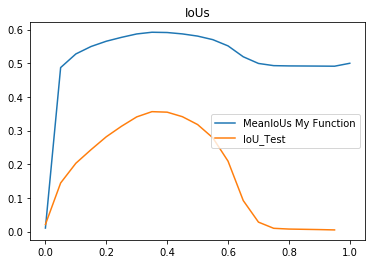

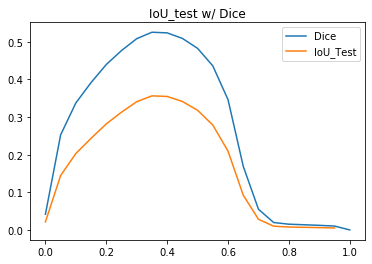

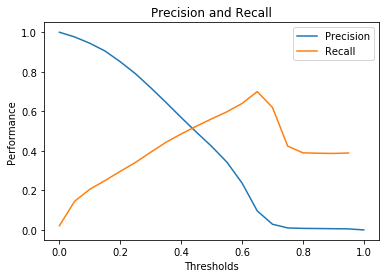

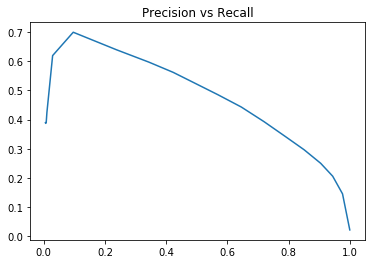

In [206]:
#NOTE: 
#I have implemented a custom IoU functon that determines the MEAN IoU, which includes the background IoU
#This is a heavily biased metric, and I think it makes the model seem better than it is. 
#Heavy class imbalance at the edges of the image due to padding causes the MeanIoU to skyrocket (~double reg IoU)
#IoU from sklearn is probably better. 

#Total Error metric does not seem very informative. 

#Utility to Plot Relavent Information 
print(EPOCHS)
print('Best IoU Threshold',best_IoU_thresh)
print('Mean IoU: ', np.max(meanIoUs_each_threshold))
print('Best Accuracy Threshold:', best_acc_thresh)

sens = TPR_list[abs(difference_array).argmin()]
spec = 1 - FPR_list[abs(difference_array).argmin()]

print('Optimal Accuracy Sens:', sens)
print('Optimal Accuracy Spec:', spec)

#copy this over into excel, split with , delimiter. 
print(EPOCHS,best_IoU_thresh,np.max(meanIoUs_each_threshold),best_acc_thresh,sens,spec)
print(' ')
print('meanIoUs_each_threshold')
print(meanIoUs_each_threshold)
print(' ')
print('IoUs')
print(IoUs)
print(' ')
print('Dice')
print(Dice)

print(' ')
print('precision')
print(precision)

print(' ')
print('recall')
print(TPR_list)

plt.figure(1)
plt.plot(thresholds,meanIoUs_each_threshold)
plt.plot(thresholds, IoUs)
plt.title("IoUs")
plt.legend(['MeanIoUs My Function', 'IoU_Test'])

plt.figure(2)
plt.plot(thresholds,Dice)
plt.plot(thresholds,IoU_test)
plt.title("IoU_test w/ Dice")
plt.legend(['Dice', 'IoU_Test'])

plt.figure(4)
plt.plot(thresholds, precision)
plt.plot(thresholds, TPR_list)
plt.title('Precision and Recall')
plt.xlabel('Thresholds')
plt.ylabel('Performance')
plt.legend(['Precision','Recall'])

#Quarter-circle type curve
plt.figure(5)
plt.plot(precision,TPR_list)
plt.title('Precision vs Recall')


In [209]:
#If the best threshold is not a variable, we're probably missing info. 
#Load this into memory. 
with open('ROC_AUC_results_better_metrics.pkl','rb') as f:  
    TPR_list, FPR_list, precision, thresholds, best_acc_thresh, IoUs, Dice = pickle.load(f)

In [210]:
IoUs

[0.021287148685778603,
 0.1445629197332417,
 0.20308967241611797,
 0.2435086696017613,
 0.28178815862868883,
 0.3129934430616888,
 0.3407922316954836,
 0.356328486339905,
 0.35481113329119623,
 0.34139475582546264,
 0.31803394935376345,
 0.27871352667394045,
 0.20933851139344684,
 0.09230288151888809,
 0.028246631535465874,
 0.009912263879566594,
 0.007665438307985934,
 0.006904955320877335,
 0.006121579771836402,
 0.005133890910843838,
 nan]

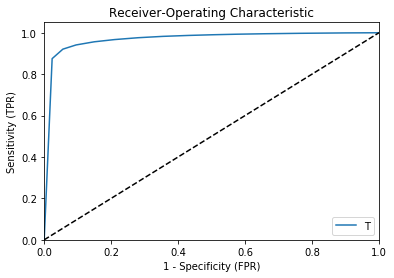

In [38]:
#Plot the ROC curve and determine the optimal cut-off threshold point
#evaluateModel.ROC_AUC(FPR_list, TPR_list)
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
ax.plot(FPR_list, TPR_list)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1 - Specificity (FPR)')
ax.set_ylabel('Sensitivity (TPR)')
ax.set_title('Receiver-Operating Characteristic')
ax.legend('T',loc = "lower right")


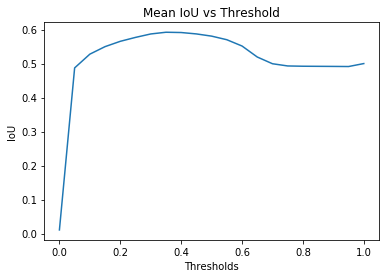

In [39]:
plt.title("Mean IoU vs Threshold")
plt.xlabel("Thresholds")
plt.ylabel("IoU")
plt.plot(thresholds,meanIoUs_each_threshold)

In [130]:
#This section is made to analyze how well the model performed overall. 
del model
model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)
modelPath = "/home/mccrinbc/Registered_Brains_FA/models_saved/TBI_model-End-2020-09-30-19.pt"
model.load_state_dict(torch.load(modelPath))
model.eval() #put into evaluation mode
model.to(torch.device('cpu'))
    
#These need to be the results correspodning to the model you're loading. 
with open('results_TBI_model-End-2020-09-30-19.pkl','rb') as f:  
    brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset = pickle.load(f)

loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = num_workers)

#data is called from the loader as loader.dataset[image-label_number][0 OR 1] (shape: [1,256,256])

In [131]:
print(test_dataset.transform)

Compose(
    RandomAffine(degrees=(0, 0), scale=[1, 1])
    RandomHorizontalFlip(p=0)
    Pad(padding=37, fill=0, padding_mode=constant)
    ToTensor()
)


In [132]:
def load_image_result(loader, index, model, threshold):
    #The model expects there to be a batch of images. Need to specify a single image in batch. 
    
    brain = loader.dataset[index][0].unsqueeze(0) #index brain/label, get brain only, compress to only 2D
    label = loader.dataset[index][1][0]
    
    predictions, _ = model(brain)
    predictions = torch.sigmoid(predictions)
    thresh_prediction = predictions > threshold
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
    #fig.suptitle('Brain, True Label, Prediction')
    ax1.imshow(brain[0][0].detach().numpy())
    ax2.imshow(label.detach().numpy())
    ax3.imshow(predictions[0][0].detach().numpy() > threshold)
    
    mean_IoU = IoU(thresh_prediction, label)
    print(mean_IoU)
    
    return thresh_prediction

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


0.571426568195942


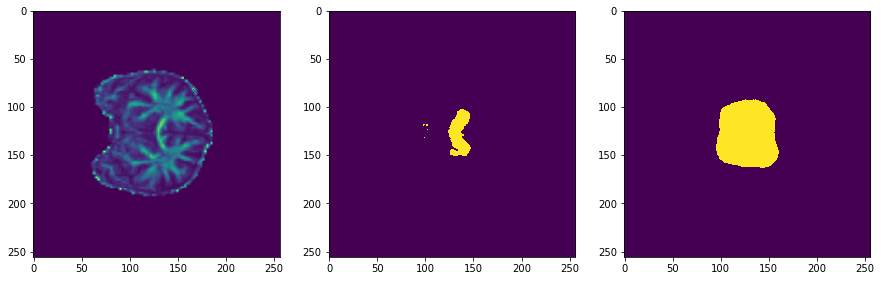

In [36]:
thresh_prediction = load_image_result(loader, 30, model, best_thresh) #Takes a second to run if on CPU. 

#non-deterministic behaviour might be occuring because of the transform function explicity built into the
#dataset call above. Potentially retrain and remove transform from testing dataset. 

#Each call of loader.dataset could be passing in the FIRST image you expect through a set of RANDOM transformations
#This would make sense as to why we're getting randomness. 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [106]:
#Load the brains, Determine the Predictions, Threshold the prediction with optimal value, plot

image_loc = 1
brains, labels = loader[2] #Pick batches you'd like to see. Must be <= batch_total

predictions, _ = model(brains)
predictions = torch.sigmoid(predictions)

predictions = predictions > best_thresh #not sure if this is going to work with a batch of images. 

plt.subplot(1,2,1)
plt.imshow(predictions[image_loc,0,:,:])
plt.subplot(1,2,2)
plt.plt(labels[image_loc,0,:,:])

TypeError: 'DataLoader' object is not subscriptable

In [109]:
a = sklearn.metrics.confusion_matrix([True, False, False, True], [True, True, True, False], labels = [True,False])

In [155]:
prediction, label = torch.zeros(10,10), torch.zeros(10,10)

In [156]:
label[2:4,3:7] = 1
prediction[3:5,2:6] = 1

In [157]:
print(prediction)
print(prediction + label)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 2., 2., 2., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]

In [165]:
test =  sklearn.metrics.confusion_matrix(prediction.numpy().ravel() > 0,label.numpy().ravel() > 0, labels = [True,False])

In [166]:
test

array([[ 3,  5],
       [ 5, 87]])

In [176]:
IoU = test[0][0] / (test[0][0] + test[0][1] + test[1][0])
print(IoU)

prediction = prediction > 0
label = label > 0
print(prediction.shape)
intersection = int(torch.sum(torch.mul(prediction,label)))
#mean_IoU = IoU(prediction > 0, label > 0)

0.23076923076923078
torch.Size([10, 10])


In [182]:
    #Good
    intersection = int(torch.sum(torch.mul(prediction,label)))
    union = int(torch.sum(prediction) + torch.sum(label)) - intersection
    IOU_predicted = intersection / (union + 0.0001) #for stability
    print(IOU_predicted)

0.23076745563495665


In [184]:
    #Background IoU
    all_zeros = (prediction + label) > 0 #before the inversion
    intersection = int(torch.sum(~all_zeros))
    union = int(torch.sum(~ (prediction > 0)) + torch.sum(~ (label > 0)) - intersection)
    IOU_background = intersection / (union + 0.0001)
    
    mean_IOU = (IOU_background + IOU_predicted)/2
    print(mean_IOU)

0.5638368737420701


In [189]:
model.decoder

UnetDecoder(
  (center): Identity()
  (blocks): ModuleList(
    (0): DecoderBlock(
      (conv1): Conv2dReLU(
        (0): Conv2d(3072, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (attention1): Attention(
        (attention): Identity()
      )
      (conv2): Conv2dReLU(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (attention2): Attention(
        (attention): Identity()
      )
    )
    (1): DecoderBlock(
      (conv1): Conv2dReLU(
        (0): Conv2d(768, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inpla